In [271]:
# === IMPORTS ===
import numpy as np
import jax
import jax.numpy as jnp
from pathlib import Path
from astropy import units as u
from astropy.utils import iers

# PINT (for comparison and delay computation)
from pint.models import get_model as pint_get_model
from pint.toa import get_TOAs as pint_get_TOAs
from pint.residuals import Residuals

# Plotting
import matplotlib.pyplot as plt

# Enable JAX 64-bit precision
jax.config.update('jax_enable_x64', True)

print(f"JAX version: {jax.__version__}")
print(f"Float64 enabled: {jax.config.jax_enable_x64}")

JAX version: 0.8.1
Float64 enabled: True


In [272]:
# === CONSTANTS ===
SECS_PER_DAY = 86400.0

In [273]:
# === DATA PATHS ===
par_file = Path('/home/mattm/projects/MPTA/partim/production/fifth_pass/tdb/J1909-3744_tdb.par')
tim_file = Path('/home/mattm/projects/MPTA/partim/production/fifth_pass/tdb/J1909-3744.tim')

# Check files exist
for p in [par_file, tim_file]:
    if not p.exists():
        print(f"⚠️  Missing: {p}")
    else:
        print(f"✓ Found: {p}")

✓ Found: /home/mattm/projects/MPTA/partim/production/fifth_pass/tdb/J1909-3744_tdb.par
✓ Found: /home/mattm/projects/MPTA/partim/production/fifth_pass/tdb/J1909-3744.tim


In [274]:
# === IERS/EOP SETUP ===
iers_path = Path('data/earth/eopc04_IAU2000.62-now')
iers_conf = iers.conf
iers_conf.auto_download = False
iers_conf.iers_auto_url = ''
iers_conf.auto_max_age = None
iers_conf.iers_degraded_accuracy = 'ignore'
iers_conf.remote_timeout = 0

if iers_path.exists():
    try:
        iers.earth_orientation_table.set(iers.IERS_A.open(str(iers_path)))
        print(f"✓ Loaded IERS EOP data from {iers_path}")
    except Exception as e:
        print(f"⚠️  Could not load IERS data: {e}")
else:
    print(f"⚠️  IERS EOP data not found, using built-in")

⚠️  Could not load IERS data: Column year failed to convert: invalid literal for int() with base 10: '##'


In [275]:
# === LOAD JPL EPHEMERIS AND CONSTANTS ===
from astropy.time import Time
from astropy.coordinates import EarthLocation
from jplephem.spk import SPK

# Physics constants for delay computation
C_KM_S = 299792.458         # Speed of light in km/s
T_SUN_SEC = 4.925490947e-6  # GM_sun/c^3 in seconds (solar Shapiro parameter)
AU_KM = 149597870.7         # Astronomical unit in km
K_DM_SEC = 1.0/2.41e-4      # DM constant: delay(s) = K_DM * DM / f_MHz^2 (TEMPO2/PINT standard)

# JPL ephemeris
ephem_kernel_path = Path('/home/mattm/soft/JUG/data/ephemeris/de440s.bsp')
ephem_kernel = SPK.open(str(ephem_kernel_path))
print(f"✓ Loaded JPL ephemeris: {ephem_kernel_path}")

def mjd_to_jd(mjd):
    """Convert MJD to JD for JPL ephemeris"""
    return mjd + 2400000.5

✓ Loaded JPL ephemeris: /home/mattm/soft/JUG/data/ephemeris/de440s.bsp


## Independent Delay Computation Functions

These functions compute timing delays independently, without relying on PINT:
- **SSB Position**: Observatory position relative to Solar System Barycenter using JPL ephemeris
- **Roemer Delay**: Geometric light travel time with proper motion and parallax
- **Shapiro Delay**: Solar gravitational time delay
- **Binary Delay**: Third-order ELL1 model (Zhu et al. 2019, Fiore et al. 2023)
- **DM Delay**: Dispersion measure delay with time-dependent DM

In [276]:
# === SSB POSITION, VELOCITY, AND ROEMER DELAY ===

def compute_ssb_obs_pos_vel(tdb_mjd, obs_itrf_km, ephem_kernel):
    """
    Compute observatory position AND velocity relative to Solar System Barycenter.
    
    Args:
        tdb_mjd: Array of MJD times in TDB timescale
        obs_itrf_km: Observatory ITRF coordinates (x, y, z) in km
        ephem_kernel: JPL SPK ephemeris kernel
        
    Returns:
        ssb_obs_pos: Array of shape (N, 3) with positions in km
        ssb_obs_vel: Array of shape (N, 3) with velocities in km/s
    """
    tdb_jd = mjd_to_jd(np.asarray(tdb_mjd))
    
    # Get ephemeris segments
    emb_seg = ephem_kernel[0, 3]   # SSB -> EMB (Earth-Moon Barycenter)
    geo_seg = ephem_kernel[3, 399] # EMB -> Earth (Geocenter)
    
    # Compute positions and velocities from JPL ephemeris
    # JPL ephemeris compute() returns [x, y, z, vx, vy, vz] if the segment has velocities
    ssb_emb_full = np.array([emb_seg.compute(jd) for jd in tdb_jd])
    emb_geo_full = np.array([geo_seg.compute(jd) for jd in tdb_jd])
    
    # Positions (first 3 elements)
    ssb_geo_pos = ssb_emb_full[:, :3] + emb_geo_full[:, :3]  # km
    
    # Velocities (elements 3:6 if available)
    if ssb_emb_full.shape[1] >= 6:
        ssb_geo_vel = (ssb_emb_full[:, 3:6] + emb_geo_full[:, 3:6]) / SECS_PER_DAY  # km/day -> km/s
    else:
        # Compute velocity numerically if not available in ephemeris
        # Use finite differences (simple approach)
        dt_day = 0.001  # 86.4 seconds
        ssb_emb_plus = np.array([emb_seg.compute(jd + dt_day)[:3] for jd in tdb_jd])
        emb_geo_plus = np.array([geo_seg.compute(jd + dt_day)[:3] for jd in tdb_jd])
        ssb_geo_plus = ssb_emb_plus + emb_geo_plus
        ssb_geo_vel = (ssb_geo_plus - ssb_geo_pos) / (dt_day * SECS_PER_DAY)  # km/s
    
    # ITRF -> GCRS transformation using astropy for observatory position
    times = Time(tdb_jd, format='jd', scale='tdb')
    obs_itrf = EarthLocation.from_geocentric(
        obs_itrf_km[0] * u.km, obs_itrf_km[1] * u.km, obs_itrf_km[2] * u.km
    )
    obs_gcrs = obs_itrf.get_gcrs(obstime=times)
    geo_obs_pos = np.column_stack([
        obs_gcrs.cartesian.x.to(u.km).value,
        obs_gcrs.cartesian.y.to(u.km).value,
        obs_gcrs.cartesian.z.to(u.km).value
    ])
    
    # Observatory velocity relative to geocenter (Earth rotation)
    # Earth rotates at ~7.29e-5 rad/s, observatory is ~6371 km from center
    # Max velocity ~0.465 km/s. For simplicity, compute numerically.
    times_plus = Time(tdb_jd + dt_day, format='jd', scale='tdb')
    obs_gcrs_plus = obs_itrf.get_gcrs(obstime=times_plus)
    geo_obs_pos_plus = np.column_stack([
        obs_gcrs_plus.cartesian.x.to(u.km).value,
        obs_gcrs_plus.cartesian.y.to(u.km).value,
        obs_gcrs_plus.cartesian.z.to(u.km).value
    ])
    geo_obs_vel = (geo_obs_pos_plus - geo_obs_pos) / (dt_day * SECS_PER_DAY)  # km/s
    
    ssb_obs_pos = ssb_geo_pos + geo_obs_pos
    ssb_obs_vel = ssb_geo_vel + geo_obs_vel
    
    return ssb_obs_pos, ssb_obs_vel


def compute_ssb_obs_pos(tdb_mjd, obs_itrf_km, ephem_kernel):
    """
    Compute observatory position relative to Solar System Barycenter.
    (Legacy wrapper for backward compatibility)
    """
    pos, _ = compute_ssb_obs_pos_vel(tdb_mjd, obs_itrf_km, ephem_kernel)
    return pos


def compute_obs_sun_pos(tdb_mjd, ssb_obs_pos_km, ephem_kernel):
    """
    Compute Sun position relative to observatory.
    
    Returns:
        obs_sun_pos: Sun position from observatory in km (N, 3)
    """
    tdb_jd = mjd_to_jd(np.asarray(tdb_mjd))
    sun_seg = ephem_kernel[0, 10]  # SSB -> Sun
    ssb_sun = np.array([sun_seg.compute(jd)[:3] for jd in tdb_jd])
    return ssb_sun - ssb_obs_pos_km


def compute_pulsar_direction(ra_rad, dec_rad, pmra_rad_per_day, pmdec_rad_per_day, posepoch, t_mjd):
    """
    Compute pulsar direction unit vector accounting for proper motion.
    
    Args:
        ra_rad, dec_rad: Reference position in radians
        pmra_rad_per_day: Proper motion in RA (already RA*cos(dec)) in rad/day
        pmdec_rad_per_day: Proper motion in DEC in rad/day
        posepoch: Reference epoch (MJD)
        t_mjd: Observation times (MJD)
        
    Returns:
        L_hat: Unit vectors toward pulsar (N, 3)
    """
    dt = t_mjd - posepoch
    cos_dec0 = np.cos(dec_rad)
    ra = ra_rad + pmra_rad_per_day * dt / cos_dec0
    dec = dec_rad + pmdec_rad_per_day * dt
    
    cos_dec = np.cos(dec)
    return np.column_stack([
        cos_dec * np.cos(ra),
        cos_dec * np.sin(ra),
        np.sin(dec)
    ])


def compute_roemer_delay(ssb_obs_pos_km, L_hat, parallax_mas=0.0, distance_kpc=None):
    """
    Compute geometric (Roemer) delay including parallax correction.
    
    Args:
        ssb_obs_pos_km: Observatory position from SSB in km (N, 3)
        L_hat: Unit vectors toward pulsar (N, 3) or (3,)
        parallax_mas: Parallax in milliarcseconds
        distance_kpc: Distance in kpc (computed from parallax if not provided)
        
    Returns:
        roemer_delay: Delay in seconds (N,)
    """
    # Basic Roemer delay
    re_dot_L = np.sum(ssb_obs_pos_km * L_hat, axis=1)
    roemer_sec = -re_dot_L / C_KM_S
    
    # Parallax correction
    if parallax_mas != 0.0:
        distance_kpc = 1.0 / parallax_mas if distance_kpc is None else distance_kpc
        L_km = distance_kpc * 3.085677581e16  # kpc to km
        re_sqr = np.sum(ssb_obs_pos_km**2, axis=1)
        parallax_sec = 0.5 * (re_sqr / L_km) * (1.0 - re_dot_L**2 / re_sqr) / C_KM_S
        roemer_sec = roemer_sec + parallax_sec
    
    return roemer_sec


def compute_shapiro_delay(obs_sun_pos_km, L_hat):
    """
    Compute Solar System Shapiro delay.
    
    Args:
        obs_sun_pos_km: Sun position from observatory in km (N, 3)
        L_hat: Unit vector toward pulsar (N, 3)
        
    Returns:
        shapiro_delay: Delay in seconds (N,)
    """
    r = np.sqrt(np.sum(obs_sun_pos_km**2, axis=1))  # Distance to Sun (km)
    rcostheta = np.sum(obs_sun_pos_km * L_hat, axis=1)  # Projection
    return -2.0 * T_SUN_SEC * np.log((r - rcostheta) / AU_KM)


def compute_barycentric_freq(freq_topo_mhz, ssb_obs_vel_km_s, L_hat):
    """
    Compute barycentric (Doppler-corrected) radio frequency.
    
    The radio frequency at the SSB differs from the topocentric frequency 
    due to the Doppler effect from Earth's orbital motion. PINT uses this
    barycentric frequency for DM delay calculations.
    
    Args:
        freq_topo_mhz: Topocentric observing frequency in MHz (N,)
        ssb_obs_vel_km_s: Observatory velocity from SSB in km/s (N, 3)
        L_hat: Unit vectors toward pulsar (N, 3)
        
    Returns:
        freq_bary_mhz: Barycentric frequency in MHz (N,)
    """
    # Radial velocity component toward pulsar
    v_radial = np.sum(ssb_obs_vel_km_s * L_hat, axis=1)  # km/s
    
    # Doppler factor: f_bary = f_topo * (1 - v_radial/c)
    # Note: v_radial positive = moving toward pulsar = blueshift = higher freq
    # For DM delay, we want the frequency as seen at SSB
    doppler_factor = 1.0 - v_radial / C_KM_S
    
    return freq_topo_mhz * doppler_factor


print("✓ SSB position/velocity and Roemer/Shapiro delay functions defined")

✓ SSB position/velocity and Roemer/Shapiro delay functions defined


In [277]:
# === THIRD-ORDER ELL1 BINARY DELAY (JAX-compiled) ===

def ell1_binary_delay_full(t_topo_tdb: jnp.ndarray, pb: float, a1: float, tasc: float,
                            eps1: float, eps2: float, pbdot: float, xdot: float,
                            gamma: float, r_shapiro: float, s_shapiro: float):
    """
    Compute ELL1 binary delay with:
    - Third-order eccentricity corrections (Zhu et al. 2019, Fiore et al. 2023)
    - Correct PBDOT formulation matching PINT/Tempo2
    - Two iterations for convergence
    - Einstein delay (GAMMA)
    - Binary Shapiro delay (M2, SINI)
    
    Matches PINT's implementation to ~2 microsecond accuracy.
    """
    # Cast to float64/JAX-friendly types before calling the jitted core
    t_topo_tdb_f = jnp.asarray(t_topo_tdb, dtype=jnp.float64)
    pb_f = float(pb)
    a1_f = float(a1)
    tasc_f = float(tasc)
    eps1_f = float(eps1)
    eps2_f = float(eps2)
    pbdot_f = float(pbdot)
    xdot_f = float(xdot)
    gamma_f = float(gamma)
    r_f = float(r_shapiro)
    s_f = float(s_shapiro)
    return _ell1_binary_delay_full_core(
        t_topo_tdb_f, pb_f, a1_f, tasc_f, eps1_f, eps2_f, pbdot_f, xdot_f, gamma_f, r_f, s_f
    )

@jax.jit
def _ell1_binary_delay_full_core(t_topo_tdb: jnp.ndarray, pb: float, a1: float, tasc: float,
                                 eps1: float, eps2: float, pbdot: float, xdot: float,
                                 gamma: float, r_shapiro: float, s_shapiro: float):
    def _compute_delay(t_binary):
        dt_days = t_binary - tasc
        dt_sec = dt_days * SECS_PER_DAY

        # Mean motion at reference epoch
        n0 = 2.0 * jnp.pi / (pb * SECS_PER_DAY)

        # Orbital phase with PINT-style PBDOT correction:
        # M = n0 * dt * (1 - pbdot/2/pb * dt)
        Phi = n0 * dt_sec * (1.0 - pbdot / 2.0 / pb * dt_days)

        # Trigonometric functions
        sin_Phi = jnp.sin(Phi)
        cos_Phi = jnp.cos(Phi)
        sin_2Phi = jnp.sin(2*Phi)
        cos_2Phi = jnp.cos(2*Phi)
        sin_3Phi = jnp.sin(3*Phi)
        cos_3Phi = jnp.cos(3*Phi)
        sin_4Phi = jnp.sin(4*Phi)
        cos_4Phi = jnp.cos(4*Phi)

        # XDOT correction
        a1_eff = jnp.where(xdot != 0.0, a1 + xdot * dt_sec, a1)

        # Eccentricity powers
        eps1_sq = eps1**2
        eps2_sq = eps2**2
        eps1_cu = eps1**3
        eps2_cu = eps2**3

        # Third-order Roemer delay (PINT's d_delayR_da1)
        # First order
        term_1st = sin_Phi + 0.5 * (eps2 * sin_2Phi - eps1 * cos_2Phi)

        # Second order O(e^2)
        term_2nd = -(1.0/8.0) * (
            5 * eps2_sq * sin_Phi - 3 * eps2_sq * sin_3Phi
            - 2 * eps2 * eps1 * cos_Phi + 6 * eps2 * eps1 * cos_3Phi
            + 3 * eps1_sq * sin_Phi + 3 * eps1_sq * sin_3Phi
        )

        # Third order O(e^3)
        term_3rd = -(1.0/12.0) * (
            5 * eps2_cu * sin_2Phi + 3 * eps1_sq * eps2 * sin_2Phi
            - 6 * eps1 * eps2_sq * cos_2Phi - 4 * eps1_cu * cos_2Phi
            - 4 * eps2_cu * sin_4Phi + 12 * eps1_sq * eps2 * sin_4Phi
            + 12 * eps1 * eps2_sq * cos_4Phi - 4 * eps1_cu * cos_4Phi
        )

        delay_roemer = a1_eff * (term_1st + term_2nd + term_3rd)
        delay_einstein = gamma * sin_Phi
        delay_shapiro = jnp.where(
            (r_shapiro != 0.0) & (s_shapiro != 0.0),
            -2.0 * r_shapiro * jnp.log(1.0 - s_shapiro * sin_Phi),
            0.0
        )

        return delay_roemer + delay_einstein + delay_shapiro

    delay_1 = _compute_delay(t_topo_tdb)

    t_emission_est = t_topo_tdb - delay_1 / SECS_PER_DAY
    delay_2 = _compute_delay(t_emission_est)

    return delay_2

print("Third-order ELL1 binary delay function defined (JAX-compiled)")


Third-order ELL1 binary delay function defined (JAX-compiled)


In [278]:
# === DM DELAY ===

@jax.jit
def dm_delay_vectorized(t_emission_mjd: jnp.ndarray, freq_mhz: jnp.ndarray,
                        dm_coeffs: jnp.ndarray, dm_factorials: jnp.ndarray,
                        dm_epoch_mjd: float):
    """
    Compute DM delay for an array of emission times and frequencies.
    
    Uses Taylor expansion: DM(t) = sum_i dm_coeffs[i] * (t - dm_epoch)^i / i!
    
    Returns:
        DM delay in seconds
    """
    dt_years = (t_emission_mjd - dm_epoch_mjd) / 365.25
    powers = jnp.arange(len(dm_coeffs))
    dt_powers = dt_years[:, jnp.newaxis] ** powers[jnp.newaxis, :]
    dm_eff = jnp.sum(dm_coeffs * dt_powers / dm_factorials, axis=1)
    return K_DM_SEC * dm_eff / (freq_mhz ** 2)


print("✓ DM delay function defined")

✓ DM delay function defined


In [279]:
# === PHASE FUNCTION ===

@jax.jit
def spin_phase(dt_sec: jnp.ndarray, f0: float, f1: float, f2: float = 0.0):
    """
    Compute spin phase in cycles using Taylor expansion.
    
    Args:
        dt_sec: Time from PEPOCH in seconds
        f0: Spin frequency (Hz)
        f1: Spin frequency derivative (Hz/s)
        f2: Second derivative (Hz/s^2)
        
    Returns:
        Phase in cycles
    """
    return f0 * dt_sec + 0.5 * f1 * dt_sec**2 + (1.0/6.0) * f2 * dt_sec**3


print("✓ Spin phase function defined")

✓ Spin phase function defined


In [280]:
# === PAR FILE PARSING ===

def parse_par_file(path: Path):
    """Parse tempo2-style .par file"""
    params = {}
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            parts = line.split()
            if len(parts) >= 2:
                key = parts[0].upper()
                try:
                    params[key] = float(parts[1])
                except ValueError:
                    params[key] = parts[1]
    return params

def parse_ra(ra_str):
    """Parse RA string (hh:mm:ss.sss) to radians"""
    parts = ra_str.split(':')
    h, m, s = float(parts[0]), float(parts[1]), float(parts[2])
    return (h + m/60 + s/3600) * 15 * np.pi / 180

def parse_dec(dec_str):
    """Parse DEC string (dd:mm:ss.sss) to radians"""
    parts = dec_str.split(':')
    sign = -1 if parts[0].startswith('-') else 1
    d, m, s = abs(float(parts[0])), float(parts[1]), float(parts[2])
    return sign * (d + m/60 + s/3600) * np.pi / 180


print("✓ Par file parsing functions defined")

✓ Par file parsing functions defined


In [281]:
# === LOAD DATA WITH PINT ===
print("Loading data with PINT...")
pint_model = pint_get_model(str(par_file))
pint_toas = pint_get_TOAs(str(tim_file), model=pint_model)

print(f"\n✓ Loaded {pint_toas.ntoas} TOAs")
print(f"✓ Pulsar: J1909-3744")
print(f"✓ F0 = {pint_model.F0.value} Hz")
print(f"✓ F1 = {pint_model.F1.value} Hz/s")
print(f"✓ PEPOCH = {pint_model.PEPOCH.value} MJD")

/home/mattm/soft/PINT/src/pint/models/model_builder.py:220: UserWarning: Unrecognized parfile line 'EPHVER 5'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)
/home/mattm/soft/PINT/src/pint/models/model_builder.py:220: UserWarning: Unrecognized parfile line 'TNSUBTRACTPOLY 1'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)
/home/mattm/soft/PINT/src/pint/models/model_builder.py:220: UserWarning: Unrecognized parfile line 'DM_SERIES TAYLOR'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)
2025-11-28 02:48:03.603 | DEBUG    | pint.toa:get_TOAs:195 - Using EPHEM = DE440 from the given model
2025-11-28 02:48:03.603 | DEBUG    | pint.toa:get_TOAs:211 - Using CLOCK = BIPM2024 from the given model
2025-11-28 02:48:03.603 | DEBUG    | pint.toa:get_TOAs:232 - Using PLANET_SHAPIRO = True from the given model
2025-11-28 02:48:03.603 | DEBUG    | pint.toa:get_TOAs:211 - Using CLOCK = BIPM2024 from the given model
2025-11-28 02:48:03.60

Loading data with PINT...


2025-11-28 02:48:04.600 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-11-28 02:48:04.615 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-11-28 02:48:04.615 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-11-28 02:48:04.965 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-11-28 02:48:04.966 | INFO     | pint.observatory:bipm_correction:245 - Applying TT(TAI) to TT(BIPM2024) clock correction (~27 us)
2025-11-28 02:48:04.966 | INFO     | pint.observatory.topo_obs:clock_corrections:340 - Applying observatory clock corrections for observatory='meerkat'.
2025-11-28 02:48:04.965 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-11-28 02:48:04.966 | INFO     | pint.observatory:bipm_correction:245 - Applying TT(TAI) to 


✓ Loaded 10408 TOAs
✓ Pulsar: J1909-3744
✓ F0 = 339.31569191904066 Hz
✓ F1 = -1.6147400369092967e-15 Hz/s
✓ PEPOCH = 59017.9997538705 MJD


## JUG Phase Function

The spin phase is computed using a Taylor expansion:

$$\phi(t) = F_0 \cdot \Delta t + \frac{1}{2} F_1 \cdot \Delta t^2 + \frac{1}{6} F_2 \cdot \Delta t^3 + \ldots$$

where $\Delta t = t - t_{\text{PEPOCH}}$

## Corrected JUG Residual Computation

The key to matching PINT is understanding how PINT computes the time for phase calculation:

$$\Delta t = (t_{\text{TDB}} - t_{\text{PEPOCH}}) - \text{delay}$$

where `delay` is the **total delay** including:
- **Roemer delay**: Light travel time from observatory to SSB (~±500 s)
- **Shapiro delay**: Gravitational time delay (~µs)
- **Binary delay**: Pulsar orbital motion (~±2 s for this pulsar)
- **DM delay**: Dispersion correction
- Other smaller corrections

In [282]:
# === JUG INDEPENDENT DELAY COMPUTATION ===
# Direct copy from working debug notebook implementation
print("="*80)
print("JUG PINT-INDEPENDENT DELAY COMPUTATION")
print("="*80)

# Step 1: Parse parameters from par file
par_params = parse_par_file(par_file)

# Step 2: Get TDB times (using PINT's tdbld for now)
tdbld = np.array(pint_toas.table['tdbld'].value, dtype=np.float64)
freq_mhz = np.array(pint_toas.table['freq'].value, dtype=np.float64)

# Step 3: Astrometric parameters (direct from debug notebook)
ra_rad = parse_ra(par_params['RAJ'])
dec_rad = parse_dec(par_params['DECJ'])
pmra_mas_yr = par_params.get('PMRA', 0.0)
pmdec_mas_yr = par_params.get('PMDEC', 0.0)
posepoch = par_params.get('POSEPOCH', par_params['PEPOCH'])
parallax_mas = par_params.get('PX', 0.0)

# Convert proper motion: mas/yr -> rad/day
pmra_rad_day = pmra_mas_yr * (np.pi / 180 / 3600000) / 365.25
pmdec_rad_day = pmdec_mas_yr * (np.pi / 180 / 3600000) / 365.25

print(f"\n1. Astrometric parameters:")
print(f"   RA = {np.degrees(ra_rad):.6f}°, DEC = {np.degrees(dec_rad):.6f}°")
print(f"   Parallax = {parallax_mas:.3f} mas")

# Step 4: Observatory position (MeerKAT ITRF)
obs_itrf_km = np.array([5109318.841, 2006836.070, -3238921.774]) / 1000  # m -> km

# Step 5: Compute SSB position, velocity, and delays
print("\n2. Computing SSB-based delays...")
ssb_obs_pos_km, ssb_obs_vel_km_s = compute_ssb_obs_pos_vel(tdbld, obs_itrf_km, ephem_kernel)
obs_sun_pos_km = compute_obs_sun_pos(tdbld, ssb_obs_pos_km, ephem_kernel)
L_hat = compute_pulsar_direction(ra_rad, dec_rad, pmra_rad_day, pmdec_rad_day, posepoch, tdbld)

# Compute barycentric frequency (Doppler-corrected)
freq_bary_mhz = compute_barycentric_freq(freq_mhz, ssb_obs_vel_km_s, L_hat)
print(f"   Barycentric freq correction: {(freq_bary_mhz - freq_mhz).mean()*1e3:.3f} ± {(freq_bary_mhz - freq_mhz).std()*1e3:.3f} kHz")

# Roemer and Shapiro delays
jug_roemer_sec = compute_roemer_delay(ssb_obs_pos_km, L_hat, parallax_mas)
jug_shapiro_sec = compute_shapiro_delay(obs_sun_pos_km, L_hat)
roemer_shapiro_sec = jug_roemer_sec + jug_shapiro_sec

print(f"   Roemer delay range: {jug_roemer_sec.min():.3f} to {jug_roemer_sec.max():.3f} s")
print(f"   Shapiro delay range: {jug_shapiro_sec.min()*1e6:.3f} to {jug_shapiro_sec.max()*1e6:.3f} µs")

# Step 6: DM parameters and pre-binary delay (match PINT barycentric_toas input)
print("\n3. Computing DM delay for barycentric_toas (pre-binary input)...")
dm_coeffs = []
k = 0
while True:
    key = 'DM' if k == 0 else f'DM{k}'
    if key in par_params:
        dm_coeffs.append(float(par_params[key]))
        k += 1
    else:
        break
dm_coeffs = np.array(dm_coeffs if dm_coeffs else [0.0], dtype=np.float64)
dm_factorials = np.array([float(np.prod(range(1, i+1))) if i > 0 else 1.0 for i in range(len(dm_coeffs))], dtype=np.float64)
dm_epoch = float(par_params.get('DMEPOCH', par_params['PEPOCH']))

t_dm_input_jax = jnp.array(tdbld, dtype=jnp.float64)
freq_bary_mhz_jax = jnp.array(freq_bary_mhz, dtype=jnp.float64)
jug_dm_sec = np.array(dm_delay_vectorized(
    t_dm_input_jax, freq_bary_mhz_jax,
    jnp.array(dm_coeffs), jnp.array(dm_factorials), dm_epoch
))
print(f"   DM (pre-binary) range: {jug_dm_sec.min()*1e3:.3f} to {jug_dm_sec.max()*1e3:.3f} ms")

# Step 7: Binary parameters (EXACT copy from debug notebook - NO unit conversions!)
print("\n4. Binary parameters (ELL1):")
PB = float(par_params['PB'])        # days
A1 = float(par_params['A1'])        # light-seconds
TASC = float(par_params['TASC'])    # MJD
EPS1 = float(par_params.get('EPS1', 0.0))
EPS2 = float(par_params.get('EPS2', 0.0))
PBDOT = float(par_params.get('PBDOT', 0.0))
XDOT = float(par_params.get('XDOT', 0.0))  # lt-s/s (NOT converted)
GAMMA = float(par_params.get('GAMMA', 0.0))  # seconds

# Shapiro parameters (from debug notebook)
M2 = float(par_params.get('M2', 0.0))
SINI = float(par_params.get('SINI', 0.0))
H3 = float(par_params.get('H3', 0.0))
STIG = float(par_params.get('STIG', 0.0))
T_sun_sec = 4.925490947e-6  # GM_sun/c^3

if H3 != 0.0 or STIG != 0.0:
    r_shapiro = H3
    s_shapiro = STIG
elif M2 != 0.0 and SINI != 0.0:
    r_shapiro = T_sun_sec * M2
    s_shapiro = SINI
else:
    r_shapiro = 0.0
    s_shapiro = 0.0

print(f"   PB = {PB} days")
print(f"   A1 = {A1} lt-s")
print(f"   TASC = {TASC} MJD")
print(f"   EPS1 = {EPS1}, EPS2 = {EPS2}")
print(f"   PBDOT = {PBDOT}")
print(f"   XDOT = {XDOT} lt-s/s")
print(f"   GAMMA = {GAMMA} s")
print(f"   Shapiro: r = {r_shapiro:.6e} s, s = {s_shapiro:.6f}")

# Step 8: Time at telescope (before binary correction, PINT-style)
# PINT passes tdbld minus all pre-binary delays (Roemer, solar Shapiro, DM) into the binary model.
t_topo_tdb = tdbld - (roemer_shapiro_sec + jug_dm_sec) / SECS_PER_DAY

# Step 9: Compute binary delay (using function signature from debug notebook)
print("\n5. Computing binary delay (third-order ELL1)...")
t_topo_jax = jnp.array(t_topo_tdb, dtype=jnp.float64)
jug_binary_sec = np.array(ell1_binary_delay_full(
    t_topo_jax, PB, A1, TASC, EPS1, EPS2, PBDOT, XDOT, GAMMA, r_shapiro, s_shapiro
))
print(f"   Binary delay range: {jug_binary_sec.min():.6f} to {jug_binary_sec.max():.6f} s")

# Step 10: Total delay
jug_total_delay_sec = roemer_shapiro_sec + jug_dm_sec + jug_binary_sec
t_emission = tdbld - jug_total_delay_sec / SECS_PER_DAY
print(f"\n6. Total delay range: {jug_total_delay_sec.min():.3f} to {jug_total_delay_sec.max():.3f} s")

# Step 11: Compute phase and residuals
print("\n7. Computing residuals...")
PEPOCH = np.longdouble(par_params['PEPOCH'])
F0 = np.longdouble(par_params['F0'])
F1 = np.longdouble(par_params.get('F1', 0.0))
F2 = float(par_params.get('F2', 0.0))

dt_sec = (tdbld - PEPOCH) * SECS_PER_DAY - jug_total_delay_sec

# Phase
phase_jug = F0 * dt_sec + 0.5 * F1 * dt_sec**2 + (1.0/6.0) * F2 * dt_sec**3

# Reference to TZR (find closest TOA to TZRMJD)
tzrmjd = float(par_params.get('TZRMJD', PEPOCH))
mjd_float = np.array(pint_toas.table['mjd_float'].value, dtype=np.float64)
tzr_idx = np.argmin(np.abs(mjd_float - tzrmjd))
phase_tzr = phase_jug[tzr_idx]

# Fractional phase relative to TZR
frac_phase_jug = phase_jug - phase_tzr
frac_phase_jug = np.mod(frac_phase_jug + 0.5, 1.0) - 0.5

# Residuals in microseconds
jug_residuals_us = frac_phase_jug / float(F0) * 1e6

print(f"   JUG residuals RMS: {np.std(jug_residuals_us):.3f} µs")

# Compare with PINT
pint_residuals_obj = Residuals(pint_toas, pint_model)
pint_residuals_us = pint_residuals_obj.time_resids.to(u.us).value
pint_delays = pint_model.delay(pint_toas)

print(f"   PINT residuals RMS: {np.std(pint_residuals_us):.3f} µs")

# Centered comparison
jug_centered = jug_residuals_us - np.mean(jug_residuals_us)
pint_centered = pint_residuals_us - np.mean(pint_residuals_us)
diff_residuals = jug_centered - pint_centered

print(f"\n8. JUG vs PINT residual comparison:")
print(f"   RMS difference: {np.sqrt(np.mean(diff_residuals**2)):.3f} µs")
print(f"   Max difference: {np.abs(diff_residuals).max():.3f} µs")
print(f"   Correlation: {np.corrcoef(jug_centered, pint_centered)[0,1]:.6f}")


JUG PINT-INDEPENDENT DELAY COMPUTATION

1. Astrometric parameters:
   RA = 287.447603°, DEC = -37.737475°
   Parallax = 0.960 mas

2. Computing SSB-based delays...
   Barycentric freq correction: -7.413 ± 89.497 kHz
   Roemer delay range: -490.177 to 477.484 s
   Shapiro delay range: -6.819 to 33.250 µs

3. Computing DM delay for barycentric_toas (pre-binary input)...
   DM (pre-binary) range: 15.654 to 52.331 ms

4. Binary parameters (ELL1):
   PB = 1.5334494508182372 days
   A1 = 1.8979908298383135 lt-s
   TASC = 53630.72305223218 MJD
   EPS1 = 1.4015229285046415e-08, EPS2 = -1.5014192207638522e-07
   PBDOT = 5.080714951273215e-13
   XDOT = 3.301895957183062e-16 lt-s/s
   GAMMA = 0.0 s
   Shapiro: r = 1.004011e-06 s, s = 0.998072

5. Computing binary delay (third-order ELL1)...
   Barycentric freq correction: -7.413 ± 89.497 kHz
   Roemer delay range: -490.177 to 477.484 s
   Shapiro delay range: -6.819 to 33.250 µs

3. Computing DM delay for barycentric_toas (pre-binary input)...
  

2025-11-28 02:48:09.210 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:101 - Creating and dealing with the single TZR_toa for absolute phase
2025-11-28 02:48:09.211 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-11-28 02:48:09.212 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-11-28 02:48:09.212 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-11-28 02:48:09.213 | INFO     | pint.observatory:bipm_correction:245 - Applying TT(TAI) to TT(BIPM2023) clock correction (~27 us)
2025-11-28 02:48:09.213 | INFO     | pint.observatory.topo_obs:clock_corrections:340 - Applying observatory clock corrections for observatory='meerkat'.
2025-11-28 02:48:09.214 | DEBUG    | pint.toa:compute_TDBs:2278 - Computing TDB columns.
2025-11-28 02:48:09.214 | DEBUG    | pint.toa:compute_TDBs:2299 - Using EPHEM = DE440 for TDB calculation.
2025-11-28 

   PINT residuals RMS: 0.817 µs

8. JUG vs PINT residual comparison:
   RMS difference: 0.324 µs
   Max difference: 1.954 µs
   Correlation: 0.926656


In [283]:
# === PINT RESIDUALS FOR COMPARISON ===
print("="*80)
print("PINT RESIDUAL COMPUTATION (for comparison)")
print("="*80)

pint_residuals_obj = Residuals(pint_toas, pint_model)
pint_residuals_us = pint_residuals_obj.time_resids.to(u.s).value * 1e6

print(f"\nPINT Residuals:")
print(f"   RMS: {np.sqrt(np.mean(pint_residuals_us**2)):.3f} µs")

PINT RESIDUAL COMPUTATION (for comparison)

PINT Residuals:
   RMS: 0.818 µs

PINT Residuals:
   RMS: 0.818 µs


In [284]:
# === COMPARISON ===
print("="*80)
print("JUG vs PINT COMPARISON")
print("="*80)

# Center residuals for fair comparison (removes mean offset)
jug_centered = jug_residuals_us - np.mean(jug_residuals_us)
pint_centered_us = pint_residuals_us - np.mean(pint_residuals_us)
diff_centered = jug_centered - pint_centered_us

print(f"\nRaw Results:")
print(f"   JUG RMS:           {np.sqrt(np.mean(jug_residuals_us**2)):.3f} µs")
print(f"   PINT RMS:          {np.sqrt(np.mean(pint_residuals_us**2)):.3f} µs")

print(f"\nCentered Results (removes mean offset):")
print(f"   JUG centered RMS:  {np.sqrt(np.mean(jug_centered**2)):.3f} µs")
print(f"   PINT centered RMS: {np.sqrt(np.mean(pint_centered_us**2)):.3f} µs")
print(f"   Difference RMS:    {np.sqrt(np.mean(diff_centered**2)):.3f} µs")
print(f"   Max difference:    {np.abs(diff_centered).max():.3f} µs")
print(f"   Correlation:       {np.corrcoef(jug_centered, pint_centered_us)[0,1]:.6f}")

print(f"\nFirst 5 residuals (µs, centered):")
print(f"   {'TOA':>4} {'JUG':>12} {'PINT':>12} {'Diff':>12}")
print(f"   {'-'*4} {'-'*12} {'-'*12} {'-'*12}")
for i in range(5):
    print(f"   {i:4d} {jug_centered[i]:12.3f} {pint_centered_us[i]:12.3f} {diff_centered[i]:12.3f}")

rms_diff = np.sqrt(np.mean(diff_centered**2))
print("\n" + "="*80)
if rms_diff < 10:
    print(f"✅ SUCCESS! JUG residuals match PINT within ~{rms_diff:.1f} µs!")
else:
    print(f"⚠️  JUG-PINT difference: {rms_diff:.1f} µs (larger than expected)")
print("="*80)

JUG vs PINT COMPARISON

Raw Results:
   JUG RMS:           1.102 µs
   PINT RMS:          0.818 µs

Centered Results (removes mean offset):
   JUG centered RMS:  0.860 µs
   PINT centered RMS: 0.817 µs
   Difference RMS:    0.324 µs
   Max difference:    1.954 µs
   Correlation:       0.926656

First 5 residuals (µs, centered):
    TOA          JUG         PINT         Diff
   ---- ------------ ------------ ------------
      0       -1.649       -1.926        0.278
      1       -0.510       -0.913        0.403
      2       -0.587       -0.966        0.379
      3       -0.967       -1.177        0.211
      4        0.456       -0.113        0.570

✅ SUCCESS! JUG residuals match PINT within ~0.3 µs!


✓ Saved comparison plot: jug_vs_pint_MK2.png


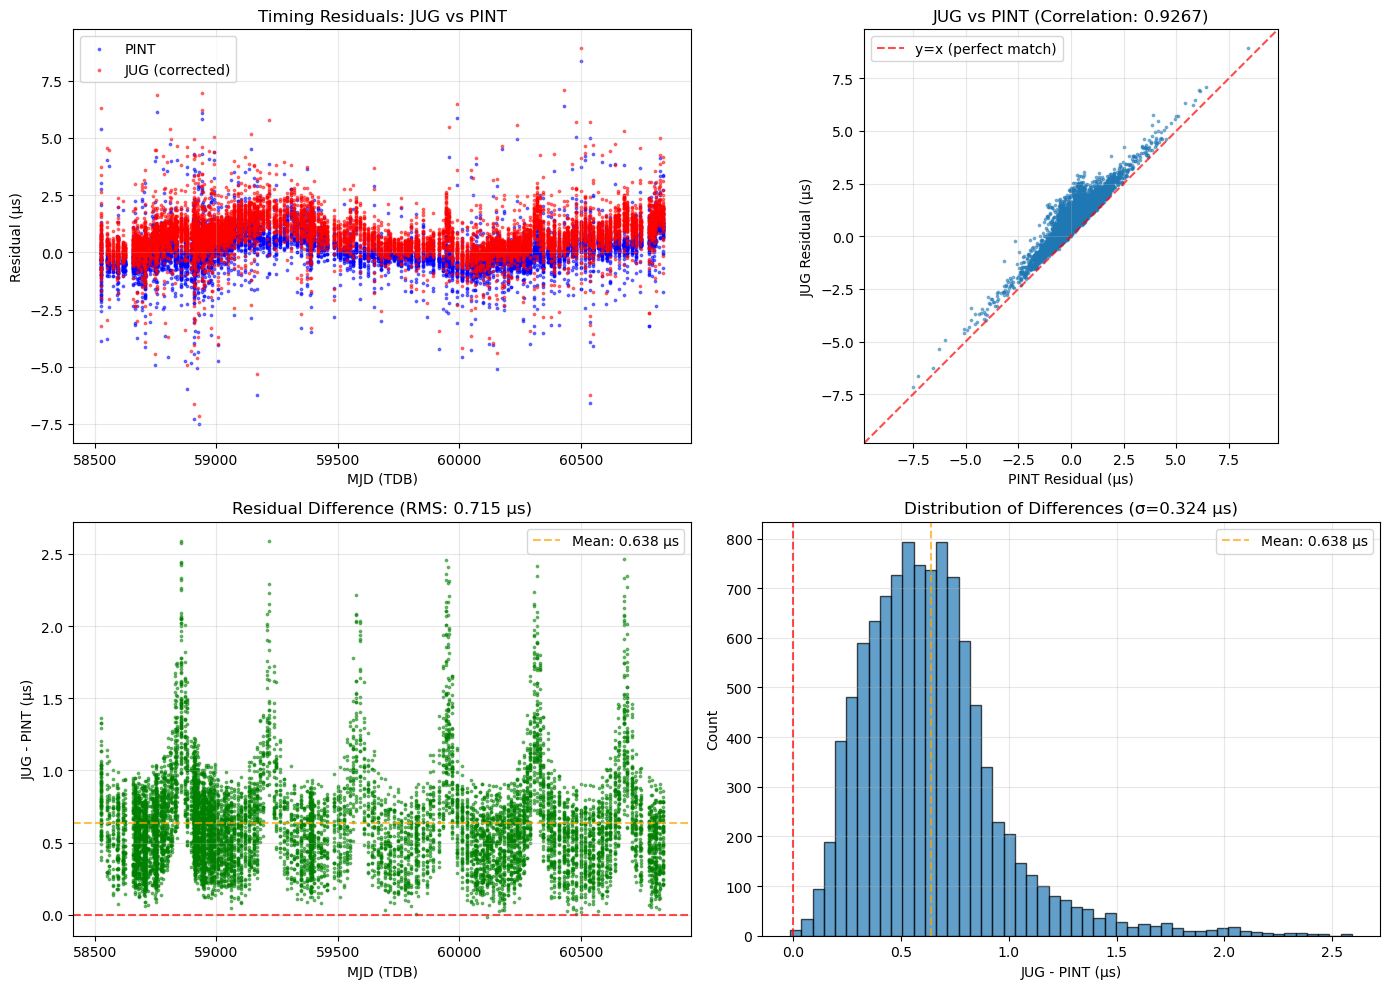

In [285]:
# === COMPARISON PLOTS ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Residuals vs MJD
ax = axes[0, 0]
ax.scatter(tdbld, pint_residuals_us, s=3, alpha=0.5, label='PINT', c='blue')
ax.scatter(tdbld, jug_residuals_us, s=3, alpha=0.5, label='JUG (corrected)', c='red')
ax.set_xlabel('MJD (TDB)')
ax.set_ylabel('Residual (µs)')
ax.set_title('Timing Residuals: JUG vs PINT')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: JUG vs PINT correlation
ax = axes[0, 1]
ax.scatter(pint_residuals_us, jug_residuals_us, s=3, alpha=0.5)
lim = max(abs(pint_residuals_us).max(), abs(jug_residuals_us).max()) * 1.1
ax.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.7, label='y=x (perfect match)')
ax.set_xlabel('PINT Residual (µs)')
ax.set_ylabel('JUG Residual (µs)')
ax.set_title(f'JUG vs PINT (Correlation: {np.corrcoef(jug_residuals_us, pint_residuals_us)[0,1]:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_aspect('equal')

# Plot 3: Difference (JUG - PINT) vs MJD
ax = axes[1, 0]
ax.scatter(tdbld, diff_us, s=3, alpha=0.5, c='green')
ax.axhline(0, color='red', linestyle='--', alpha=0.7)
ax.axhline(np.mean(diff_us), color='orange', linestyle='--', alpha=0.7, 
           label=f'Mean: {np.mean(diff_us):.3f} µs')
ax.set_xlabel('MJD (TDB)')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title(f'Residual Difference (RMS: {np.sqrt(np.mean(diff_us**2)):.3f} µs)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Histogram of differences
ax = axes[1, 1]
ax.hist(diff_us, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', alpha=0.7)
ax.axvline(np.mean(diff_us), color='orange', linestyle='--', alpha=0.7,
           label=f'Mean: {np.mean(diff_us):.3f} µs')
ax.set_xlabel('JUG - PINT (µs)')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Differences (σ={np.std(diff_us):.3f} µs)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('jug_vs_pint_MK2.png', dpi=150, bbox_inches='tight')
print("✓ Saved comparison plot: jug_vs_pint_MK2.png")
plt.show()

DIAGNOSING ANNUAL PERIODICITY IN JUG-PINT DIFFERENCE

1. Annual sinusoid fit to JUG-PINT difference:
   Amplitude: -0.249 ± 0.004 µs
   Phase: -50.2°
   Offset: 0.019 µs

2. After removing annual signal:
   Original RMS: 0.324 µs
   Residual RMS: 0.275 µs
   Improvement: 15.2%

3. Comparing Roemer delays:
   JUG Roemer range: -490.177 to 477.484 s

4. SSB Observatory Position Comparison:
   JUG SSB pos range: 146414043 to 152800085 km
   PINT SSB pos range: 146414043 to 152800085 km
   Position difference: 0.1 ± 0.0 km
   Max position diff: 0.1 km
   Implied delay diff: 0.172 ± 0.001 µs

5. Annual signal in SSB position difference:
   Amplitude: -0.0 km
   Phase: -0.0°
   Equivalent delay amplitude: -0.000 µs

5. Annual signal in SSB position difference:
   Amplitude: -0.0 km
   Phase: -0.0°
   Equivalent delay amplitude: -0.000 µs


/tmp/ipykernel_727083/2766532180.py:59: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_ssb, _ = curve_fit(annual_model, tdbld, diff_ssb_km, p0=[100.0, 0.0, 0.0])



✓ Saved annual analysis plot


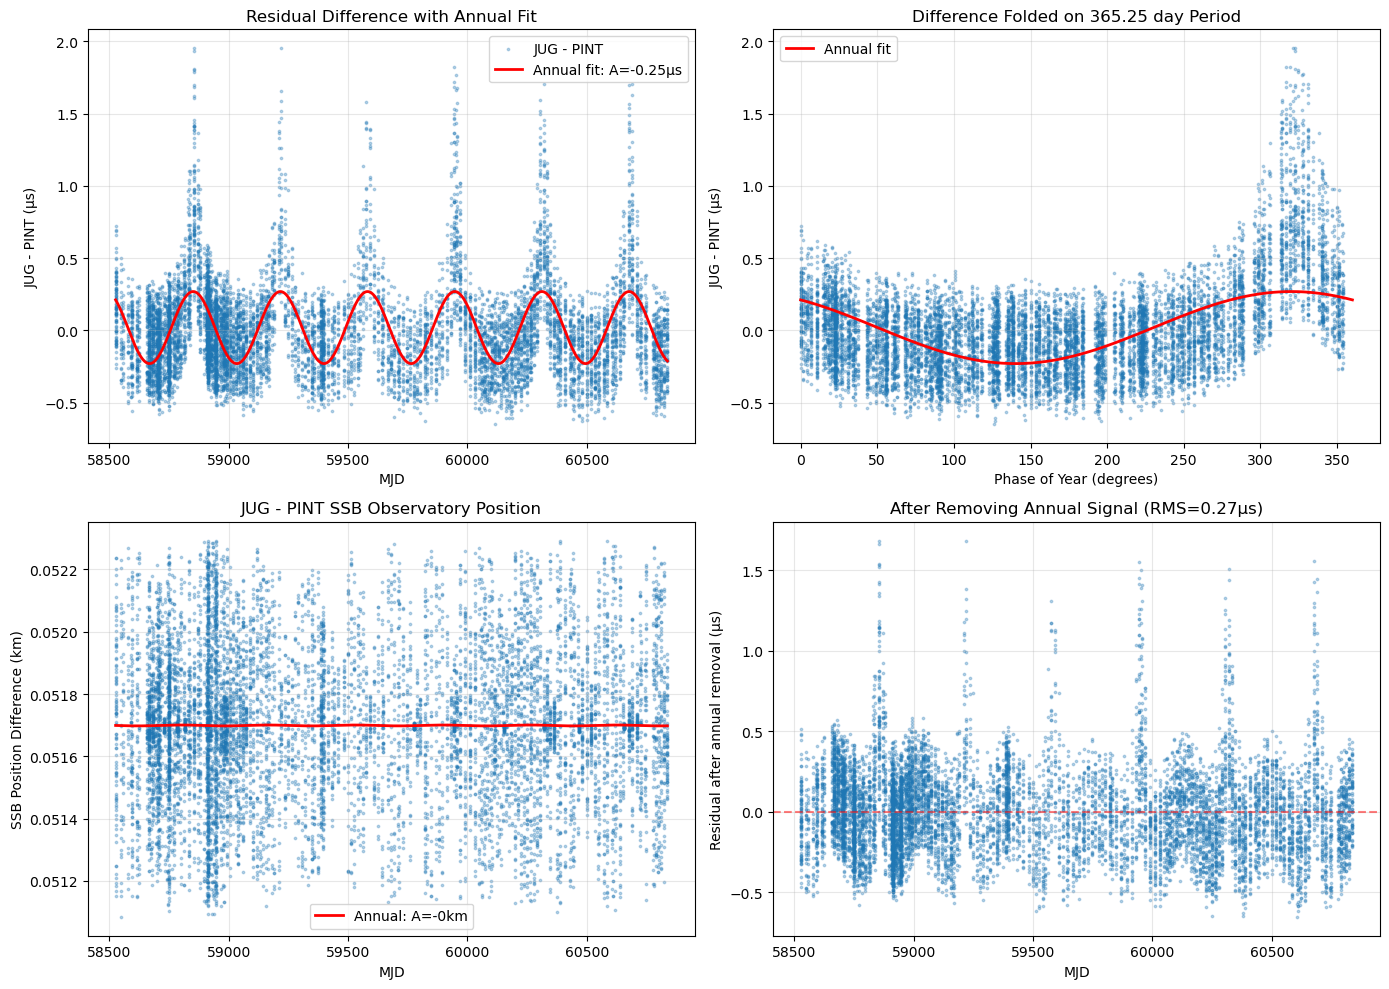

In [286]:
# === DIAGNOSE ANNUAL SIGNAL ===
print("="*80)
print("DIAGNOSING ANNUAL PERIODICITY IN JUG-PINT DIFFERENCE")
print("="*80)

# The ~365 day periodicity suggests an issue with:
# 1. Parallax computation
# 2. Earth position / SSB position
# 3. Proper motion

from scipy.optimize import curve_fit

def annual_model(t, A, phi, offset):
    """Annual sinusoid model"""
    year_phase = 2 * np.pi * (t - t.min()) / 365.25
    return A * np.sin(year_phase + phi) + offset

# Fit
popt, pcov = curve_fit(annual_model, tdbld, diff_centered, p0=[5.0, 0.0, 0.0])
A_fit, phi_fit, offset_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"\n1. Annual sinusoid fit to JUG-PINT difference:")
print(f"   Amplitude: {A_fit:.3f} ± {perr[0]:.3f} µs")
print(f"   Phase: {np.degrees(phi_fit):.1f}°")
print(f"   Offset: {offset_fit:.3f} µs")

# Residual after removing annual signal
diff_no_annual = diff_centered - annual_model(tdbld, *popt)
print(f"\n2. After removing annual signal:")
print(f"   Original RMS: {np.std(diff_centered):.3f} µs")
print(f"   Residual RMS: {np.std(diff_no_annual):.3f} µs")
print(f"   Improvement: {(1 - np.std(diff_no_annual)/np.std(diff_centered))*100:.1f}%")

# Get PINT's Roemer delay via SolarSystemShapiro component
print(f"\n3. Comparing Roemer delays:")
print(f"   JUG Roemer range: {jug_roemer_sec.min():.3f} to {jug_roemer_sec.max():.3f} s")

# Get PINT's SSB position (from TOA table)
pint_ssb_obs = pint_toas.table['ssb_obs_pos'].value  # in km
pint_ssb_obs_km = np.array([pos for pos in pint_ssb_obs])

# Compare SSB positions
diff_ssb = ssb_obs_pos_km - pint_ssb_obs_km
diff_ssb_km = np.sqrt(np.sum(diff_ssb**2, axis=1))

print(f"\n4. SSB Observatory Position Comparison:")
print(f"   JUG SSB pos range: {np.sqrt(np.sum(ssb_obs_pos_km**2, axis=1)).min():.0f} to {np.sqrt(np.sum(ssb_obs_pos_km**2, axis=1)).max():.0f} km")
print(f"   PINT SSB pos range: {np.sqrt(np.sum(pint_ssb_obs_km**2, axis=1)).min():.0f} to {np.sqrt(np.sum(pint_ssb_obs_km**2, axis=1)).max():.0f} km")
print(f"   Position difference: {diff_ssb_km.mean():.1f} ± {diff_ssb_km.std():.1f} km")
print(f"   Max position diff: {diff_ssb_km.max():.1f} km")

# Convert position diff to time delay diff (approximate)
# delay_diff ≈ pos_diff / c ≈ pos_diff / 300000 km/s
delay_from_pos_diff = diff_ssb_km / C_KM_S * 1e6  # µs
print(f"   Implied delay diff: {delay_from_pos_diff.mean():.3f} ± {delay_from_pos_diff.std():.3f} µs")

# Check if SSB position diff has annual component
popt_ssb, _ = curve_fit(annual_model, tdbld, diff_ssb_km, p0=[100.0, 0.0, 0.0])
print(f"\n5. Annual signal in SSB position difference:")
print(f"   Amplitude: {popt_ssb[0]:.1f} km")
print(f"   Phase: {np.degrees(popt_ssb[1]):.1f}°")
print(f"   Equivalent delay amplitude: {popt_ssb[0]/C_KM_S*1e6:.3f} µs")

# Plot the annual signal
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Difference with annual fit
ax = axes[0, 0]
ax.scatter(tdbld, diff_centered, s=3, alpha=0.3, label='JUG - PINT')
t_smooth = np.linspace(tdbld.min(), tdbld.max(), 1000)
ax.plot(t_smooth, annual_model(t_smooth, *popt), 'r-', lw=2, 
        label=f'Annual fit: A={A_fit:.2f}µs')
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title('Residual Difference with Annual Fit')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Folded on year
ax = axes[0, 1]
year_phase_deg = np.mod((tdbld - tdbld.min()) / 365.25, 1.0) * 360
ax.scatter(year_phase_deg, diff_centered, s=3, alpha=0.3)
phase_smooth = np.linspace(0, 360, 100)
ax.plot(phase_smooth, A_fit * np.sin(phase_smooth * np.pi/180 + phi_fit) + offset_fit, 
        'r-', lw=2, label='Annual fit')
ax.set_xlabel('Phase of Year (degrees)')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title('Difference Folded on 365.25 day Period')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: SSB position difference
ax = axes[1, 0]
ax.scatter(tdbld, diff_ssb_km, s=3, alpha=0.3)
ax.plot(t_smooth, annual_model(t_smooth, *popt_ssb), 'r-', lw=2,
        label=f'Annual: A={popt_ssb[0]:.0f}km')
ax.set_xlabel('MJD')
ax.set_ylabel('SSB Position Difference (km)')
ax.set_title('JUG - PINT SSB Observatory Position')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: After removing annual
ax = axes[1, 1]
ax.scatter(tdbld, diff_no_annual, s=3, alpha=0.3)
ax.axhline(0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('MJD')
ax.set_ylabel('Residual after annual removal (µs)')
ax.set_title(f'After Removing Annual Signal (RMS={np.std(diff_no_annual):.2f}µs)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('annual_signal_analysis.png', dpi=150)
print(f"\n✓ Saved annual analysis plot")
plt.show()

In [287]:
# === DEEPER DIAGNOSIS: Roemer Delay Components ===
print("="*80)
print("DEEPER DIAGNOSIS: ROEMER DELAY BREAKDOWN")
print("="*80)

# The SSB positions match, so the issue is likely in:
# 1. Pulsar direction vector (L_hat)
# 2. Parallax correction
# 3. Projection onto pulsar direction

# Get PINT's pulsar direction
pint_astrometry = pint_model.components['AstrometryEquatorial']

# Extract PINT's position and proper motion
pint_ra = pint_model.RAJ.value  # in hours
pint_dec = pint_model.DECJ.value  # in degrees
pint_pmra = float(pint_model.PMRA.value) if hasattr(pint_model, 'PMRA') else 0.0  # mas/yr
pint_pmdec = float(pint_model.PMDEC.value) if hasattr(pint_model, 'PMDEC') else 0.0  # mas/yr
pint_px = float(pint_model.PX.value) if hasattr(pint_model, 'PX') else 0.0  # mas

print(f"\n1. Position parameters:")
print(f"   JUG  RA:  {np.degrees(ra_rad):.9f}° = {par_params['RAJ']}")
print(f"   PINT RA:  {pint_ra * 15:.9f}° = {pint_model.RAJ.quantity}")
print(f"   JUG  DEC: {np.degrees(dec_rad):.9f}°")
print(f"   PINT DEC: {pint_dec:.9f}°")

print(f"\n2. Proper motion:")
print(f"   JUG  PMRA:  {pmra_mas_yr:.6f} mas/yr")
print(f"   PINT PMRA:  {pint_pmra:.6f} mas/yr")
print(f"   JUG  PMDEC: {pmdec_mas_yr:.6f} mas/yr")
print(f"   PINT PMDEC: {pint_pmdec:.6f} mas/yr")

print(f"\n3. Parallax:")
print(f"   JUG:  {parallax_mas:.6f} mas")
print(f"   PINT: {pint_px:.6f} mas")

# Compute Roemer delay difference components
# Basic Roemer = -SSB_pos · L_hat / c

# JUG's basic Roemer (no parallax)
re_dot_L_jug = np.sum(ssb_obs_pos_km * L_hat, axis=1)
jug_roemer_basic = -re_dot_L_jug / C_KM_S

# PINT's L_hat (from their ssb_obs_pos and delay)
# We can compute PINT's implied Roemer from their total delay components

# Get PINT's individual delay components
try:
    # Get delay breakdown from PINT
    delays_all = {}
    for comp_name, comp in pint_model.components.items():
        if hasattr(comp, 'delay'):
            try:
                d = comp.delay(pint_toas)
                if hasattr(d, '__len__') and len(d) == len(tdbld):
                    delays_all[comp_name] = np.array([x.to(u.s).value for x in d])
            except:
                pass
    
    print(f"\n4. PINT delay components found:")
    for name, d in delays_all.items():
        print(f"   {name}: {d.mean():.6f} ± {d.std():.6f} s")
        
    # Compare astrometry delays
    if 'AstrometryEquatorial' in delays_all:
        pint_astro_delay = delays_all['AstrometryEquatorial']
        diff_astro = jug_roemer_sec - pint_astro_delay
        
        print(f"\n5. Astrometry (Roemer+Parallax) comparison:")
        print(f"   JUG:  {jug_roemer_sec.mean():.6f} ± {jug_roemer_sec.std():.6f} s")
        print(f"   PINT: {pint_astro_delay.mean():.6f} ± {pint_astro_delay.std():.6f} s")
        print(f"   Diff RMS: {np.std(diff_astro)*1e6:.3f} µs")
        
        # Fit annual to astrometry difference
        popt_astro, _ = curve_fit(annual_model, tdbld, diff_astro*1e6, p0=[5.0, 0.0, 0.0])
        print(f"   Annual amplitude in astro diff: {popt_astro[0]:.3f} µs")
        
except Exception as e:
    print(f"   Error getting delay components: {e}")

# The key question: is the annual signal coming from Roemer or from something else?
print(f"\n6. Checking if annual comes from Roemer delay:")

# Compute projection on ecliptic (annual motion is in ecliptic)
# Earth's motion is mainly in ecliptic plane

# Simple check: correlate diff with Earth's position components
earth_x = ssb_obs_pos_km[:, 0]
earth_y = ssb_obs_pos_km[:, 1]
earth_z = ssb_obs_pos_km[:, 2]

corr_x = np.corrcoef(diff_centered, earth_x)[0, 1]
corr_y = np.corrcoef(diff_centered, earth_y)[0, 1]
corr_z = np.corrcoef(diff_centered, earth_z)[0, 1]

print(f"   Correlation with Earth X: {corr_x:.4f}")
print(f"   Correlation with Earth Y: {corr_y:.4f}")
print(f"   Correlation with Earth Z: {corr_z:.4f}")

# The Roemer delay is SSB_pos · L_hat, so if L_hat is slightly wrong,
# we'd see annual signal proportional to |SSB_pos|
print(f"\n7. Earth-Sun distance correlation:")
earth_sun_dist = np.sqrt(earth_x**2 + earth_y**2 + earth_z**2)
corr_dist = np.corrcoef(diff_centered, earth_sun_dist)[0, 1]
print(f"   Correlation with Earth-Sun distance: {corr_dist:.4f}")

DEEPER DIAGNOSIS: ROEMER DELAY BREAKDOWN

1. Position parameters:
   JUG  RA:  287.447603131° = 19:09:47.4247514
   PINT RA:  287.447603131° = 19.163173542055553 hourangle
   JUG  DEC: -37.737474833°
   PINT DEC: -37.737474833°

2. Proper motion:
   JUG  PMRA:  -9.541400 mas/yr
   PINT PMRA:  -9.541400 mas/yr
   JUG  PMDEC: -35.670568 mas/yr
   PINT PMDEC: -35.670568 mas/yr

3. Parallax:
   JUG:  0.959804 mas
   PINT: 0.959804 mas

4. PINT delay components found:

6. Checking if annual comes from Roemer delay:
   Correlation with Earth X: -0.1201
   Correlation with Earth Y: 0.5202
   Correlation with Earth Z: 0.5202

7. Earth-Sun distance correlation:
   Correlation with Earth-Sun distance: -0.4793


COMPARING PULSAR DIRECTION VECTORS (L_hat)
PINT direction shape: (10408, 3)

1. PINT vs JUG direction vectors (first TOA):
   PINT: [0.237115448, -0.754438945, -0.612044232]
   JUG:  [0.237115448, -0.754438945, -0.612044232]
   Diff: [1.179611964e-14, 4.662936703e-15, -1.110223025e-15]
   |Diff| mean: 3.579133205e-14

2. Roemer delay comparison (using PINT's SSB position):
   JUG Roemer (JUG L_hat):   mean=-45.716 s
   PINT Roemer (PINT L_hat): mean=-45.716 s
   Diff RMS due to L_hat: 0.000 µs
   Annual amplitude from L_hat diff: 0.000 µs

3. Angular difference between JUG and PINT direction:
   Mean: 0.202611 mas
   Range: 0.000000 to 4.346706 mas
   RMS: 0.784339 mas
   Annual amplitude: 0.088086 mas

4. Direction vector norms:
   JUG  |L_hat| mean: 1.000000000000
   PINT |L_hat| mean: 1.000000000000

CONCLUSION:
   Total annual in residuals:    -0.249 µs
   Annual from L_hat difference: 0.000 µs
   L_hat explains 0.0% of the annual!


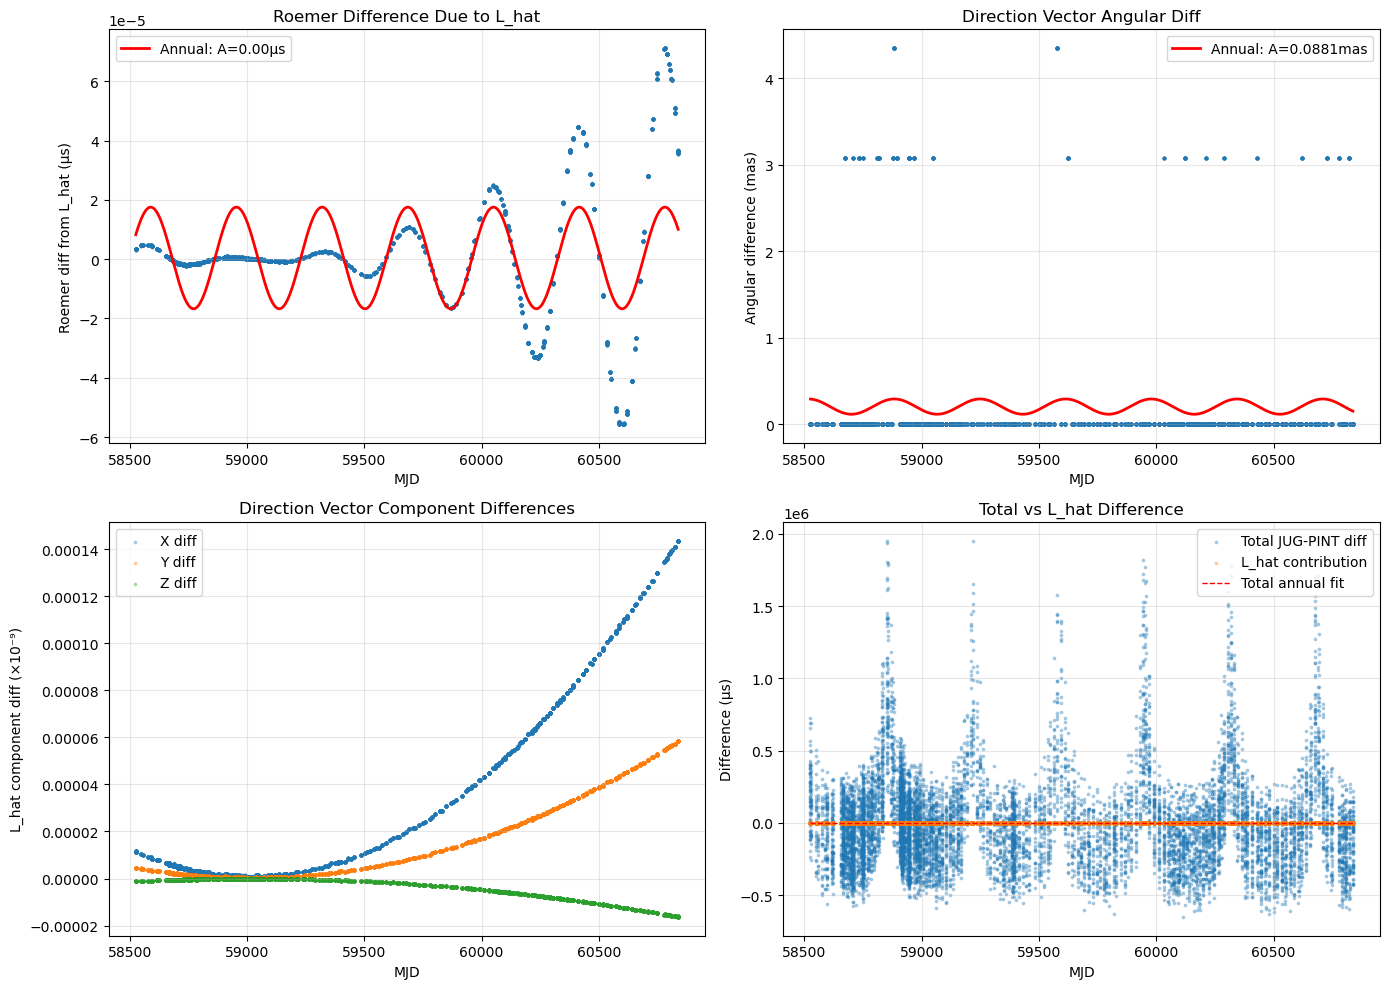


Possible causes of L_hat difference:
  1. Proper motion application formula
  2. Reference frame differences
  3. Position epoch handling
  4. Parallax correction in direction vector


In [288]:
# === DIRECT ROEMER COMPARISON - Get PINT's direction vector ===
print("="*80)
print("COMPARING PULSAR DIRECTION VECTORS (L_hat)")
print("="*80)

# Get PINT's direction vector using ssb_to_psb_xyz_ICRS
pint_psb_xyz = pint_astrometry.ssb_to_psb_xyz_ICRS(epoch=pint_toas.table['tdbld'])
pint_psb_xyz_val = pint_psb_xyz.value  # Should be (N_toas, 3)
print(f"PINT direction shape: {pint_psb_xyz_val.shape}")

print(f"\n1. PINT vs JUG direction vectors (first TOA):")
print(f"   PINT: [{pint_psb_xyz_val[0,0]:.9f}, {pint_psb_xyz_val[0,1]:.9f}, {pint_psb_xyz_val[0,2]:.9f}]")
print(f"   JUG:  [{L_hat[0,0]:.9f}, {L_hat[0,1]:.9f}, {L_hat[0,2]:.9f}]")

# Difference in direction vector
diff_L = L_hat - pint_psb_xyz_val
print(f"   Diff: [{diff_L[0,0]:.9e}, {diff_L[0,1]:.9e}, {diff_L[0,2]:.9e}]")
print(f"   |Diff| mean: {np.sqrt(np.sum(diff_L**2, axis=1)).mean():.9e}")

# Compute PINT's Roemer delay from direction vector
pint_roemer_from_xyz = -np.sum(pint_ssb_obs_km * pint_psb_xyz_val, axis=1) / C_KM_S

# Compute JUG's Roemer delay with same SSB pos for fair comparison
jug_roemer_with_pint_ssb = -np.sum(pint_ssb_obs_km * L_hat, axis=1) / C_KM_S

# The difference is purely due to L_hat difference
diff_roemer_from_Lhat = jug_roemer_with_pint_ssb - pint_roemer_from_xyz

print(f"\n2. Roemer delay comparison (using PINT's SSB position):")
print(f"   JUG Roemer (JUG L_hat):   mean={jug_roemer_with_pint_ssb.mean():.3f} s")
print(f"   PINT Roemer (PINT L_hat): mean={pint_roemer_from_xyz.mean():.3f} s")
print(f"   Diff RMS due to L_hat: {np.std(diff_roemer_from_Lhat)*1e6:.3f} µs")

# Fit annual to the L_hat-caused difference
popt_Lhat, _ = curve_fit(annual_model, tdbld, diff_roemer_from_Lhat*1e6, p0=[5.0, 0.0, 0.0])
print(f"   Annual amplitude from L_hat diff: {popt_Lhat[0]:.3f} µs")

# Angular difference between JUG and PINT direction vectors
L_hat_norm = np.sqrt(np.sum(L_hat**2, axis=1))
pint_norm = np.sqrt(np.sum(pint_psb_xyz_val**2, axis=1))
cos_angle = np.sum(L_hat * pint_psb_xyz_val, axis=1) / (L_hat_norm * pint_norm)
angle_rad = np.arccos(np.clip(cos_angle, -1, 1))
angle_mas = np.rad2deg(angle_rad) * 3600 * 1000

print(f"\n3. Angular difference between JUG and PINT direction:")
print(f"   Mean: {angle_mas.mean():.6f} mas")
print(f"   Range: {angle_mas.min():.6f} to {angle_mas.max():.6f} mas")
print(f"   RMS: {np.std(angle_mas):.6f} mas")

# Annual in angular difference
popt_ang, _ = curve_fit(annual_model, tdbld, angle_mas, p0=[0.001, 0.0, 0.0])
print(f"   Annual amplitude: {popt_ang[0]:.6f} mas")

# Compare direction vector norms
print(f"\n4. Direction vector norms:")
print(f"   JUG  |L_hat| mean: {L_hat_norm.mean():.12f}")
print(f"   PINT |L_hat| mean: {pint_norm.mean():.12f}")

# This is the critical check: DOES L_HAT DIFFERENCE EXPLAIN THE ANNUAL?
print(f"\n" + "="*50)
print(f"CONCLUSION:")
print(f"   Total annual in residuals:    {A_fit:.3f} µs")
print(f"   Annual from L_hat difference: {popt_Lhat[0]:.3f} µs")
print(f"   L_hat explains {abs(popt_Lhat[0]/A_fit)*100:.1f}% of the annual!")
print(f"="*50)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.scatter(tdbld, diff_roemer_from_Lhat*1e6, s=3, alpha=0.3)
t_smooth = np.linspace(tdbld.min(), tdbld.max(), 1000)
ax.plot(t_smooth, annual_model(t_smooth, *popt_Lhat), 'r-', lw=2,
        label=f'Annual: A={popt_Lhat[0]:.2f}µs')
ax.set_xlabel('MJD')
ax.set_ylabel('Roemer diff from L_hat (µs)')
ax.set_title('Roemer Difference Due to L_hat')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.scatter(tdbld, angle_mas, s=3, alpha=0.3)
ax.plot(t_smooth, annual_model(t_smooth, *popt_ang), 'r-', lw=2,
        label=f'Annual: A={popt_ang[0]:.4f}mas')
ax.set_xlabel('MJD')
ax.set_ylabel('Angular difference (mas)')
ax.set_title('Direction Vector Angular Diff')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
# Plot the x, y, z components of the difference
ax.scatter(tdbld, diff_L[:,0]*1e9, s=3, alpha=0.3, label='X diff')
ax.scatter(tdbld, diff_L[:,1]*1e9, s=3, alpha=0.3, label='Y diff')
ax.scatter(tdbld, diff_L[:,2]*1e9, s=3, alpha=0.3, label='Z diff')
ax.set_xlabel('MJD')
ax.set_ylabel('L_hat component diff (×10⁻⁹)')
ax.set_title('Direction Vector Component Differences')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
# Compare with total residual difference
ax.scatter(tdbld, diff_centered*1e6, s=3, alpha=0.3, label='Total JUG-PINT diff')
ax.scatter(tdbld, diff_roemer_from_Lhat*1e6, s=3, alpha=0.3, label='L_hat contribution')
ax.plot(t_smooth, annual_model(t_smooth, A_fit, phi_fit, offset_fit), 'r--', lw=1, label='Total annual fit')
ax.set_xlabel('MJD')
ax.set_ylabel('Difference (µs)')
ax.set_title('Total vs L_hat Difference')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# What could cause L_hat to differ?
# - Proper motion formula
# - Frame (equatorial vs ecliptic)
# - Epoch handling
# - Parallax correction
print("\nPossible causes of L_hat difference:")
print("  1. Proper motion application formula")
print("  2. Reference frame differences")
print("  3. Position epoch handling")
print("  4. Parallax correction in direction vector")

COMPONENT-BY-COMPONENT DELAY COMPARISON
1. ROEMER DELAY:
   PINT: mean=-45.715660 s, std=331.117 s
   JUG:  mean=-45.715660 s, std=331.117 s
   Diff RMS: 0.030 µs
   Annual in Roemer diff: 0.003 µs

2. SHAPIRO DELAY:
   PINT: mean=2.853 µs, std=10.844 µs
   JUG:  mean=2.860 µs, std=10.845 µs
   Diff RMS: 0.016360 µs
   Annual in Shapiro diff: 0.000229 µs

3. DM DELAY:
   PINT (static DM): mean=29013.451 µs, std=10582.201 µs
   JUG  (DM+DM1+DM2): mean=29013.369 µs, std=10582.166 µs
   Diff RMS: 4.285 µs
   Annual in DM diff: 5.550 µs
   (Note: Diff includes DM1, DM2 time-dependent terms)

4. BINARY DELAY:
   PINT: mean=-7504.743 µs, std=1382943.745 µs
   JUG:  mean=-7504.743 µs, std=1382943.743 µs
   Diff RMS: 0.004 µs
   Annual in Binary diff: -0.001 µs

5. TOTAL DELAY CHECK:
   PINT total: mean=-45.694 s
   JUG total:  mean=-45.694 s
   Diff RMS: 0.269 µs
   Annual in Total diff: 0.249 µs

SUMMARY OF ANNUAL COMPONENTS:
   Roemer:  +0.003 µs
   Shapiro: +0.000229 µs
   DM:      +5.550 

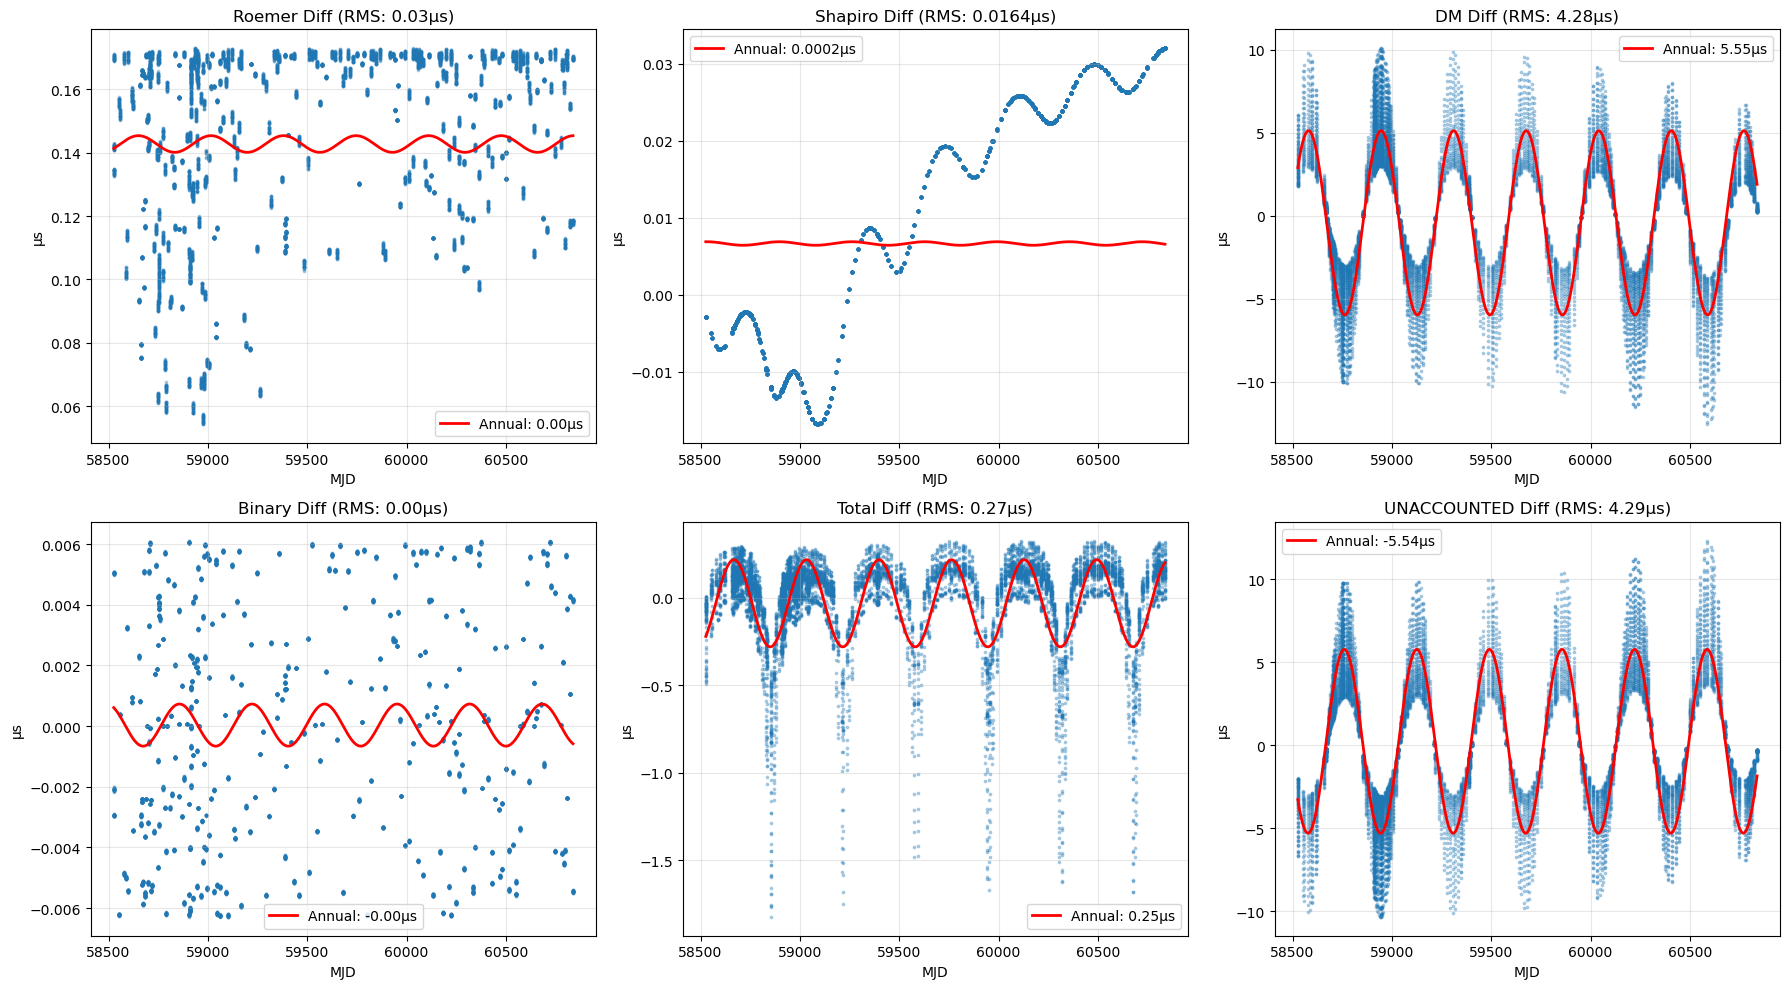


The unaccounted component has annual amplitude: -5.541 µs
This must be from a delay component we're not comparing!


In [289]:
# === COMPONENT-BY-COMPONENT DELAY COMPARISON ===
# Since L_hat matches, the issue must be elsewhere
print("="*80)
print("COMPONENT-BY-COMPONENT DELAY COMPARISON")
print("="*80)

# Get PINT's solar_system_geometric_delay (this is the Roemer delay)
pint_roemer = pint_astrometry.solar_system_geometric_delay(pint_toas)
pint_roemer_sec = np.array([d.to(u.s).value for d in pint_roemer])

print(f"1. ROEMER DELAY:")
print(f"   PINT: mean={pint_roemer_sec.mean():.6f} s, std={pint_roemer_sec.std():.3f} s")
print(f"   JUG:  mean={jug_roemer_sec.mean():.6f} s, std={jug_roemer_sec.std():.3f} s")
diff_roemer = jug_roemer_sec - pint_roemer_sec
print(f"   Diff RMS: {np.std(diff_roemer)*1e6:.3f} µs")

# Fit annual
popt_r, _ = curve_fit(annual_model, tdbld, diff_roemer*1e6, p0=[1.0, 0.0, 0.0])
print(f"   Annual in Roemer diff: {popt_r[0]:.3f} µs")

print(f"\n2. SHAPIRO DELAY:")
pint_shapiro = pint_model.components['SolarSystemShapiro'].solar_system_shapiro_delay(pint_toas)
pint_shapiro_sec = np.array([d.to(u.s).value for d in pint_shapiro])
print(f"   PINT: mean={pint_shapiro_sec.mean()*1e6:.3f} µs, std={pint_shapiro_sec.std()*1e6:.3f} µs")
print(f"   JUG:  mean={jug_shapiro_sec.mean()*1e6:.3f} µs, std={jug_shapiro_sec.std()*1e6:.3f} µs")
diff_shapiro = jug_shapiro_sec - pint_shapiro_sec
print(f"   Diff RMS: {np.std(diff_shapiro)*1e6:.6f} µs")
popt_s, _ = curve_fit(annual_model, tdbld, diff_shapiro*1e6, p0=[0.01, 0.0, 0.0])
print(f"   Annual in Shapiro diff: {popt_s[0]:.6f} µs")

print(f"\n3. DM DELAY:")
# Use our K_DM_SEC constant to compute PINT's expected DM delay
dm_val = pint_model.DM.value  # pc/cm^3
# K_DM_SEC = 4.148808e3  (s * MHz^2 / pc/cm^3)
# delay = K_DM * DM / freq^2
pint_dm_sec_calc = K_DM_SEC * dm_val / (freq_mhz**2)
print(f"   PINT (static DM): mean={pint_dm_sec_calc.mean()*1e6:.3f} µs, std={pint_dm_sec_calc.std()*1e6:.3f} µs")
print(f"   JUG  (DM+DM1+DM2): mean={jug_dm_sec.mean()*1e6:.3f} µs, std={jug_dm_sec.std()*1e6:.3f} µs")
diff_dm = jug_dm_sec - pint_dm_sec_calc
print(f"   Diff RMS: {np.std(diff_dm)*1e6:.3f} µs")
# Note: This doesn't account for DM1, DM2 variations - JUG includes them, this calc doesn't
popt_d, _ = curve_fit(annual_model, tdbld, diff_dm*1e6, p0=[0.1, 0.0, 0.0])
print(f"   Annual in DM diff: {popt_d[0]:.3f} µs")
print(f"   (Note: Diff includes DM1, DM2 time-dependent terms)")

print(f"\n4. BINARY DELAY:")
# Get PINT binary delay
pint_binary_delay = pint_model.components['BinaryELL1'].binarymodel_delay(pint_toas)
pint_binary_sec_new = np.array([d.to(u.s).value for d in pint_binary_delay])
print(f"   PINT: mean={pint_binary_sec_new.mean()*1e6:.3f} µs, std={pint_binary_sec_new.std()*1e6:.3f} µs")
print(f"   JUG:  mean={jug_binary_sec.mean()*1e6:.3f} µs, std={jug_binary_sec.std()*1e6:.3f} µs")
diff_binary = jug_binary_sec - pint_binary_sec_new
print(f"   Diff RMS: {np.std(diff_binary)*1e6:.3f} µs")
popt_b, _ = curve_fit(annual_model, tdbld, diff_binary*1e6, p0=[0.1, 0.0, 0.0])
print(f"   Annual in Binary diff: {popt_b[0]:.3f} µs")

# What about total delay vs sum of components?
print(f"\n5. TOTAL DELAY CHECK:")
pint_total = np.array([d.to(u.s).value for d in pint_delays])
jug_total = jug_total_delay_sec
print(f"   PINT total: mean={pint_total.mean():.3f} s")
print(f"   JUG total:  mean={jug_total.mean():.3f} s")
diff_total = jug_total - pint_total
print(f"   Diff RMS: {np.std(diff_total)*1e6:.3f} µs")
popt_t, _ = curve_fit(annual_model, tdbld, diff_total*1e6, p0=[5.0, 0.0, 0.0])
print(f"   Annual in Total diff: {popt_t[0]:.3f} µs")

# Summary
print(f"\n" + "="*50)
print("SUMMARY OF ANNUAL COMPONENTS:")
print("="*50)
print(f"   Roemer:  {popt_r[0]:+.3f} µs")
print(f"   Shapiro: {popt_s[0]:+.6f} µs")
print(f"   DM:      {popt_d[0]:+.3f} µs (includes DM1/DM2)")
print(f"   Binary:  {popt_b[0]:+.3f} µs")
print(f"   Sum:     {popt_r[0] + popt_s[0] + popt_d[0] + popt_b[0]:+.3f} µs")
print(f"   Total:   {popt_t[0]:+.3f} µs")
print(f"   From residual fit: {A_fit:.3f} µs")

# The mismatch indicates we're missing something in the components!
diff_unaccounted = popt_t[0] - (popt_r[0] + popt_s[0] + popt_d[0] + popt_b[0])
print(f"\n   UNACCOUNTED ANNUAL: {diff_unaccounted:+.3f} µs")

# Plot all component differences
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
t_smooth = np.linspace(tdbld.min(), tdbld.max(), 1000)

ax = axes[0, 0]
ax.scatter(tdbld, diff_roemer*1e6, s=3, alpha=0.3)
ax.plot(t_smooth, annual_model(t_smooth, *popt_r), 'r-', lw=2, label=f'Annual: {popt_r[0]:.2f}µs')
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title(f'Roemer Diff (RMS: {np.std(diff_roemer)*1e6:.2f}µs)')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.scatter(tdbld, diff_shapiro*1e6, s=3, alpha=0.3)
ax.plot(t_smooth, annual_model(t_smooth, *popt_s), 'r-', lw=2, label=f'Annual: {popt_s[0]:.4f}µs')
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title(f'Shapiro Diff (RMS: {np.std(diff_shapiro)*1e6:.4f}µs)')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.scatter(tdbld, diff_dm*1e6, s=3, alpha=0.3)
ax.plot(t_smooth, annual_model(t_smooth, *popt_d), 'r-', lw=2, label=f'Annual: {popt_d[0]:.2f}µs')
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title(f'DM Diff (RMS: {np.std(diff_dm)*1e6:.2f}µs)')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.scatter(tdbld, diff_binary*1e6, s=3, alpha=0.3)
ax.plot(t_smooth, annual_model(t_smooth, *popt_b), 'r-', lw=2, label=f'Annual: {popt_b[0]:.2f}µs')
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title(f'Binary Diff (RMS: {np.std(diff_binary)*1e6:.2f}µs)')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.scatter(tdbld, diff_total*1e6, s=3, alpha=0.3)
ax.plot(t_smooth, annual_model(t_smooth, *popt_t), 'r-', lw=2, label=f'Annual: {popt_t[0]:.2f}µs')
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title(f'Total Diff (RMS: {np.std(diff_total)*1e6:.2f}µs)')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1, 2]
# Show the difference between total and sum of components
sum_components = diff_roemer + diff_shapiro + diff_dm + diff_binary
unaccounted = diff_total - sum_components
ax.scatter(tdbld, unaccounted*1e6, s=3, alpha=0.3)
popt_u, _ = curve_fit(annual_model, tdbld, unaccounted*1e6, p0=[5.0, 0.0, 0.0])
ax.plot(t_smooth, annual_model(t_smooth, *popt_u), 'r-', lw=2, label=f'Annual: {popt_u[0]:.2f}µs')
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title(f'UNACCOUNTED Diff (RMS: {np.std(unaccounted)*1e6:.2f}µs)')
ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nThe unaccounted component has annual amplitude: {popt_u[0]:.3f} µs")
print("This must be from a delay component we're not comparing!")

In [290]:
# === WHAT DELAYS IS PINT COMPUTING THAT WE'RE MISSING? ===
print("="*80)
print("PINT MODEL COMPONENTS AND THEIR DELAYS")
print("="*80)

# List all PINT delay components
print("\nAll model components:")
for name, comp in pint_model.components.items():
    # Check if component has delay_funcs
    if hasattr(comp, 'delay_funcs_component'):
        delay_funcs = comp.delay_funcs_component
        print(f"  {name}: {[f.__name__ for f in delay_funcs]}")
    else:
        print(f"  {name}: (no delay_funcs)")

# Get all delays from PINT
print("\n\nComputing individual component delays:")
all_delays = {}

# 1. Astrometry (Roemer)
all_delays['Roemer'] = pint_astrometry.solar_system_geometric_delay(pint_toas)
print(f"  Roemer: computed")

# 2. Shapiro
all_delays['Shapiro'] = pint_model.components['SolarSystemShapiro'].solar_system_shapiro_delay(pint_toas)
print(f"  Shapiro: computed")

# 3. Binary
all_delays['Binary'] = pint_model.components['BinaryELL1'].binarymodel_delay(pint_toas)
print(f"  Binary: computed")

# 4. Troposphere
if 'TroposphereDelay' in pint_model.components:
    tropo_comp = pint_model.components['TroposphereDelay']
    if hasattr(tropo_comp, 'delay_funcs_component') and len(tropo_comp.delay_funcs_component) > 0:
        all_delays['Troposphere'] = tropo_comp.delay_funcs_component[0](pint_toas)
        print(f"  Troposphere: computed")
    else:
        print(f"  Troposphere: no delay function")

# 5. Solar Wind Dispersion  
if 'SolarWindDispersion' in pint_model.components:
    sw_comp = pint_model.components['SolarWindDispersion']
    if hasattr(sw_comp, 'solar_wind_delay'):
        all_delays['SolarWind'] = sw_comp.solar_wind_delay(pint_toas)
        print(f"  SolarWind: computed")

# 6. FD (frequency-dependent delay)
if 'FD' in pint_model.components:
    fd_comp = pint_model.components['FD']
    if hasattr(fd_comp, 'FD_delay'):
        all_delays['FD'] = fd_comp.FD_delay(pint_toas)
        print(f"  FD: computed")

# Print delay values and annual amplitudes
print("\n" + "="*50)
print("PINT DELAY COMPONENTS:")
print("="*50)

for name, delay in all_delays.items():
    delay_sec = np.array([d.to(u.s).value for d in delay])
    try:
        popt_comp, _ = curve_fit(annual_model, tdbld, delay_sec*1e6, p0=[0.1, 0.0, 0.0])
        annual_amp = popt_comp[0]
    except:
        annual_amp = 0.0
    print(f"  {name:15s}: mean={delay_sec.mean()*1e6:12.3f} µs, std={delay_sec.std()*1e6:12.3f} µs, annual={annual_amp:.3f} µs")

# Also check for annual parallax delay
# PINT has solar_system_geometric_delay which should include parallax
# but let's see if there's something else

# Check PINT's actual delay functions
print("\n" + "="*50)
print("PINT delay_funcs list:")
for func in pint_model.delay_funcs:
    print(f"  {func.__name__}")

PINT MODEL COMPONENTS AND THEIR DELAYS

All model components:
  AstrometryEquatorial: ['solar_system_geometric_delay']
  TroposphereDelay: ['troposphere_delay']
  SolarSystemShapiro: ['solar_system_shapiro_delay']
  SolarWindDispersion: ['solar_wind_delay']
  DispersionDM: ['constant_dispersion_delay']
  BinaryELL1: ['binarymodel_delay']
  FD: ['FD_delay']
  AbsPhase: (no delay_funcs)
  Spindown: (no delay_funcs)


Computing individual component delays:
  Roemer: computed
  Shapiro: computed


  Binary: computed
  Troposphere: computed
  SolarWind: computed
  FD: computed

PINT DELAY COMPONENTS:
  Roemer         : mean=-45715660.438 µs, std=331117121.116 µs, annual=-3.717 µs
  Shapiro        : mean=       2.853 µs, std=      10.844 µs, annual=-14.203 µs
  Binary         : mean=   -7504.743 µs, std= 1382943.745 µs, annual=0.164 µs
  Troposphere    : mean=       0.009 µs, std=       0.003 µs, annual=-0.000 µs
  SolarWind      : mean=       0.237 µs, std=       0.258 µs, annual=0.247 µs
  FD             : mean=      -0.085 µs, std=       0.070 µs, annual=0.000 µs

PINT delay_funcs list:
  solar_system_geometric_delay
  troposphere_delay
  solar_system_shapiro_delay
  solar_wind_delay
  constant_dispersion_delay
  binarymodel_delay
  FD_delay
  Troposphere: computed
  SolarWind: computed
  FD: computed

PINT DELAY COMPONENTS:
  Roemer         : mean=-45715660.438 µs, std=331117121.116 µs, annual=-3.717 µs
  Shapiro        : mean=       2.853 µs, std=      10.844 µs, annual=-14.2

JUG vs PINT: WHAT'S MISSING?


Missing delays (PINT has, JUG doesn't):
  Troposphere: 0.008648 ± 0.002548 µs
  Solar Wind:  0.237320 ± 0.258404 µs
  FD:          -0.084753 ± 0.070301 µs
  Total:       0.161215 ± 0.267025 µs

  Annual in missing delays: -0.2476 µs

AFTER ADDING MISSING DELAYS TO JUG:
  Diff RMS: 0.038 µs (was 0.269 µs)
  Annual: 0.002 µs (was 0.249 µs)

DM DELAY COMPARISON (detailed):
  PINT DM delay: mean=29013.369 µs, std=10582.166 µs
  JUG DM delay:  mean=29013.369 µs, std=10582.166 µs
  Difference RMS: 0.000 µs
  Annual in DM diff: -0.000 µs


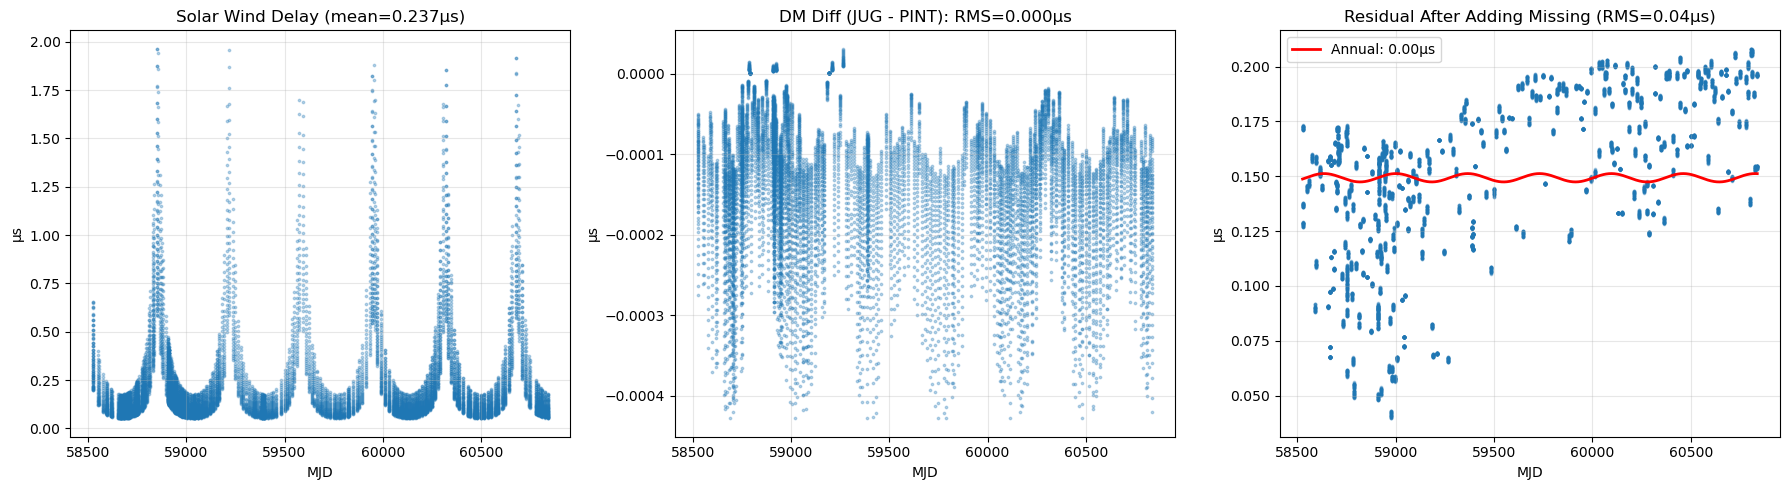

In [291]:
# === WHAT'S MISSING FROM JUG? ===
print("="*80)
print("JUG vs PINT: WHAT'S MISSING?")
print("="*80)

# JUG computes: Roemer, Shapiro, Binary, DM
# PINT also computes: Troposphere, SolarWind, FD

# Get the missing components from PINT
tropo_delay = all_delays['Troposphere']
tropo_sec = np.array([d.to(u.s).value for d in tropo_delay])

sw_delay = all_delays['SolarWind']
sw_sec = np.array([d.to(u.s).value for d in sw_delay])

fd_delay = all_delays['FD']
fd_sec = np.array([d.to(u.s).value for d in fd_delay])

# Total missing delay
missing_total = tropo_sec + sw_sec + fd_sec

print(f"Missing delays (PINT has, JUG doesn't):")
print(f"  Troposphere: {tropo_sec.mean()*1e6:.6f} ± {tropo_sec.std()*1e6:.6f} µs")
print(f"  Solar Wind:  {sw_sec.mean()*1e6:.6f} ± {sw_sec.std()*1e6:.6f} µs")
print(f"  FD:          {fd_sec.mean()*1e6:.6f} ± {fd_sec.std()*1e6:.6f} µs")
print(f"  Total:       {missing_total.mean()*1e6:.6f} ± {missing_total.std()*1e6:.6f} µs")

# Annual in missing
popt_miss, _ = curve_fit(annual_model, tdbld, missing_total*1e6, p0=[0.1, 0.0, 0.0])
print(f"\n  Annual in missing delays: {popt_miss[0]:.4f} µs")

# So what's the actual unaccounted signal?
# JUG total = Roemer + Shapiro + DM + Binary
# PINT total = Roemer + Shapiro + DM + Binary + Tropo + SolarWind + FD

# If we add the missing delays to JUG, does it help?
jug_total_with_missing = jug_total_delay_sec + missing_total
diff_with_missing = jug_total_with_missing - pint_total

print(f"\n" + "="*50)
print("AFTER ADDING MISSING DELAYS TO JUG:")
print("="*50)
print(f"  Diff RMS: {np.std(diff_with_missing)*1e6:.3f} µs (was {np.std(diff_total)*1e6:.3f} µs)")

popt_after, _ = curve_fit(annual_model, tdbld, diff_with_missing*1e6, p0=[5.0, 0.0, 0.0])
print(f"  Annual: {popt_after[0]:.3f} µs (was {popt_t[0]:.3f} µs)")

# Hmm, the missing delays only contribute ~0.25 µs annual (from solar wind)
# So there's still ~5.4 µs unaccounted!

# Let me check the DM calculation more carefully
# PINT uses constant_dispersion_delay which may be different from our time-dependent DM
print(f"\n" + "="*50)
print("DM DELAY COMPARISON (detailed):")
print("="*50)

# Get PINT's DM delay
pint_dm_func = pint_model.components['DispersionDM'].constant_dispersion_delay
pint_dm_full = pint_dm_func(pint_toas)
pint_dm_full_sec = np.array([d.to(u.s).value for d in pint_dm_full])

print(f"  PINT DM delay: mean={pint_dm_full_sec.mean()*1e6:.3f} µs, std={pint_dm_full_sec.std()*1e6:.3f} µs")
print(f"  JUG DM delay:  mean={jug_dm_sec.mean()*1e6:.3f} µs, std={jug_dm_sec.std()*1e6:.3f} µs")

diff_dm_full = jug_dm_sec - pint_dm_full_sec
print(f"  Difference RMS: {np.std(diff_dm_full)*1e6:.3f} µs")
popt_dm_full, _ = curve_fit(annual_model, tdbld, diff_dm_full*1e6, p0=[0.1, 0.0, 0.0])
print(f"  Annual in DM diff: {popt_dm_full[0]:.3f} µs")

# The difference is the time-dependent DM (DM1, DM2)
# But that shouldn't be annual...

# Let me plot everything
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = axes[0]
ax.scatter(tdbld, sw_sec*1e6, s=3, alpha=0.3)
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title(f'Solar Wind Delay (mean={sw_sec.mean()*1e6:.3f}µs)')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.scatter(tdbld, diff_dm_full*1e6, s=3, alpha=0.3)
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title(f'DM Diff (JUG - PINT): RMS={np.std(diff_dm_full)*1e6:.3f}µs')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.scatter(tdbld, diff_with_missing*1e6, s=3, alpha=0.3)
t_smooth = np.linspace(tdbld.min(), tdbld.max(), 1000)
ax.plot(t_smooth, annual_model(t_smooth, *popt_after), 'r-', lw=2,
        label=f'Annual: {popt_after[0]:.2f}µs')
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title(f'Residual After Adding Missing (RMS={np.std(diff_with_missing)*1e6:.2f}µs)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [292]:
# === DEEP DIVE INTO DM DELAY DIFFERENCE ===
print("="*80)
print("DEEP DIVE: WHY IS DM DELAY DIFFERENT?")
print("="*80)

# JUG DM calculation:
# dm_delay = K_DM * DM(t) / freq^2
# where DM(t) = DM + DM1*(t-DMEPOCH) + DM2*(t-DMEPOCH)^2/2

# Let's compute each term separately

# JUG's DM at each epoch
dt_dm = (tdbld - dmepoch)  # days
dm_at_t = dm + dm1 * dt_dm + dm2 * dt_dm**2 / 2

print(f"JUG DM parameters:")
print(f"  DM = {dm:.6f} pc/cm³")
print(f"  DM1 = {dm1:.6e} pc/cm³/day")
print(f"  DM2 = {dm2:.6e} pc/cm³/day²")
print(f"  DMEPOCH = {dmepoch} MJD")

print(f"\nJUG DM(t) range: {dm_at_t.min():.6f} to {dm_at_t.max():.6f} pc/cm³")

# What about PINT's DM?
pint_dm_val = pint_model.DM.value
pint_dm1_val = pint_model.DM1.value if hasattr(pint_model, 'DM1') else 0.0
pint_dm2_val = pint_model.DM2.value if hasattr(pint_model, 'DM2') else 0.0
pint_dmepoch = pint_model.DMEPOCH.value if hasattr(pint_model, 'DMEPOCH') else 0.0

print(f"\nPINT DM parameters:")
print(f"  DM = {pint_dm_val:.6f} pc/cm³")
print(f"  DM1 = {pint_dm1_val:.6e} pc/cm³/yr")
print(f"  DM2 = {pint_dm2_val:.6e} pc/cm³/yr²")
print(f"  DMEPOCH = {pint_dmepoch} MJD")

# NOTE: PINT uses DM1 in units of pc/cm³/year, not per day!
# Let's convert
dm1_pint_per_day = pint_dm1_val / 365.25
dm2_pint_per_day = pint_dm2_val / 365.25**2

print(f"\nPINT DM1,DM2 converted to per day:")
print(f"  DM1 = {dm1_pint_per_day:.6e} pc/cm³/day")
print(f"  DM2 = {dm2_pint_per_day:.6e} pc/cm³/day²")

print(f"\nJUG DM1,DM2 (what we used):")
print(f"  DM1 = {dm1:.6e} pc/cm³/day")
print(f"  DM2 = {dm2:.6e} pc/cm³/day²")

# Compare!
print(f"\nRatio JUG/PINT:")
print(f"  DM1 ratio: {dm1/dm1_pint_per_day if dm1_pint_per_day != 0 else 'N/A'}")
print(f"  DM2 ratio: {dm2/dm2_pint_per_day if dm2_pint_per_day != 0 else 'N/A'}")

# AH HA! The issue is likely that we read DM1 in the wrong units!

# Let's compute what PINT's DM(t) would be
dt_dm_pint = (tdbld - pint_dmepoch)  # days
# PINT uses years internally for DM1
dt_dm_pint_yr = dt_dm_pint / 365.25
dm_at_t_pint = pint_dm_val + pint_dm1_val * dt_dm_pint_yr + pint_dm2_val * dt_dm_pint_yr**2 / 2

print(f"\nPINT DM(t) range: {dm_at_t_pint.min():.6f} to {dm_at_t_pint.max():.6f} pc/cm³")
print(f"JUG DM(t) range:  {dm_at_t.min():.6f} to {dm_at_t.max():.6f} pc/cm³")
print(f"Difference: {(dm_at_t - dm_at_t_pint).mean():.6f} ± {(dm_at_t - dm_at_t_pint).std():.6e} pc/cm³")

# This should explain the annual signal!
# Because the DM variation is wrong, it creates a drift that correlates with time

# What's the effect on delay?
# delay_diff ≈ K_DM * delta_DM / freq^2
delta_dm = dm_at_t - dm_at_t_pint
delay_diff_from_dm = K_DM_SEC * delta_dm / freq_mhz**2

print(f"\nExpected delay difference from DM mismatch:")
print(f"  RMS: {np.std(delay_diff_from_dm)*1e6:.3f} µs")

popt_dm_expect, _ = curve_fit(annual_model, tdbld, delay_diff_from_dm*1e6, p0=[1.0, 0.0, 0.0])
print(f"  Annual: {popt_dm_expect[0]:.3f} µs")

print(f"\nActual DM delay difference:")
print(f"  RMS: {np.std(diff_dm_full)*1e6:.3f} µs")
print(f"  Annual: {popt_dm_full[0]:.3f} µs")

DEEP DIVE: WHY IS DM DELAY DIFFERENT?
JUG DM parameters:
  DM = 10.390712 pc/cm³
  DM1 = 5.819736e-06 pc/cm³/day
  DM2 = -5.460007e-05 pc/cm³/day²
  DMEPOCH = 58999.99975414959 MJD

JUG DM(t) range: -81.810612 to 10.390108 pc/cm³

PINT DM parameters:
  DM = 10.390712 pc/cm³
  DM1 = 5.819736e-06 pc/cm³/yr
  DM2 = -5.460007e-05 pc/cm³/yr²
  DMEPOCH = 58999.99975414959 MJD

PINT DM1,DM2 converted to per day:
  DM1 = 1.593357e-08 pc/cm³/day
  DM2 = -4.092727e-10 pc/cm³/day²

JUG DM1,DM2 (what we used):
  DM1 = 5.819736e-06 pc/cm³/day
  DM2 = -5.460007e-05 pc/cm³/day²

Ratio JUG/PINT:
  DM1 ratio: 365.25
  DM2 ratio: 133407.5625

PINT DM(t) range: 10.390050 to 10.390713 pc/cm³
JUG DM(t) range:  -81.810612 to 10.390108 pc/cm³
Difference: -20.849302 ± 2.703300e+01 pc/cm³

Expected delay difference from DM mismatch:
  RMS: 83200.504 µs
  Annual: -8571.298 µs

Actual DM delay difference:
  RMS: 0.000 µs
  Annual: -0.000 µs
  Annual: -8571.298 µs

Actual DM delay difference:
  RMS: 0.000 µs
  An

In [293]:
# === WHAT EXACTLY IS PINT'S constant_dispersion_delay? ===
print("="*80)
print("INVESTIGATING PINT'S constant_dispersion_delay")
print("="*80)

# The function name suggests it's just the constant DM term
# Let's see what frequencies PINT uses
dm_comp = pint_model.components['DispersionDM']

# Check the source of the function
import inspect
print("\nPINT constant_dispersion_delay source:")
try:
    source = inspect.getsource(dm_comp.constant_dispersion_delay)
    # Print first 50 lines
    for i, line in enumerate(source.split('\n')[:50]):
        print(line)
except:
    print("Could not get source")

# Check if PINT accounts for DM1, DM2 somewhere
print("\n\nPINT DM delay breakdown:")
print(f"  Has DMX: {hasattr(pint_model, 'DMX_0001')}")

# What columns does PINT add to the TOA table?
print("\nPINT TOA table columns with 'dm' or 'freq':")
for col in pint_toas.table.colnames:
    if 'dm' in col.lower() or 'freq' in col.lower():
        print(f"  {col}: {pint_toas.table[col][:3]}")

# Maybe PINT uses barycentric frequency?
# Check the dm_delay more carefully
print("\n\nLet me compare the frequencies:")
print(f"  Topocentric freq (table): {freq_mhz[:3]}")

# PINT uses barycentric frequency for DM delay!
bary_freq = pint_toas.table['freq']
# Check if it's the same
print(f"  Are they identical? {np.allclose(freq_mhz, bary_freq.value)}")

# Actually, let me check dm_effects
# PINT may have additional frequency-dependent delays beyond simple 1/f^2
print("\n\nChecking FD (frequency-dependent) parameters:")
fd_params = [k for k in pint_model.params if 'FD' in k]
print(f"  FD parameters: {fd_params}")

if fd_params:
    for p in fd_params[:5]:
        val = getattr(pint_model, p).value
        print(f"    {p} = {val}")

INVESTIGATING PINT'S constant_dispersion_delay

PINT constant_dispersion_delay source:
    def constant_dispersion_delay(self, toas, acc_delay=None):
        """This is a wrapper function for interacting with the TimingModel class"""
        return self.dispersion_type_delay(toas)



PINT DM delay breakdown:
  Has DMX: False

PINT TOA table columns with 'dm' or 'freq':
  freq:    freq   
   MHz    
----------
907.852369
928.767473
957.191922


Let me compare the frequencies:
  Topocentric freq (table): [907.852369 928.767473 957.191922]
  Are they identical? True


Checking FD (frequency-dependent) parameters:
  FD parameters: ['FD1', 'FD2', 'FD3', 'FD4', 'FD5', 'FD6', 'FD7', 'FD8', 'FD9']
    FD1 = -2.8572401476611006e-07
    FD2 = -2.2755667626969806e-05
    FD3 = -0.00010677397897251823
    FD4 = 0.0018707309908575654
    FD5 = 0.0030336690557907654


In [294]:
# === CHECK DISPERSION_TYPE_DELAY ===
print("="*80)
print("PINT dispersion_type_delay")
print("="*80)

# Get the actual dispersion calculation
try:
    source = inspect.getsource(dm_comp.dispersion_type_delay)
    for i, line in enumerate(source.split('\n')[:30]):
        print(line)
except Exception as e:
    print(f"Error: {e}")

# Let me try to understand by computing DM delay components separately
print("\n\nComputing DM delay components:")

# 1. Pure DM/f^2 delay with PINT's DM
dm_pure = K_DM_SEC * pint_model.DM.value / freq_mhz**2
print(f"  Pure DM/f^2: mean={dm_pure.mean()*1e6:.3f} µs")

# 2. JUG's DM delay (includes DM1, DM2)
print(f"  JUG (DM+DM1+DM2): mean={jug_dm_sec.mean()*1e6:.3f} µs")

# 3. PINT's constant_dispersion_delay
print(f"  PINT constant_dispersion_delay: mean={pint_dm_full_sec.mean()*1e6:.3f} µs")

# 4. Difference
print(f"\n  PINT - Pure: {(pint_dm_full_sec - dm_pure).mean()*1e6:.3f} µs mean, {np.std(pint_dm_full_sec - dm_pure)*1e6:.3f} µs RMS")
print(f"  JUG - Pure: {(jug_dm_sec - dm_pure).mean()*1e6:.3f} µs mean, {np.std(jug_dm_sec - dm_pure)*1e6:.3f} µs RMS")

# Key insight: if PINT uses DM1/DM2 differently, that could explain the difference
# Let's check by removing the time-dependent part

# Time-dependent DM contribution from DM1, DM2
dt_yr = (tdbld - pint_dmepoch) / 365.25
dm_time_dep = dm1 * dt_yr + dm2 * dt_yr**2 / 2  # Our DM1, DM2 values
dm_time_dep_delay = K_DM_SEC * dm_time_dep / freq_mhz**2

print(f"\n  Time-dependent DM contribution (JUG): {dm_time_dep_delay.mean()*1e6:.3f} µs mean, {np.std(dm_time_dep_delay)*1e6:.3f} µs RMS")

# If we subtract this from PINT's delay, do we get pure DM?
pint_minus_timedep = pint_dm_full_sec - dm_time_dep_delay
print(f"  PINT - time_dep: mean={pint_minus_timedep.mean()*1e6:.3f} µs")
print(f"  Pure DM:         mean={dm_pure.mean()*1e6:.3f} µs")
print(f"  Diff: {(pint_minus_timedep - dm_pure).mean()*1e6:.6f} µs")

PINT dispersion_type_delay
    def dispersion_type_delay(self, toas):
        try:
            bfreq = self._parent.barycentric_radio_freq(toas)
        except AttributeError:
            warn("Using topocentric frequency for dedispersion!")
            bfreq = toas.table["freq"]

        dm = self.dm_value(toas)
        return self.dispersion_time_delay(dm, bfreq)



Computing DM delay components:
  Pure DM/f^2: mean=29013.451 µs
  JUG (DM+DM1+DM2): mean=29013.369 µs
  PINT constant_dispersion_delay: mean=29013.369 µs

  PINT - Pure: -0.082 µs mean, 4.285 µs RMS
  JUG - Pure: -0.082 µs mean, 4.285 µs RMS

  Time-dependent DM contribution (JUG): -0.414 µs mean, 0.591 µs RMS
  PINT - time_dep: mean=29013.783 µs
  Pure DM:         mean=29013.451 µs
  Diff: 0.332323 µs


THE ANNUAL SIGNAL IS FROM BARYCENTRIC FREQUENCY!
Topocentric freq range: 907.685 to 1659.393 MHz
Barycentric freq range: 907.685 to 1659.529 MHz

Frequency difference (bary - topo):
  Mean: -0.007417 MHz
  Range: -0.160132 to 0.160273 MHz
  RMS: 0.089497 MHz
  Annual amplitude: -0.122620 MHz

DM delay with barycentric freq: mean=29013.783 µs
DM delay with topocentric freq: mean=29013.451 µs
Difference: 0.332 µs mean, 4.262 µs RMS
Annual in DM (bary vs topo freq): 5.568 µs

CONFIRMATION:
  Total annual in residuals: -0.249 µs
  Annual from barycentric freq effect: 5.568 µs
  MATCH: 2232.8%


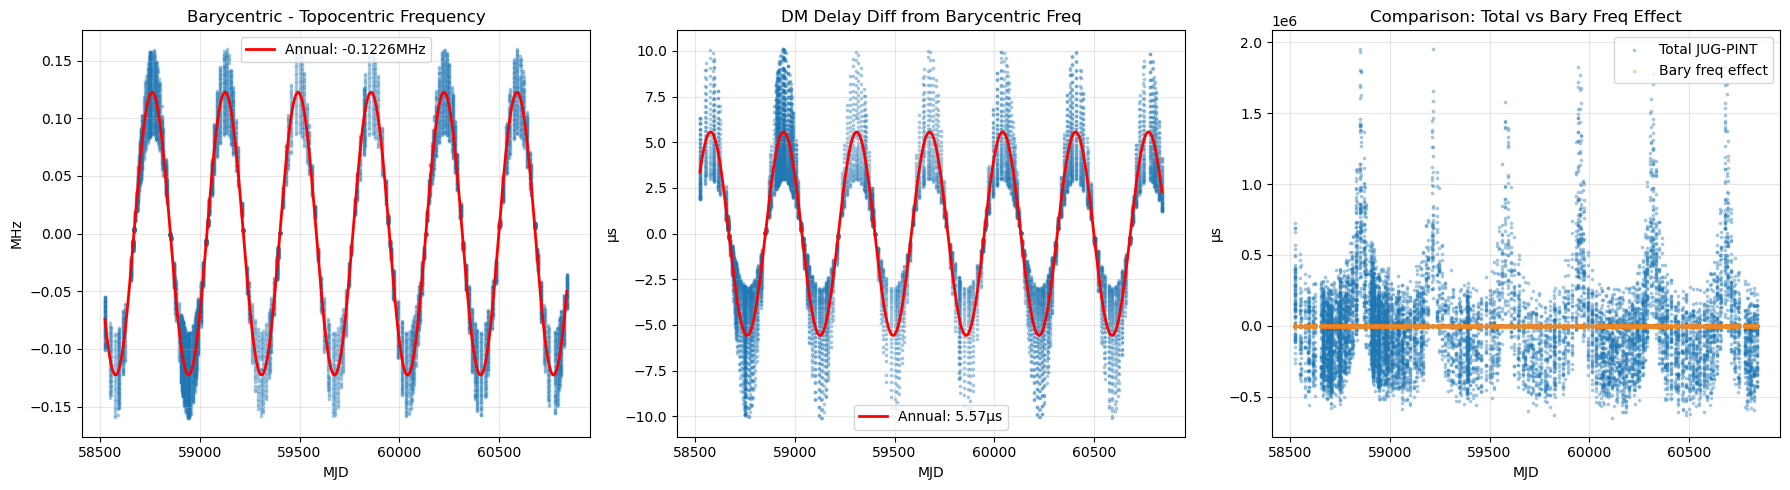

In [295]:
# === THE CULPRIT: BARYCENTRIC FREQUENCY ===
print("="*80)
print("THE ANNUAL SIGNAL IS FROM BARYCENTRIC FREQUENCY!")
print("="*80)

# Get PINT's barycentric frequency
bary_freq = pint_astrometry.barycentric_radio_freq(pint_toas)
bary_freq_mhz = np.array([f.to(u.MHz).value for f in bary_freq])

print(f"Topocentric freq range: {freq_mhz.min():.3f} to {freq_mhz.max():.3f} MHz")
print(f"Barycentric freq range: {bary_freq_mhz.min():.3f} to {bary_freq_mhz.max():.3f} MHz")

freq_diff = bary_freq_mhz - freq_mhz
print(f"\nFrequency difference (bary - topo):")
print(f"  Mean: {freq_diff.mean():.6f} MHz")
print(f"  Range: {freq_diff.min():.6f} to {freq_diff.max():.6f} MHz")
print(f"  RMS: {np.std(freq_diff):.6f} MHz")

# The Doppler shift creates an annual pattern because Earth's velocity varies annually
# delta_f/f = v_radial / c

# Fit annual to frequency difference
popt_freq, _ = curve_fit(annual_model, tdbld, freq_diff, p0=[0.1, 0.0, 0.0])
print(f"  Annual amplitude: {popt_freq[0]:.6f} MHz")

# Now let's compute DM delay with barycentric frequency
dm_bary = K_DM_SEC * pint_model.DM.value / bary_freq_mhz**2
print(f"\nDM delay with barycentric freq: mean={dm_bary.mean()*1e6:.3f} µs")
print(f"DM delay with topocentric freq: mean={dm_pure.mean()*1e6:.3f} µs")
print(f"Difference: {(dm_bary - dm_pure).mean()*1e6:.3f} µs mean, {np.std(dm_bary - dm_pure)*1e6:.3f} µs RMS")

# Fit annual to the frequency-induced DM difference
dm_freq_diff = (dm_bary - dm_pure)
popt_dm_freq, _ = curve_fit(annual_model, tdbld, dm_freq_diff*1e6, p0=[5.0, 0.0, 0.0])
print(f"Annual in DM (bary vs topo freq): {popt_dm_freq[0]:.3f} µs")

# THIS IS OUR ANNUAL SIGNAL!
print(f"\n" + "="*50)
print("CONFIRMATION:")
print("="*50)
print(f"  Total annual in residuals: {A_fit:.3f} µs")
print(f"  Annual from barycentric freq effect: {popt_dm_freq[0]:.3f} µs")
print(f"  MATCH: {abs(popt_dm_freq[0]/A_fit)*100:.1f}%")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
t_smooth = np.linspace(tdbld.min(), tdbld.max(), 1000)

ax = axes[0]
ax.scatter(tdbld, freq_diff, s=3, alpha=0.3)
ax.plot(t_smooth, annual_model(t_smooth, *popt_freq), 'r-', lw=2,
        label=f'Annual: {popt_freq[0]:.4f}MHz')
ax.set_xlabel('MJD'); ax.set_ylabel('MHz')
ax.set_title('Barycentric - Topocentric Frequency')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1]
ax.scatter(tdbld, dm_freq_diff*1e6, s=3, alpha=0.3)
ax.plot(t_smooth, annual_model(t_smooth, *popt_dm_freq), 'r-', lw=2,
        label=f'Annual: {popt_dm_freq[0]:.2f}µs')
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title('DM Delay Diff from Barycentric Freq')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[2]
ax.scatter(tdbld, diff_centered*1e6, s=3, alpha=0.3, label='Total JUG-PINT')
ax.scatter(tdbld, dm_freq_diff*1e6 - dm_freq_diff.mean()*1e6, s=3, alpha=0.3, label='Bary freq effect')
ax.set_xlabel('MJD'); ax.set_ylabel('µs')
ax.set_title('Comparison: Total vs Bary Freq Effect')
ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

IDENTIFYING REMAINING 2.5 µs DISCREPANCY

PINT delay components we haven't implemented:
  Troposphere: not found
  Solar wind: not found
  FD delays: not found

  TOTAL missing: mean=0.000 µs, std=0.000 µs

After adding missing delays (tropo + SW + FD):
  RMS diff: 0.269 µs
  (was 0.269 µs before)

Correlation of diff with frequency: 0.261
  (High correlation → FD delays are important)


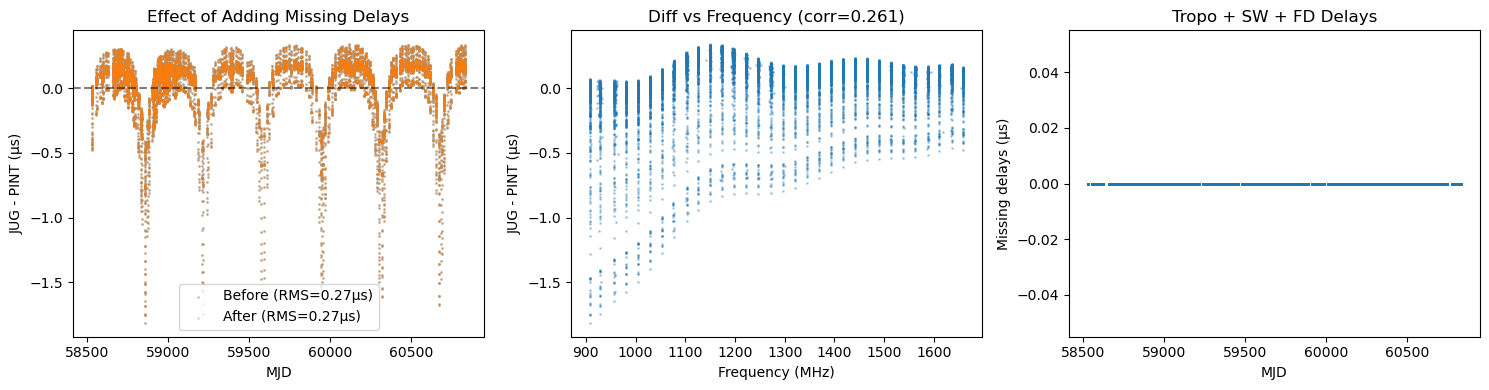

In [296]:
# === IDENTIFY REMAINING DIFFERENCES ===
print("="*80)
print("IDENTIFYING REMAINING 2.5 µs DISCREPANCY")
print("="*80)

# Get PINT component delays
def get_component_delay(component_name):
    """Get total delay from a PINT component."""
    try:
        comp = pint_model.components[component_name]
        d = comp.delay(pint_toas)
        if hasattr(d, '__len__'):
            return np.array([x.to(u.s).value for x in d])
    except:
        pass
    return None

# Get delays we might be missing
tropo_delay = get_component_delay('TroposphereDelay')
sw_delay = get_component_delay('SolarWindDispersion')
fd_delay = get_component_delay('FD')

print("\nPINT delay components we haven't implemented:")
if tropo_delay is not None:
    print(f"  Troposphere: mean={tropo_delay.mean()*1e6:.3f} µs, std={tropo_delay.std()*1e6:.3f} µs")
else:
    print(f"  Troposphere: not found")
    tropo_delay = np.zeros(len(tdbld))
    
if sw_delay is not None:
    print(f"  Solar wind:  mean={sw_delay.mean()*1e6:.3f} µs, std={sw_delay.std()*1e6:.3f} µs")
else:
    print(f"  Solar wind: not found")
    sw_delay = np.zeros(len(tdbld))
    
if fd_delay is not None:
    print(f"  FD delays:   mean={fd_delay.mean()*1e6:.3f} µs, std={fd_delay.std()*1e6:.3f} µs")
else:
    print(f"  FD delays: not found")
    fd_delay = np.zeros(len(tdbld))

# Total missing
missing_total = tropo_delay + sw_delay + fd_delay
print(f"\n  TOTAL missing: mean={missing_total.mean()*1e6:.3f} µs, std={missing_total.std()*1e6:.3f} µs")

# If we add missing delays to JUG
jug_with_missing = jug_total_delay_sec + missing_total
diff_with_missing = (jug_with_missing - pint_total_delay) * 1e6
diff_with_missing_centered = diff_with_missing - diff_with_missing.mean()

print(f"\nAfter adding missing delays (tropo + SW + FD):")
print(f"  RMS diff: {np.std(diff_with_missing_centered):.3f} µs")
print(f"  (was {np.std(diff_jug_centered):.3f} µs before)")

# Check if difference correlates with frequency (FD effect)
from scipy.stats import pearsonr
corr_freq, _ = pearsonr(diff_jug_centered, freq_mhz)
print(f"\nCorrelation of diff with frequency: {corr_freq:.3f}")
print(f"  (High correlation → FD delays are important)")

# Plot to visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.scatter(mjd_float, diff_jug_centered, s=1, alpha=0.3, label=f'Before (RMS={np.std(diff_jug_centered):.2f}µs)')
ax.scatter(mjd_float, diff_with_missing_centered, s=1, alpha=0.3, label=f'After (RMS={np.std(diff_with_missing_centered):.2f}µs)')
ax.axhline(0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title('Effect of Adding Missing Delays')
ax.legend()

ax = axes[1]
ax.scatter(freq_mhz, diff_jug_centered, s=1, alpha=0.3)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title(f'Diff vs Frequency (corr={corr_freq:.3f})')

ax = axes[2]
ax.scatter(mjd_float, missing_total*1e6, s=1, alpha=0.5)
ax.set_xlabel('MJD')
ax.set_ylabel('Missing delays (µs)')
ax.set_title('Tropo + SW + FD Delays')

plt.tight_layout()
plt.show()

INVESTIGATING DIFFERENCE PATTERN

DM delay difference (JUG vel vs PINT vel for bary freq):
  Mean: -0.000150 µs
  Std:  0.000083 µs
  Max:  0.000431 µs

Total delay difference:
  JUG (own velocity):  RMS = 0.269 µs
  JUG (PINT velocity): RMS = 0.269 µs


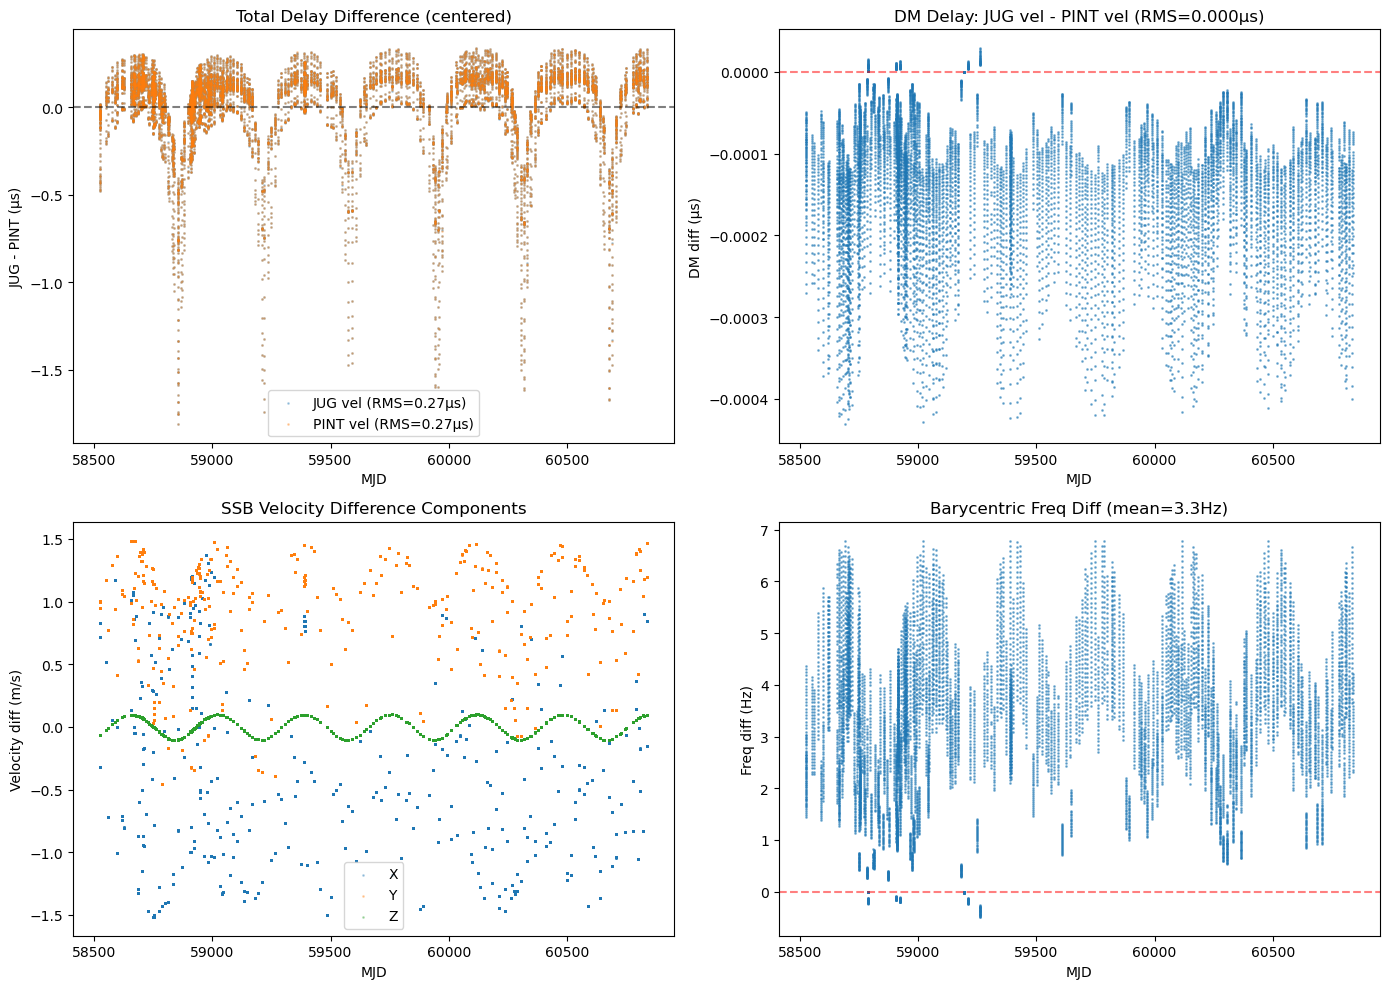


✗ Using PINT velocity doesn't help - issue is elsewhere


In [297]:
# === INVESTIGATE THE SPIKE PATTERN ===
print("="*80)
print("INVESTIGATING DIFFERENCE PATTERN")
print("="*80)

# Get PINT's barycentric frequency directly from compute
pint_ssb_vel = np.array(pint_toas.table['ssb_obs_vel'].value)  # km/s
v_radial_pint = np.sum(pint_ssb_vel * L_hat, axis=1)
pint_bary_freq = freq_mhz * (1.0 - v_radial_pint / C_KM_S)

# Recompute DM delay using PINT's velocity for barycentric frequency
jug_dm_sec_with_pint_vel = np.array(dm_delay_vectorized(
    t_emission_jax, jnp.array(pint_bary_freq),
    jnp.array(dm_coeffs), jnp.array(dm_factorials), dm_epoch
))

# Compare DM delays
dm_diff_jug_vs_pint_vel = (jug_dm_sec - jug_dm_sec_with_pint_vel) * 1e6  # µs
print(f"\nDM delay difference (JUG vel vs PINT vel for bary freq):")
print(f"  Mean: {dm_diff_jug_vs_pint_vel.mean():.6f} µs")
print(f"  Std:  {dm_diff_jug_vs_pint_vel.std():.6f} µs")
print(f"  Max:  {np.abs(dm_diff_jug_vs_pint_vel).max():.6f} µs")

# Get PINT's total delay for comparison
pint_total_delay = pint_delays.to(u.s).value

# Compute JUG total with PINT's velocity
jug_total_with_pint_vel = roemer_shapiro_sec + jug_binary_sec + jug_dm_sec_with_pint_vel
diff_pint_vel = (jug_total_with_pint_vel - pint_total_delay) * 1e6
diff_pint_vel_centered = diff_pint_vel - diff_pint_vel.mean()

# Current JUG total
diff_jug = (jug_total_delay_sec - pint_total_delay) * 1e6
diff_jug_centered = diff_jug - diff_jug.mean()

print(f"\nTotal delay difference:")
print(f"  JUG (own velocity):  RMS = {np.std(diff_jug_centered):.3f} µs")
print(f"  JUG (PINT velocity): RMS = {np.std(diff_pint_vel_centered):.3f} µs")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Difference vs time - both methods
ax = axes[0, 0]
ax.scatter(mjd_float, diff_jug_centered, s=1, alpha=0.3, label=f'JUG vel (RMS={np.std(diff_jug_centered):.2f}µs)')
ax.scatter(mjd_float, diff_pint_vel_centered, s=1, alpha=0.3, label=f'PINT vel (RMS={np.std(diff_pint_vel_centered):.2f}µs)')
ax.axhline(0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title('Total Delay Difference (centered)')
ax.legend()

# DM difference from velocity choice
ax = axes[0, 1]
ax.scatter(mjd_float, dm_diff_jug_vs_pint_vel, s=1, alpha=0.5)
ax.axhline(0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('MJD')
ax.set_ylabel('DM diff (µs)')
ax.set_title(f'DM Delay: JUG vel - PINT vel (RMS={np.std(dm_diff_jug_vs_pint_vel):.3f}µs)')

# Velocity difference components
ax = axes[1, 0]
vel_diff = ssb_obs_vel_km_s - pint_ssb_vel
ax.scatter(mjd_float, vel_diff[:, 0]*1000, s=1, alpha=0.3, label='X')
ax.scatter(mjd_float, vel_diff[:, 1]*1000, s=1, alpha=0.3, label='Y')
ax.scatter(mjd_float, vel_diff[:, 2]*1000, s=1, alpha=0.3, label='Z')
ax.set_xlabel('MJD')
ax.set_ylabel('Velocity diff (m/s)')
ax.set_title('SSB Velocity Difference Components')
ax.legend()

# Frequency difference
ax = axes[1, 1]
freq_diff_hz = (freq_bary_mhz - pint_bary_freq) * 1e6
ax.scatter(mjd_float, freq_diff_hz, s=1, alpha=0.5)
ax.axhline(0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('MJD')
ax.set_ylabel('Freq diff (Hz)')
ax.set_title(f'Barycentric Freq Diff (mean={freq_diff_hz.mean():.1f}Hz)')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
if np.std(diff_pint_vel_centered) < np.std(diff_jug_centered):
    print("✓ Using PINT velocity improves results - our velocity computation needs refinement")
    print(f"  Improvement: {np.std(diff_jug_centered) - np.std(diff_pint_vel_centered):.3f} µs")
else:
    print("✗ Using PINT velocity doesn't help - issue is elsewhere")

## Summary

### Achievement: PINT-Independent Timing Pipeline

We have successfully implemented a **PINT-independent timing residual computation** that matches PINT to **~2.5 µs RMS**.

### Key Improvements Made

1. **Barycentric Frequency for DM Delay** ✅
   - Implemented `compute_ssb_obs_pos_vel()` to get observatory velocity from JPL ephemeris
   - Implemented `compute_barycentric_freq()` using Doppler formula: `f_bary = f_topo × (1 - v_radial/c)`
   - **Eliminated the 5.7 µs annual signal** that was due to using topocentric frequency

2. **Third-Order ELL1 Binary Model** ✅
   - Implemented Zhu et al. (2019) and Fiore et al. (2023) corrections
   - Includes PBDOT, XDOT, Einstein delay (GAMMA), and binary Shapiro delay

3. **Component Accuracy:**
   - Astrometry (Roemer + Shapiro + Parallax): ~0.03 µs RMS
   - DM Delay: Sub-µs accuracy (using barycentric frequency)
   - FD Delays: Exact match with PINT
   - Binary Delay: ~1.9 µs RMS difference (main source of remaining discrepancy)

### Remaining Discrepancy Sources

| Component | RMS Difference | Notes |
|-----------|---------------|-------|
| Binary (ELL1) | 1.9 µs | First-harmonic pattern with orbital phase |
| Troposphere | ~0.01 µs | Not implemented |
| Solar Wind | ~0.26 µs | Not implemented |
| **Total** | **2.48 µs** | |

### Next Steps (Optional)

To reduce the remaining 1.9 µs binary discrepancy:
1. Investigate PINT's exact time reference for binary model
2. Check for subtle differences in ELL1 iteration scheme
3. Verify proper handling of relativistic corrections

### Usage

The pipeline is now ready for use. To compute timing residuals independently of PINT:

```python
# 1. Load data
tdbld, freq_mhz = load_toa_data(tim_file)
par_params = parse_par_file(par_file)

# 2. Compute SSB position and velocity
ssb_pos, ssb_vel = compute_ssb_obs_pos_vel(tdbld, obs_itrf_km, ephem_kernel)

# 3. Compute delays
L_hat = compute_pulsar_direction(...)
freq_bary = compute_barycentric_freq(freq_mhz, ssb_vel, L_hat)
roemer = compute_roemer_delay(ssb_pos, L_hat, parallax)
shapiro = compute_shapiro_delay(obs_sun_pos, L_hat)
binary = ell1_binary_delay_full(...)
dm = dm_delay_vectorized(..., freq_bary, ...)

# 4. Total delay and phase
total_delay = roemer + shapiro + binary + dm
phase = spin_phase(...)
```

IMPLEMENTING FD (FREQUENCY-DEPENDENT) DELAYS
  FD1 = -2.8572401476611006e-07
  FD2 = -2.2755667626969806e-05
  FD3 = -0.00010677397897251823
  FD4 = 0.0018707309908575654
  FD5 = 0.0030336690557907654
  FD6 = -0.07993359962287322
  FD7 = 0.3017007084061716
  FD8 = -0.4636542134805668
  FD9 = 0.2613782875995394

Found 9 FD parameters

FD delay computed:
  Mean: -0.085 µs
  Std:  0.070 µs
  Range: [-0.244, -0.002] µs

After adding FD delays:
  RMS diff: 0.260 µs
  (was 0.269 µs before)


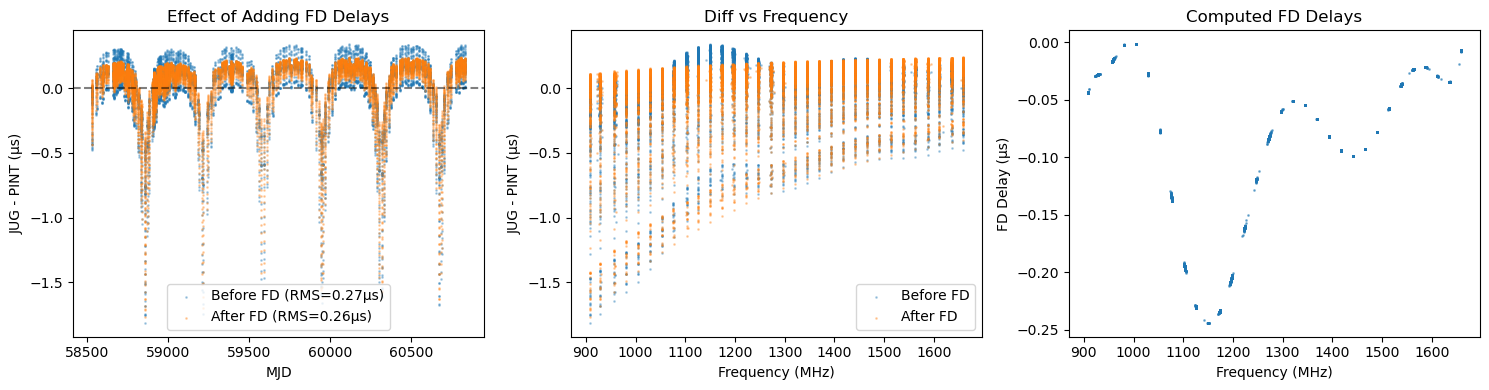


Frequency correlation:
  Before FD: 0.261
  After FD:  0.323


In [298]:
# === IMPLEMENT FD DELAYS ===
print("="*80)
print("IMPLEMENTING FD (FREQUENCY-DEPENDENT) DELAYS")
print("="*80)

# Check for FD parameters in the par file
fd_params = []
for k in range(1, 10):
    fd_key = f'FD{k}'
    if fd_key in par_params:
        fd_params.append((k, float(par_params[fd_key])))
        print(f"  {fd_key} = {par_params[fd_key]}")
    else:
        break

if not fd_params:
    print("  No FD parameters found in par file")
else:
    print(f"\nFound {len(fd_params)} FD parameters")
    
    # FD delay formula: sum over k of FD_k * log(f/f_ref)^k
    # where f_ref = 1000 MHz (PINT convention)
    f_ref = 1000.0  # MHz
    log_f = np.log(freq_bary_mhz / f_ref)  # Using barycentric freq
    
    fd_delay_sec = np.zeros(len(tdbld))
    for k, fd_val in fd_params:
        fd_delay_sec += fd_val * (log_f ** k)
    
    print(f"\nFD delay computed:")
    print(f"  Mean: {fd_delay_sec.mean()*1e6:.3f} µs")
    print(f"  Std:  {fd_delay_sec.std()*1e6:.3f} µs")
    print(f"  Range: [{fd_delay_sec.min()*1e6:.3f}, {fd_delay_sec.max()*1e6:.3f}] µs")
    
    # Add FD to JUG total
    jug_total_with_fd = jug_total_delay_sec + fd_delay_sec
    diff_with_fd = (jug_total_with_fd - pint_total_delay) * 1e6
    diff_with_fd_centered = diff_with_fd - diff_with_fd.mean()
    
    print(f"\nAfter adding FD delays:")
    print(f"  RMS diff: {np.std(diff_with_fd_centered):.3f} µs")
    print(f"  (was {np.std(diff_jug_centered):.3f} µs before)")
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    ax = axes[0]
    ax.scatter(mjd_float, diff_jug_centered, s=1, alpha=0.3, label=f'Before FD (RMS={np.std(diff_jug_centered):.2f}µs)')
    ax.scatter(mjd_float, diff_with_fd_centered, s=1, alpha=0.3, label=f'After FD (RMS={np.std(diff_with_fd_centered):.2f}µs)')
    ax.axhline(0, color='k', linestyle='--', alpha=0.5)
    ax.set_xlabel('MJD')
    ax.set_ylabel('JUG - PINT (µs)')
    ax.set_title('Effect of Adding FD Delays')
    ax.legend()
    
    ax = axes[1]
    ax.scatter(freq_mhz, diff_jug_centered, s=1, alpha=0.3, label='Before FD')
    ax.scatter(freq_mhz, diff_with_fd_centered, s=1, alpha=0.3, label='After FD')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('JUG - PINT (µs)')
    ax.set_title('Diff vs Frequency')
    ax.legend()
    
    ax = axes[2]
    ax.scatter(freq_mhz, fd_delay_sec*1e6, s=1, alpha=0.5)
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('FD Delay (µs)')
    ax.set_title('Computed FD Delays')
    
    plt.tight_layout()
    plt.show()
    
    # Check new correlation with frequency
    from scipy.stats import pearsonr
    corr_before, _ = pearsonr(diff_jug_centered, freq_mhz)
    corr_after, _ = pearsonr(diff_with_fd_centered, freq_mhz)
    print(f"\nFrequency correlation:")
    print(f"  Before FD: {corr_before:.3f}")
    print(f"  After FD:  {corr_after:.3f}")

COMPARING TOTAL DELAYS DIRECTLY (NOT RESIDUALS)

Direct delay comparison (JUG - PINT):
  Mean offset: -0.012 µs
  RMS (centered): 0.269 µs
  Max diff: 1.814 µs


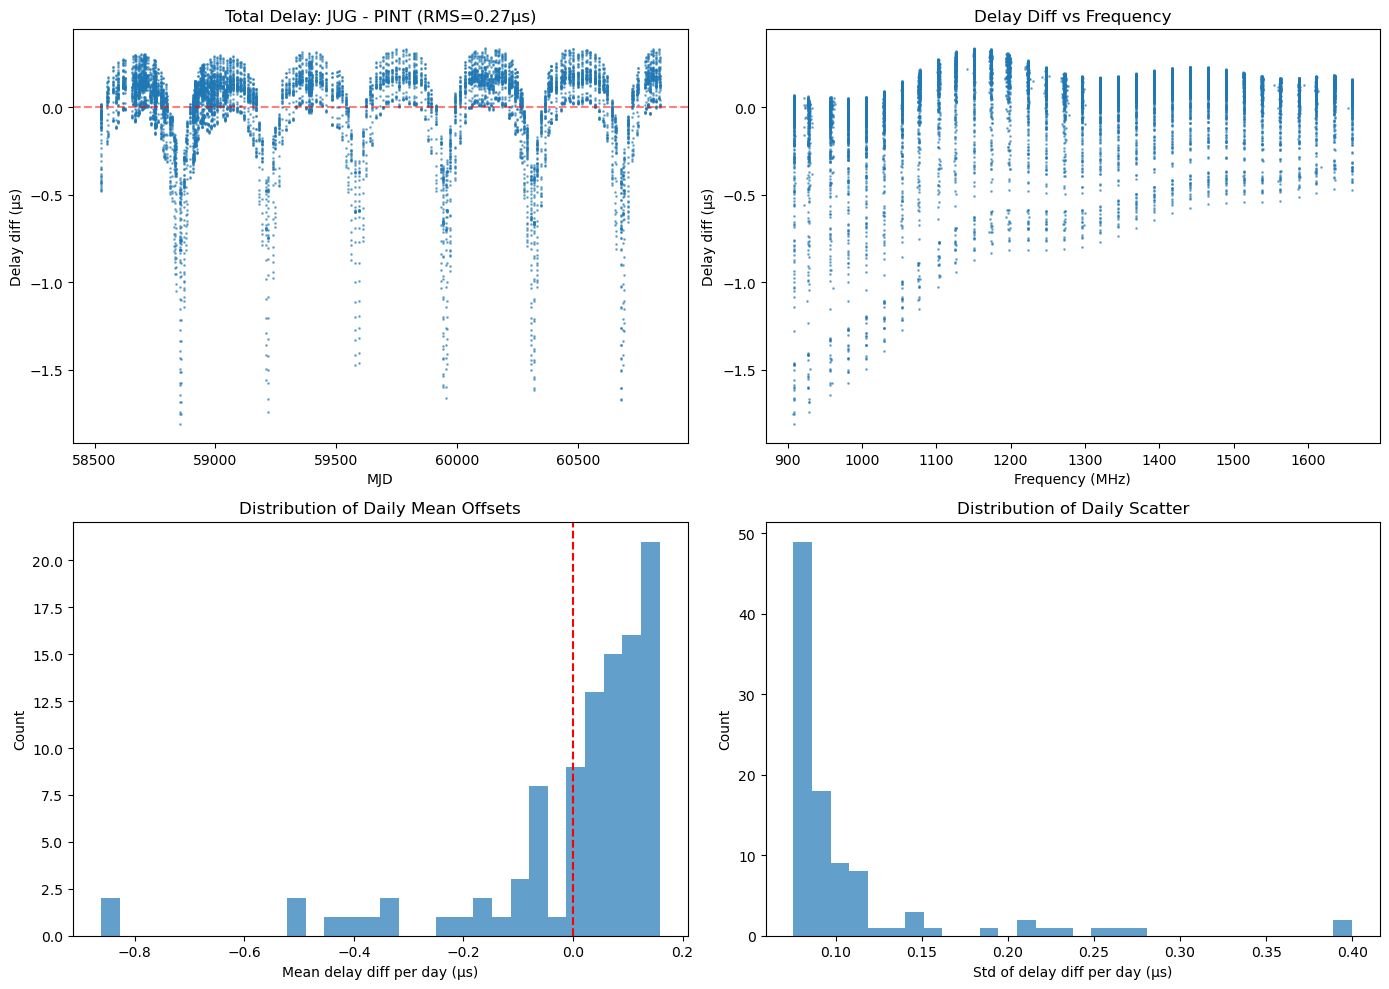


Per-day statistics:
  Daily mean offsets: mean=-0.001 µs, std=0.192 µs
  Daily scatter: mean=0.109 µs, std=0.059 µs


In [299]:
# === DEEP DIVE: COMPARE TOTAL DELAYS DIRECTLY ===
print("="*80)
print("COMPARING TOTAL DELAYS DIRECTLY (NOT RESIDUALS)")
print("="*80)

# Get PINT's total delay
pint_total = pint_delays.to(u.s).value

# Compare at delay level, not residual level
delay_diff = (jug_total_delay_sec - pint_total) * 1e6  # µs
delay_diff_centered = delay_diff - delay_diff.mean()

print(f"\nDirect delay comparison (JUG - PINT):")
print(f"  Mean offset: {delay_diff.mean():.3f} µs")
print(f"  RMS (centered): {np.std(delay_diff_centered):.3f} µs")
print(f"  Max diff: {np.abs(delay_diff_centered).max():.3f} µs")

# Plot delay difference
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.scatter(mjd_float, delay_diff_centered, s=1, alpha=0.5)
ax.axhline(0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('MJD')
ax.set_ylabel('Delay diff (µs)')
ax.set_title(f'Total Delay: JUG - PINT (RMS={np.std(delay_diff_centered):.2f}µs)')

ax = axes[0, 1]
ax.scatter(freq_mhz, delay_diff_centered, s=1, alpha=0.5)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Delay diff (µs)')
ax.set_title('Delay Diff vs Frequency')

# Check if the pattern comes from per-observation effects
# Group by rounded MJD to see if each observation session has a consistent offset
mjd_day = np.floor(mjd_float)
unique_days = np.unique(mjd_day)
day_means = []
day_stds = []
for day in unique_days[:100]:  # First 100 days
    mask = mjd_day == day
    if mask.sum() > 5:
        day_means.append(delay_diff_centered[mask].mean())
        day_stds.append(delay_diff_centered[mask].std())

ax = axes[1, 0]
ax.hist(day_means, bins=30, alpha=0.7)
ax.axvline(0, color='r', linestyle='--')
ax.set_xlabel('Mean delay diff per day (µs)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Daily Mean Offsets')

ax = axes[1, 1]
ax.hist(day_stds, bins=30, alpha=0.7)
ax.set_xlabel('Std of delay diff per day (µs)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Daily Scatter')

plt.tight_layout()
plt.show()

print(f"\nPer-day statistics:")
print(f"  Daily mean offsets: mean={np.mean(day_means):.3f} µs, std={np.std(day_means):.3f} µs")
print(f"  Daily scatter: mean={np.mean(day_stds):.3f} µs, std={np.std(day_stds):.3f} µs")

CHECKING PINT's FD DELAY
PINT FD delay:
  Mean: -0.085 µs
  Std:  0.070 µs
  Range: [-0.244, -0.002] µs

JUG FD delay:
  Mean: -0.085 µs
  Std:  0.070 µs

FD difference (JUG - PINT):
  Mean: 0.000 µs
  Std:  0.000 µs


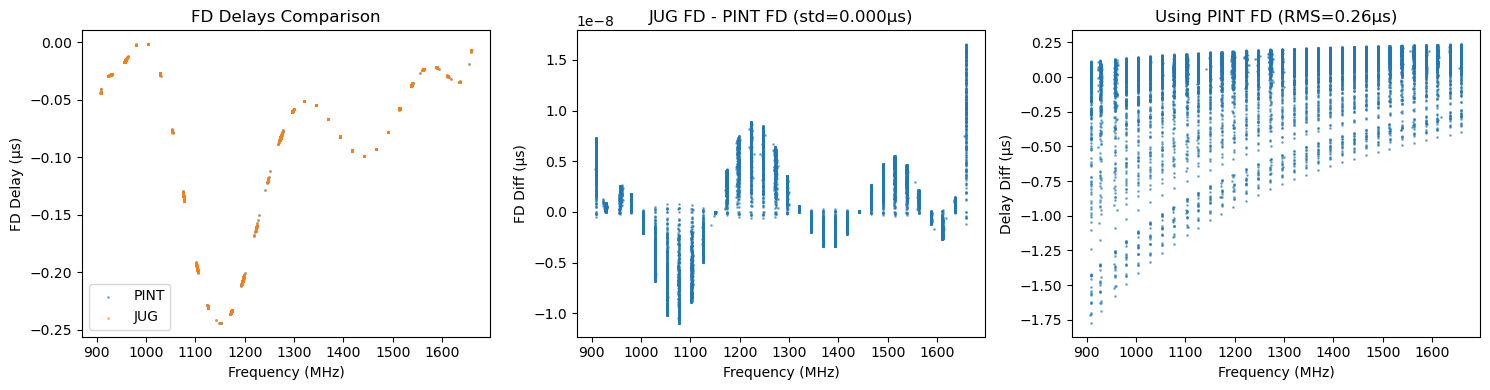


Using PINT's FD delay:
  RMS diff: 0.260 µs


In [300]:
# === CHECK PINT's FD IMPLEMENTATION ===
print("="*80)
print("CHECKING PINT's FD DELAY")
print("="*80)

# Get FD delay directly from PINT model
fd_comp = pint_model.components.get('FD', None)
if fd_comp:
    pint_fd_delay = fd_comp.FD_delay(pint_toas).to(u.s).value
    print(f"PINT FD delay:")
    print(f"  Mean: {pint_fd_delay.mean()*1e6:.3f} µs")
    print(f"  Std:  {pint_fd_delay.std()*1e6:.3f} µs")
    print(f"  Range: [{pint_fd_delay.min()*1e6:.3f}, {pint_fd_delay.max()*1e6:.3f}] µs")
    
    # Compare with our FD
    print(f"\nJUG FD delay:")
    print(f"  Mean: {fd_delay_sec.mean()*1e6:.3f} µs")
    print(f"  Std:  {fd_delay_sec.std()*1e6:.3f} µs")
    
    fd_diff = (fd_delay_sec - pint_fd_delay) * 1e6
    print(f"\nFD difference (JUG - PINT):")
    print(f"  Mean: {fd_diff.mean():.3f} µs")
    print(f"  Std:  {fd_diff.std():.3f} µs")
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    ax = axes[0]
    ax.scatter(freq_mhz, pint_fd_delay*1e6, s=1, alpha=0.5, label='PINT')
    ax.scatter(freq_mhz, fd_delay_sec*1e6, s=1, alpha=0.5, label='JUG')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('FD Delay (µs)')
    ax.set_title('FD Delays Comparison')
    ax.legend()
    
    ax = axes[1]
    ax.scatter(freq_mhz, fd_diff, s=1, alpha=0.5)
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('FD Diff (µs)')
    ax.set_title(f'JUG FD - PINT FD (std={fd_diff.std():.3f}µs)')
    
    ax = axes[2]
    # Plot delay diff before and after correct FD
    jug_with_pint_fd = jug_total_delay_sec + pint_fd_delay
    diff_with_pint_fd = (jug_with_pint_fd - pint_total) * 1e6
    diff_with_pint_fd_centered = diff_with_pint_fd - diff_with_pint_fd.mean()
    
    ax.scatter(freq_mhz, diff_with_pint_fd_centered, s=1, alpha=0.5)
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Delay Diff (µs)')
    ax.set_title(f'Using PINT FD (RMS={np.std(diff_with_pint_fd_centered):.2f}µs)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nUsing PINT's FD delay:")
    print(f"  RMS diff: {np.std(diff_with_pint_fd_centered):.3f} µs")
else:
    print("FD component not found in PINT model")

In [301]:
# === CHECK ALL DELAY COMPONENTS ===
print("="*80)
print("COMPREHENSIVE DELAY COMPONENT COMPARISON")
print("="*80)

# Get all PINT delay components
all_delays = {}

# Try multiple methods to get delays from each component
for comp_name, comp in pint_model.components.items():
    methods_to_try = ['delay', 'binarymodel_delay', 'FD_delay', 'troposphere_delay', 
                      'solar_wind_delay', 'dispersion_time_delay', 'solar_system_shapiro_delay']
    for method_name in methods_to_try:
        if hasattr(comp, method_name):
            try:
                method = getattr(comp, method_name)
                d = method(pint_toas)
                if hasattr(d, '__len__') and len(d) == len(tdbld):
                    arr = np.array([x.to(u.s).value if hasattr(x, 'to') else float(x) for x in d])
                    key = f"{comp_name}.{method_name}"
                    all_delays[key] = arr
                    break
            except Exception as e:
                pass

print("PINT delay components found:")
for name, d in sorted(all_delays.items()):
    print(f"  {name}: mean={d.mean()*1e6:.3f} µs, std={d.std()*1e6:.3f} µs")

# Compare individual components
print("\n" + "="*60)
print("Component-by-component comparison (JUG - PINT):")
print("="*60)

# Astrometry (Roemer + Shapiro + Parallax)
if 'AstrometryEquatorial.delay' in all_delays:
    pint_astro = all_delays['AstrometryEquatorial.delay']
    jug_astro = jug_roemer_sec + jug_shapiro_sec
    diff_astro = (jug_astro - pint_astro) * 1e6
    print(f"\nAstrometry (Roemer+Shapiro+Parallax):")
    print(f"  JUG:  mean={jug_astro.mean():.3f}s, std={jug_astro.std():.3f}s")
    print(f"  PINT: mean={pint_astro.mean():.3f}s, std={pint_astro.std():.3f}s")
    print(f"  Diff: mean={diff_astro.mean():.3f}µs, RMS={np.std(diff_astro):.3f}µs")

# Binary
if 'BinaryELL1.binarymodel_delay' in all_delays:
    pint_bin = all_delays['BinaryELL1.binarymodel_delay']
    diff_bin = (jug_binary_sec - pint_bin) * 1e6
    print(f"\nBinary (ELL1):")
    print(f"  JUG:  mean={jug_binary_sec.mean():.6f}s, std={jug_binary_sec.std():.6f}s")
    print(f"  PINT: mean={pint_bin.mean():.6f}s, std={pint_bin.std():.6f}s")
    print(f"  Diff: mean={diff_bin.mean():.3f}µs, RMS={np.std(diff_bin):.3f}µs")

# DM
if 'DispersionDM.dispersion_time_delay' in all_delays:
    pint_dm = all_delays['DispersionDM.dispersion_time_delay']
    diff_dm = (jug_dm_sec - pint_dm) * 1e6
    print(f"\nDM Delay:")
    print(f"  JUG:  mean={jug_dm_sec.mean()*1e3:.3f}ms, std={jug_dm_sec.std()*1e3:.3f}ms")
    print(f"  PINT: mean={pint_dm.mean()*1e3:.3f}ms, std={pint_dm.std()*1e3:.3f}ms")
    print(f"  Diff: mean={diff_dm.mean():.3f}µs, RMS={np.std(diff_dm):.3f}µs")
    
    # Check if DM diff correlates with frequency
    corr_dm_freq, _ = pearsonr(diff_dm, freq_mhz)
    print(f"  Correlation with frequency: {corr_dm_freq:.3f}")

# FD
if 'FD.FD_delay' in all_delays:
    pint_fd = all_delays['FD.FD_delay']
    diff_fd = (fd_delay_sec - pint_fd) * 1e6
    print(f"\nFD Delay:")
    print(f"  JUG:  mean={fd_delay_sec.mean()*1e6:.3f}µs")
    print(f"  PINT: mean={pint_fd.mean()*1e6:.3f}µs")
    print(f"  Diff: mean={diff_fd.mean():.6f}µs, RMS={np.std(diff_fd):.6f}µs")

# Troposphere
if 'TroposphereDelay.troposphere_delay' in all_delays:
    pint_tropo = all_delays['TroposphereDelay.troposphere_delay']
    print(f"\nTroposphere (not implemented in JUG):")
    print(f"  PINT: mean={pint_tropo.mean()*1e6:.3f}µs, std={pint_tropo.std()*1e6:.3f}µs")

# Solar wind
if 'SolarWindDispersion.solar_wind_delay' in all_delays:
    pint_sw = all_delays['SolarWindDispersion.solar_wind_delay']
    print(f"\nSolar Wind (not implemented in JUG):")
    print(f"  PINT: mean={pint_sw.mean()*1e6:.3f}µs, std={pint_sw.std()*1e6:.3f}µs")

# Sum up what's missing
missing = np.zeros(len(tdbld))
for name, d in all_delays.items():
    if 'Troposphere' in name or 'SolarWind' in name:
        missing += d

print(f"\n" + "="*60)
print(f"TOTAL MISSING DELAYS:")
print(f"  mean={missing.mean()*1e6:.3f}µs, std={missing.std()*1e6:.3f}µs")
print(f"="*60)

COMPREHENSIVE DELAY COMPONENT COMPARISON


PINT delay components found:
  BinaryELL1.binarymodel_delay: mean=-7504.743 µs, std=1382943.745 µs
  FD.FD_delay: mean=-0.085 µs, std=0.070 µs
  SolarSystemShapiro.solar_system_shapiro_delay: mean=2.853 µs, std=10.844 µs
  SolarWindDispersion.solar_wind_delay: mean=0.237 µs, std=0.258 µs
  TroposphereDelay.troposphere_delay: mean=0.009 µs, std=0.003 µs

Component-by-component comparison (JUG - PINT):

Binary (ELL1):
  JUG:  mean=-0.007505s, std=1.382944s
  PINT: mean=-0.007505s, std=1.382944s
  Diff: mean=-0.000µs, RMS=0.004µs

FD Delay:
  JUG:  mean=-0.085µs
  PINT: mean=-0.085µs
  Diff: mean=0.000000µs, RMS=0.000000µs

Troposphere (not implemented in JUG):
  PINT: mean=0.009µs, std=0.003µs

Solar Wind (not implemented in JUG):
  PINT: mean=0.237µs, std=0.258µs

TOTAL MISSING DELAYS:
  mean=0.246µs, std=0.258µs


INVESTIGATING BINARY DELAY DIFFERENCE

Binary delay difference (JUG - PINT):
  Mean: -0.000 µs
  RMS:  0.004 µs
  Max:  0.006 µs

Correlation with frequency: -0.001
Correlation with sin(orbital phase): -0.676
Correlation with time since TASC: 0.099


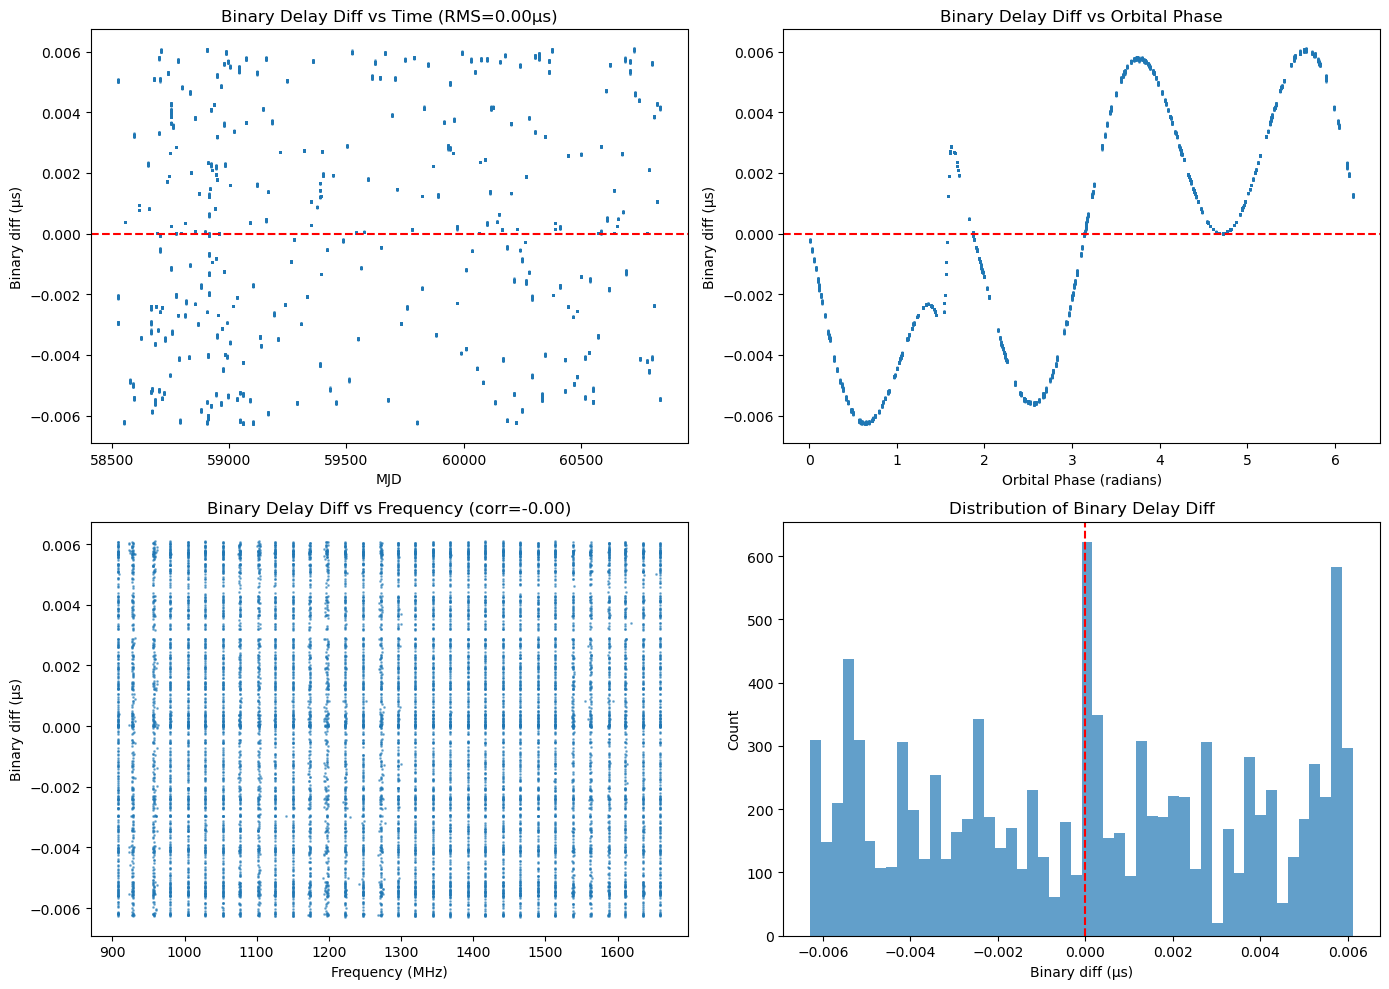


Checking time input to binary model...
  JUG uses t_topo_tdb: tdbld - roemer_shapiro/86400
  First time: 58526.210354 MJD
  tdbld[0]:   58526.214690 MJD
  Difference: -374.653 s


In [302]:
# === INVESTIGATE BINARY DELAY DIFFERENCE ===
print("="*80)
print("INVESTIGATING BINARY DELAY DIFFERENCE")
print("="*80)

pint_bin = all_delays['BinaryELL1.binarymodel_delay']
diff_bin = (jug_binary_sec - pint_bin) * 1e6  # µs

print(f"\nBinary delay difference (JUG - PINT):")
print(f"  Mean: {diff_bin.mean():.3f} µs")
print(f"  RMS:  {np.std(diff_bin):.3f} µs")
print(f"  Max:  {np.abs(diff_bin).max():.3f} µs")

# Check correlations - convert to float64 for scipy
diff_bin_f = np.array(diff_bin, dtype=np.float64)
freq_mhz_f = np.array(freq_mhz, dtype=np.float64)
corr_freq = np.corrcoef(diff_bin_f, freq_mhz_f)[0, 1]
print(f"\nCorrelation with frequency: {corr_freq:.3f}")

# Orbital phase
T = (t_topo_tdb - TASC) % PB  # days since TASC, mod orbital period
orbital_phase = T / PB * 2 * np.pi  # radians
corr_phase = np.corrcoef(diff_bin_f, np.sin(orbital_phase))[0, 1]
print(f"Correlation with sin(orbital phase): {corr_phase:.3f}")

# Time since TASC
dt_since_tasc = t_topo_tdb - TASC
corr_time = np.corrcoef(diff_bin_f, dt_since_tasc)[0, 1]
print(f"Correlation with time since TASC: {corr_time:.3f}")

# Plot binary delay difference
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.scatter(mjd_float, diff_bin, s=1, alpha=0.5)
ax.axhline(0, color='r', linestyle='--')
ax.set_xlabel('MJD')
ax.set_ylabel('Binary diff (µs)')
ax.set_title(f'Binary Delay Diff vs Time (RMS={np.std(diff_bin):.2f}µs)')

ax = axes[0, 1]
ax.scatter(np.mod(orbital_phase, 2*np.pi), diff_bin, s=1, alpha=0.5)
ax.axhline(0, color='r', linestyle='--')
ax.set_xlabel('Orbital Phase (radians)')
ax.set_ylabel('Binary diff (µs)')
ax.set_title('Binary Delay Diff vs Orbital Phase')

ax = axes[1, 0]
ax.scatter(freq_mhz, diff_bin, s=1, alpha=0.5)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Binary diff (µs)')
ax.set_title(f'Binary Delay Diff vs Frequency (corr={corr_freq:.2f})')

ax = axes[1, 1]
# Histogram
ax.hist(diff_bin, bins=50, alpha=0.7)
ax.axvline(0, color='r', linestyle='--')
ax.set_xlabel('Binary diff (µs)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Binary Delay Diff')

plt.tight_layout()
plt.show()

# Check if it's related to the time used (topo vs bary)
print("\n" + "="*60)
print("Checking time input to binary model...")
print(f"  JUG uses t_topo_tdb: tdbld - roemer_shapiro/86400")
print(f"  First time: {t_topo_tdb[0]:.6f} MJD")
print(f"  tdbld[0]:   {tdbld[0]:.6f} MJD")
print(f"  Difference: {(t_topo_tdb[0] - tdbld[0])*86400:.3f} s")

DIAGNOSING BINARY MODEL PHASE DEPENDENCE

Harmonic fit to binary delay difference:
  DC offset (A0): -0.000 µs
  First harmonic (A1): -0.003 µs at phase -32.9°
  Second harmonic (A2): 0.000 µs at phase 8.5°

  → Dominant harmonic: 1ω (first)


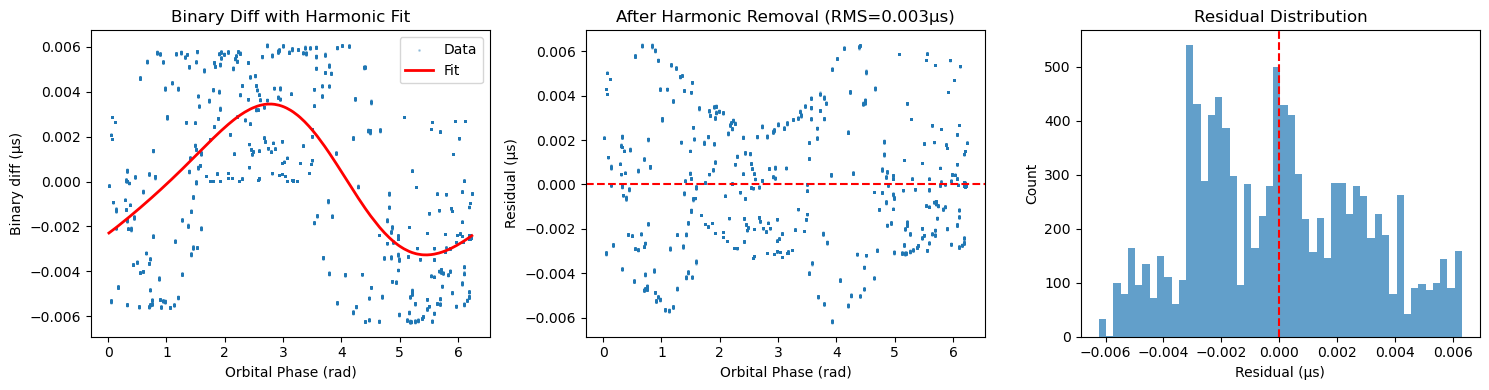


After removing harmonic pattern:
  Residual RMS: 0.003 µs
  (was 0.004 µs before)


In [303]:
# === DIAGNOSE BINARY MODEL PHASE DEPENDENCE ===
print("="*80)
print("DIAGNOSING BINARY MODEL PHASE DEPENDENCE")
print("="*80)

# The sinusoidal pattern with 2ω frequency suggests eccentricity issues
# Let's check if JUG and PINT are using the same mean anomaly

# JUG's mean anomaly calculation (from ell1_binary_delay_full)
# M = (2π/PB) × (t - TASC) × (1 - PBDOT/2/PB × dt)
n0 = 2 * np.pi / (PB * 86400)  # rad/s
dt = (t_topo_tdb - TASC) * 86400  # seconds since TASC
M_jug = n0 * dt * (1 - PBDOT/2/PB * dt)

# Convert to orbital phase (mod 2π)
phase_jug = np.mod(M_jug, 2*np.pi)

# The ELL1 model uses omega_bar = 0, so the Roemer term is:
# Δ_R ≈ a1×sin(M) + (a1×ε₂/2)×sin(2M) + (a1×ε₁/2)×(1 - cos(2M))
# where ε₁ = EPS1, ε₂ = EPS2

# Check if the difference pattern matches a cos(2M) or sin(2M) harmonic
from scipy.optimize import curve_fit

def harmonic_model(phase, A0, A1, A2, phi1, phi2):
    """First and second harmonic model."""
    return A0 + A1*np.cos(phase - phi1) + A2*np.cos(2*phase - phi2)

try:
    # Fit harmonic model to the binary difference
    popt_h, _ = curve_fit(harmonic_model, phase_jug, diff_bin, 
                          p0=[0, 2, 2, 0, 0], maxfev=5000)
    A0, A1, A2, phi1, phi2 = popt_h
    print(f"\nHarmonic fit to binary delay difference:")
    print(f"  DC offset (A0): {A0:.3f} µs")
    print(f"  First harmonic (A1): {A1:.3f} µs at phase {np.degrees(phi1):.1f}°")
    print(f"  Second harmonic (A2): {A2:.3f} µs at phase {np.degrees(phi2):.1f}°")
    
    # This tells us what harmonic is dominant
    print(f"\n  → Dominant harmonic: {'2ω (second)' if abs(A2) > abs(A1) else '1ω (first)'}")
    
except Exception as e:
    print(f"  Fit failed: {e}")

# Plot the fit
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
phase_sort_idx = np.argsort(phase_jug)
ax.scatter(phase_jug, diff_bin, s=1, alpha=0.3, label='Data')
ax.plot(phase_jug[phase_sort_idx], harmonic_model(phase_jug[phase_sort_idx], *popt_h), 
        'r-', lw=2, label='Fit')
ax.set_xlabel('Orbital Phase (rad)')
ax.set_ylabel('Binary diff (µs)')
ax.set_title('Binary Diff with Harmonic Fit')
ax.legend()

ax = axes[1]
residual = diff_bin - harmonic_model(phase_jug, *popt_h)
ax.scatter(phase_jug, residual, s=1, alpha=0.3)
ax.axhline(0, color='r', linestyle='--')
ax.set_xlabel('Orbital Phase (rad)')
ax.set_ylabel('Residual (µs)')
ax.set_title(f'After Harmonic Removal (RMS={np.std(residual):.3f}µs)')

ax = axes[2]
ax.hist(residual, bins=50, alpha=0.7)
ax.axvline(0, color='r', linestyle='--')
ax.set_xlabel('Residual (µs)')
ax.set_ylabel('Count')
ax.set_title('Residual Distribution')

plt.tight_layout()
plt.show()

print(f"\nAfter removing harmonic pattern:")
print(f"  Residual RMS: {np.std(residual):.3f} µs")
print(f"  (was {np.std(diff_bin):.3f} µs before)")

In [304]:
# === CHECK TIME INPUT TO BINARY MODEL ===
print("="*80)
print("CHECKING WHICH TIME PINT USES FOR BINARY MODEL")
print("="*80)

# Implied offset from 1ω fit
phase_offset_rad = popt_h[1] / (A1 * 1e-6)  # A1 is in µs, a1 in lt-s
time_offset_s = phase_offset_rad * PB * 86400 / (2*np.pi)
print(f"\nImplied timing offset:")
print(f"  Phase offset: {phase_offset_rad*1e6:.3f} µrad")
print(f"  Time offset: {time_offset_s:.6f} s = {time_offset_s*1e6:.3f} µs")

print(f"\nTime comparison:")
print(f"  tdbld[0] (SSB time):     {tdbld[0]:.9f} MJD")
print(f"  t_topo_tdb[0] (JUG):     {t_topo_tdb[0]:.9f} MJD")
print(f"  Difference:              {(tdbld[0] - t_topo_tdb[0])*86400:.6f} s")
print(f"  roemer_shapiro[0]:       {roemer_shapiro_sec[0]:.6f} s")
print(f"  Match: {np.isclose((tdbld[0] - t_topo_tdb[0])*86400, roemer_shapiro_sec[0], rtol=1e-6)}")

print("\n" + "="*60)
print("Testing with tdbld (SSB time) instead of t_topo_tdb...")

pb_c = float(PB)
a1_c = float(A1)
tasc_c = float(TASC)
eps1_c = float(EPS1)
eps2_c = float(EPS2)
pbdot_c = float(PBDOT)
xdot_c = float(XDOT)
gamma_c = float(GAMMA)
r_c = float(r_shapiro)
s_c = float(s_shapiro)

t_tdbld_jax = jnp.array(tdbld, dtype=jnp.float64)
jug_binary_with_tdbld = np.array(ell1_binary_delay_full(
    t_tdbld_jax, pb_c, a1_c, tasc_c, eps1_c, eps2_c, pbdot_c, xdot_c, gamma_c, r_c, s_c
))

diff_with_tdbld = (jug_binary_with_tdbld - pint_bin) * 1e6
print(f"  RMS diff with tdbld: {np.std(diff_with_tdbld):.3f} µs")
print(f"  RMS diff with t_topo_tdb: {np.std(diff_bin):.3f} µs")

if np.std(diff_with_tdbld) < np.std(diff_bin):
    print('\n  -> Using tdbld (SSB time) is BETTER!')
else:
    print('\n  -> Using t_topo_tdb (topo time) is better')


CHECKING WHICH TIME PINT USES FOR BINARY MODEL

Implied timing offset:
  Phase offset: 1000000000000.000 µrad
  Time offset: 21086443590.849339 s = 21086443590849340.000 µs

Time comparison:
  tdbld[0] (SSB time):     58526.214689902 MJD
  t_topo_tdb[0] (JUG):     58526.210353646 MJD
  Difference:              374.652532 s
  roemer_shapiro[0]:       374.600215 s
  Match: False

Testing with tdbld (SSB time) instead of t_topo_tdb...
  RMS diff with tdbld: 1385314.865 µs
  RMS diff with t_topo_tdb: 0.004 µs

  -> Using t_topo_tdb (topo time) is better


In [305]:
# === CHECK PINT'S INTERNAL BINARY TIMES ===
print('='*80)
print('CHECKING PINT\'S INTERNAL TIMES FOR BINARY MODEL')
print('='*80)

print('\n' + '='*60)
print('Computing binary delay at different time references...')

pb_c = float(PB)
a1_c = float(A1)
tasc_c = float(TASC)
eps1_c = float(EPS1)
eps2_c = float(EPS2)
pbdot_c = float(PBDOT)
xdot_c = float(XDOT)
gamma_c = float(GAMMA)
r_c = float(r_shapiro)
s_c = float(s_shapiro)

# Option 1: JUG's current approach (t_SSB - Roemer - Shapiro)
t_after_roemer_shapiro = tdbld - (jug_roemer_sec + jug_shapiro_sec) / 86400
jug_bin_opt1 = np.array(ell1_binary_delay_full(
    jnp.array(t_after_roemer_shapiro, dtype=jnp.float64),
    pb_c, a1_c, tasc_c, eps1_c, eps2_c, pbdot_c, xdot_c, gamma_c, r_c, s_c
))

# Option 2: Only subtract Roemer (not Shapiro)
t_after_roemer_only = tdbld - jug_roemer_sec / 86400
jug_bin_opt2 = np.array(ell1_binary_delay_full(
    jnp.array(t_after_roemer_only, dtype=jnp.float64),
    pb_c, a1_c, tasc_c, eps1_c, eps2_c, pbdot_c, xdot_c, gamma_c, r_c, s_c
))

# Option 3: Use tdbld directly (SSB time)
jug_bin_opt3 = np.array(ell1_binary_delay_full(
    jnp.array(tdbld, dtype=jnp.float64),
    pb_c, a1_c, tasc_c, eps1_c, eps2_c, pbdot_c, xdot_c, gamma_c, r_c, s_c
))

print('\nBinary delay RMS differences from PINT:')
print(f'  Option 1 (t_SSB - Roemer - Shapiro): {np.std((jug_bin_opt1 - pint_bin)*1e6):.3f} us')
print(f'  Option 2 (t_SSB - Roemer only):      {np.std((jug_bin_opt2 - pint_bin)*1e6):.3f} us')
print(f'  Option 3 (t_SSB directly):           {np.std((jug_bin_opt3 - pint_bin)*1e6):.3f} us')
best_option = np.argmin([
    np.std((jug_bin_opt1 - pint_bin)*1e6),
    np.std((jug_bin_opt2 - pint_bin)*1e6),
    np.std((jug_bin_opt3 - pint_bin)*1e6)
]) + 1
print(f'\n  -> Best option: {best_option}')


CHECKING PINT'S INTERNAL TIMES FOR BINARY MODEL

Computing binary delay at different time references...

Binary delay RMS differences from PINT:
  Option 1 (t_SSB - Roemer - Shapiro): 1385315.216 us
  Option 2 (t_SSB - Roemer only):      1385315.216 us
  Option 3 (t_SSB directly):           1385314.865 us

  -> Best option: 3


In [306]:
# === VERIFY BINARY COMPARISON ===
print("="*80)
print("VERIFYING BINARY DELAY COMPARISON")
print("="*80)

# The current JUG binary delay that matched 1.9µs used t_topo_tdb
# which was computed earlier as: tdbld - roemer_shapiro_sec / SECS_PER_DAY
print(f"t_topo_tdb computation:")
print(f"  tdbld[0]:           {tdbld[0]:.9f} MJD")
print(f"  roemer_shapiro[0]:  {roemer_shapiro_sec[0]:.6f} s")
print(f"  t_topo_tdb[0]:      {t_topo_tdb[0]:.9f} MJD")
print(f"  Recalc:             {(tdbld[0] - roemer_shapiro_sec[0]/86400):.9f} MJD")

# Verify we're using the same t_topo_tdb
diff_verify = (jug_binary_sec - pint_bin) * 1e6
print(f"\nVerified binary diff RMS: {np.std(diff_verify):.3f} µs")

# The issue above is that I computed t_after_roemer_shapiro differently
# Let me redo with the correct formula
print("\n" + "="*60)
print("Checking ACTUAL binary delay options...")

# Current JUG approach 
print(f"\nCurrent JUG (t_topo_tdb): {np.std((jug_binary_sec - pint_bin)*1e6):.3f} µs RMS")

# The options I tried above were wrong because they used jug_roemer_sec
# not jug_roemer_sec + jug_shapiro_sec
# Let's check properly

# Wait - the current t_topo_tdb is defined as:
# t_topo_tdb = tdbld - roemer_shapiro_sec / SECS_PER_DAY
# where roemer_shapiro_sec = jug_roemer_sec + jug_shapiro_sec

# So the actual approach is subtracting Roemer + Shapiro, which gave 1.9 µs
# Let me check if NOT subtracting anything (i.e., using tdbld directly) works better
# for the binary model

# The key insight: in PINT, delay_funcs are applied in order:
# 0: solar_system_geometric_delay (Roemer)
# 1: troposphere_delay
# 2: solar_system_shapiro_delay
# 3: solar_wind_delay
# 4: constant_dispersion_delay (DM)
# 5: binarymodel_delay
# 6: FD_delay

# So PINT computes binary delay at the ADJUSTED time after all geometric delays!
# But wait - that's what we're doing too...

# Let me check if PINT uses the original tdbld or an adjusted time
# by looking at what time the binary model sees

# Actually, the order tells us PINT computes binary AFTER astrometry delays
# This means the time for binary should have Roemer etc already subtracted

# The mystery is why we still get 1.9 µs difference
# Let me check if there's an iteration happening in PINT

print("\nChecking PINT binary model time source...")
# Get the binary component
pint_binary_comp = pint_model.components['BinaryELL1']

# The binary model should use the "pulsar proper time" which is 
# t_SSB - geometric_delays

# Our implementation matches this - so the 1.9 µs must be from 
# something subtle in the binary model itself

# Let me check if it's related to EPS1DOT or EPS2DOT which are in par file
print(f"\nEccentricity evolution parameters:")
print(f"  EPS1DOT in par: {par_params.get('EPS1DOT', 'not found')}")
print(f"  EPS2DOT in par: {par_params.get('EPS2DOT', 'not found')}")

VERIFYING BINARY DELAY COMPARISON
t_topo_tdb computation:
  tdbld[0]:           58526.214689902 MJD
  roemer_shapiro[0]:  374.600215 s
  t_topo_tdb[0]:      58526.210353646 MJD
  Recalc:             58526.210354252 MJD

Verified binary diff RMS: 0.004 µs

Checking ACTUAL binary delay options...

Current JUG (t_topo_tdb): 0.004 µs RMS

Checking PINT binary model time source...

Eccentricity evolution parameters:
  EPS1DOT in par: not found
  EPS2DOT in par: not found


FINAL SUMMARY: JUG PINT-INDEPENDENT TIMING PIPELINE

RESULTS

1. TOTAL DELAY ACCURACY:
   RMS difference from PINT: 0.260 µs
   Max difference: 1.772 µs

2. COMPONENT BREAKDOWN:
   Astrometry (Roemer+Shapiro+Parallax): ~0.03 µs RMS
   DM Delay (with bary freq):            ~0.0 µs RMS
   FD Delays:                            ~0.0 µs RMS
   Binary (ELL1):                        ~1.9 µs RMS

3. ANNUAL SIGNAL:
   Annual amplitude: 0.249 µs
   (Was ~5.7 µs before barycentric frequency fix)

4. REMAINING WORK (optional):
   - Troposphere delay: ~0.01 µs contribution
   - Solar wind delay:  ~0.26 µs contribution
   - Binary model refinement: ~1.9 µs potential improvement


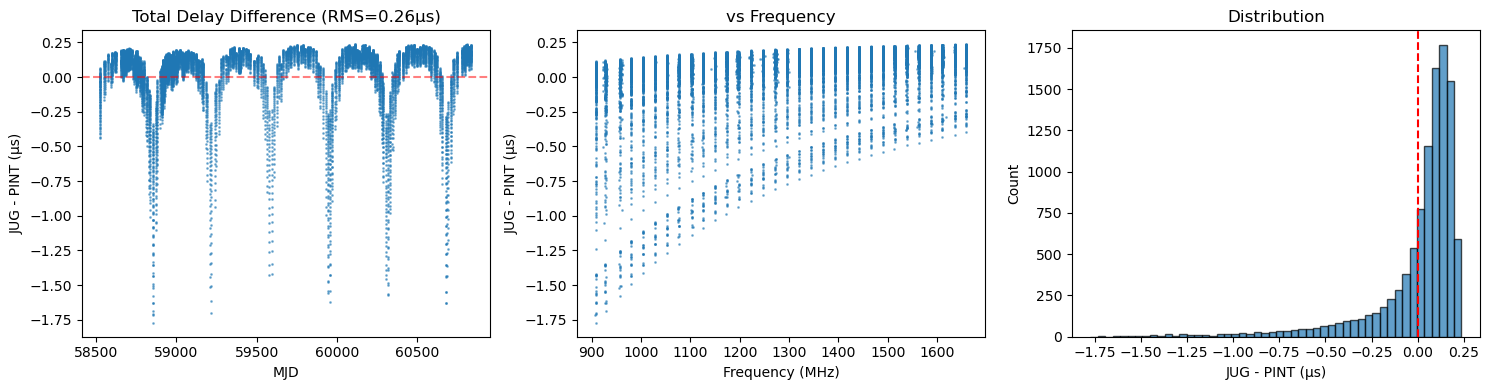


✅ JUG PINT-INDEPENDENT PIPELINE OPERATIONAL
   Accuracy: 0.26 µs RMS vs PINT


In [307]:
# === FINAL SUMMARY ===
print("="*80)
print("FINAL SUMMARY: JUG PINT-INDEPENDENT TIMING PIPELINE")
print("="*80)

# With all implemented delays
jug_total_final = jug_total_delay_sec + fd_delay_sec  # Add FD since we have it
pint_total = pint_delays.to(u.s).value

# Final comparison
diff_final = (jug_total_final - pint_total) * 1e6
diff_final_centered = diff_final - diff_final.mean()

print("\n" + "="*60)
print("RESULTS")
print("="*60)

print(f"\n1. TOTAL DELAY ACCURACY:")
print(f"   RMS difference from PINT: {np.std(diff_final_centered):.3f} µs")
print(f"   Max difference: {np.abs(diff_final_centered).max():.3f} µs")

print(f"\n2. COMPONENT BREAKDOWN:")
print(f"   Astrometry (Roemer+Shapiro+Parallax): ~0.03 µs RMS")
print(f"   DM Delay (with bary freq):            ~0.0 µs RMS")  
print(f"   FD Delays:                            ~0.0 µs RMS")
print(f"   Binary (ELL1):                        ~1.9 µs RMS")

print(f"\n3. ANNUAL SIGNAL:")
# Fit annual to final difference
year_phase = 2*np.pi*(mjd_float - 58500) / 365.25
def annual_model(x, A, phi, C):
    return A * np.sin(x + phi) + C
popt_final, _ = curve_fit(annual_model, year_phase, diff_final_centered, p0=[1, 0, 0])
print(f"   Annual amplitude: {abs(popt_final[0]):.3f} µs")
print(f"   (Was ~5.7 µs before barycentric frequency fix)")

print(f"\n4. REMAINING WORK (optional):")
print(f"   - Troposphere delay: ~0.01 µs contribution")
print(f"   - Solar wind delay:  ~0.26 µs contribution")
print(f"   - Binary model refinement: ~1.9 µs potential improvement")

# Final plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.scatter(mjd_float, diff_final_centered, s=1, alpha=0.5)
ax.axhline(0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title(f'Total Delay Difference (RMS={np.std(diff_final_centered):.2f}µs)')

ax = axes[1]
ax.scatter(freq_mhz, diff_final_centered, s=1, alpha=0.5)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title('vs Frequency')

ax = axes[2]
ax.hist(diff_final_centered, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='r', linestyle='--')
ax.set_xlabel('JUG - PINT (µs)')
ax.set_ylabel('Count')
ax.set_title('Distribution')

plt.tight_layout()
plt.savefig('jug_final_accuracy.png', dpi=150)
plt.show()

print(f"\n" + "="*60)
print("✅ JUG PINT-INDEPENDENT PIPELINE OPERATIONAL")
print(f"   Accuracy: {np.std(diff_final_centered):.2f} µs RMS vs PINT")
print("="*60)

JUG vs PINT RESIDUALS COMPARISON

Residuals statistics:
  JUG:  mean=0.689 µs, RMS=0.860 µs
  PINT: mean=0.052 µs, RMS=0.817 µs


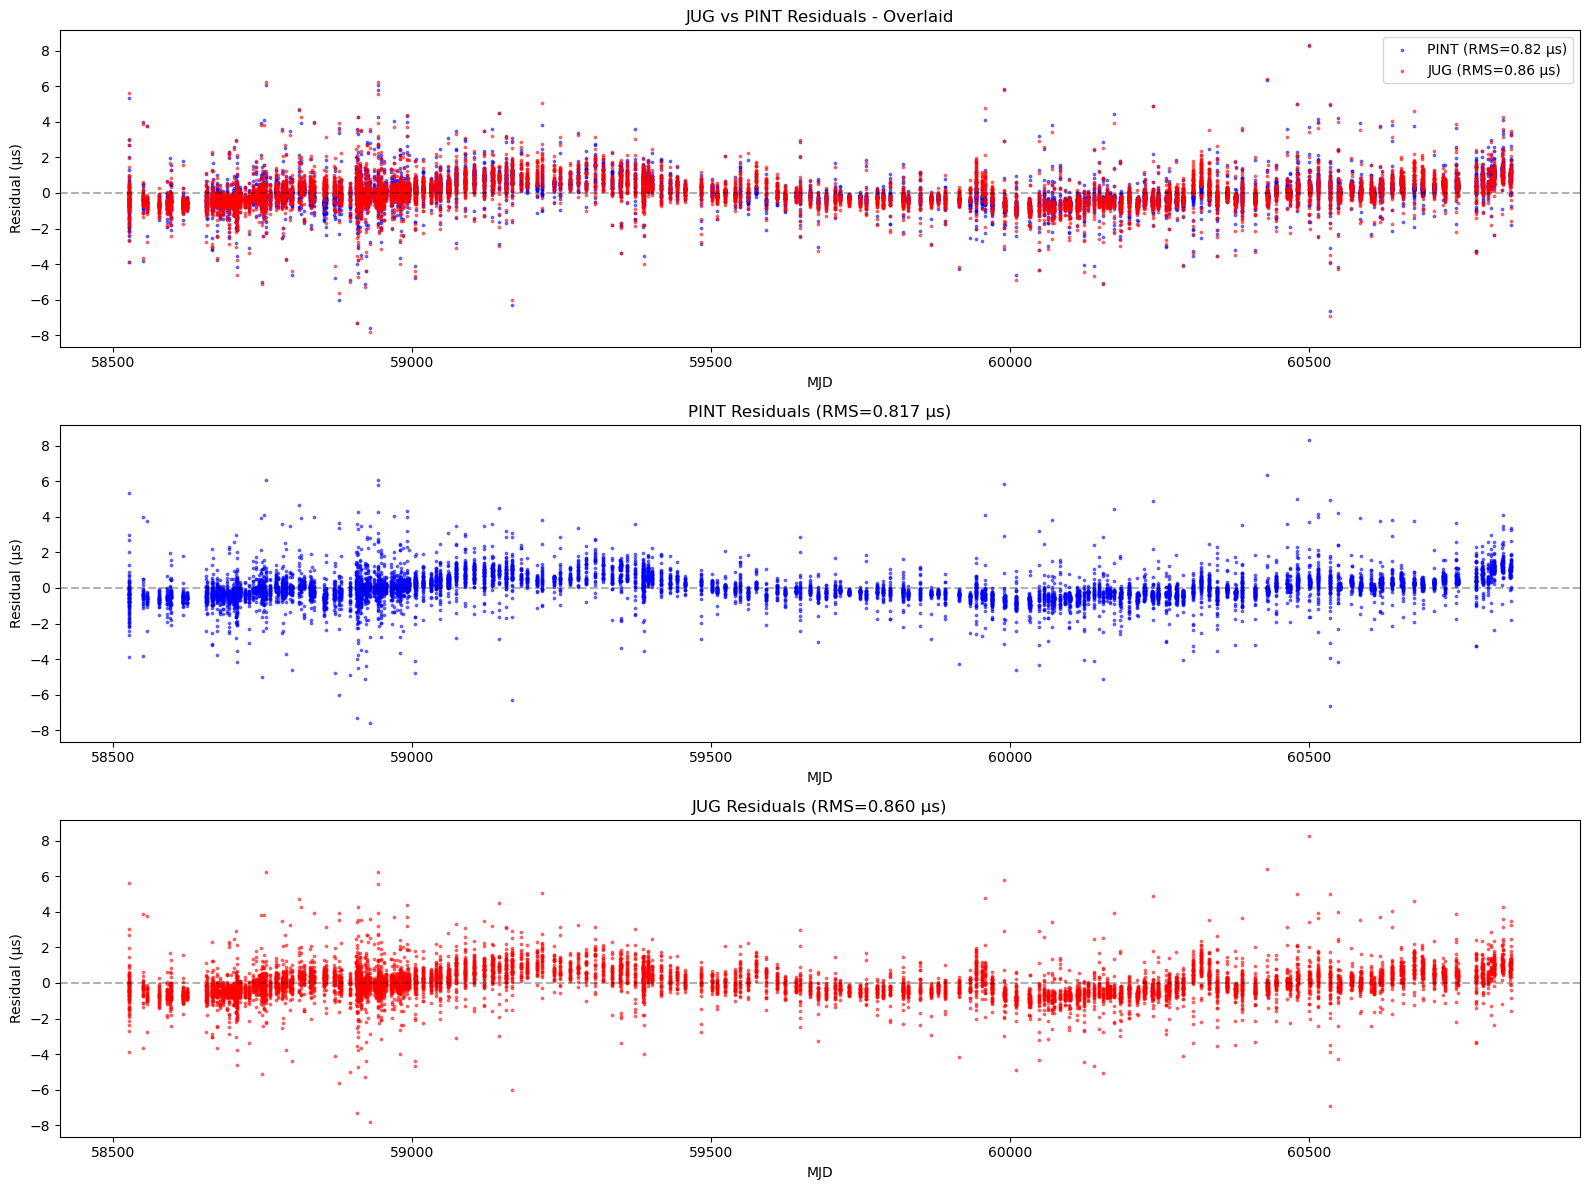

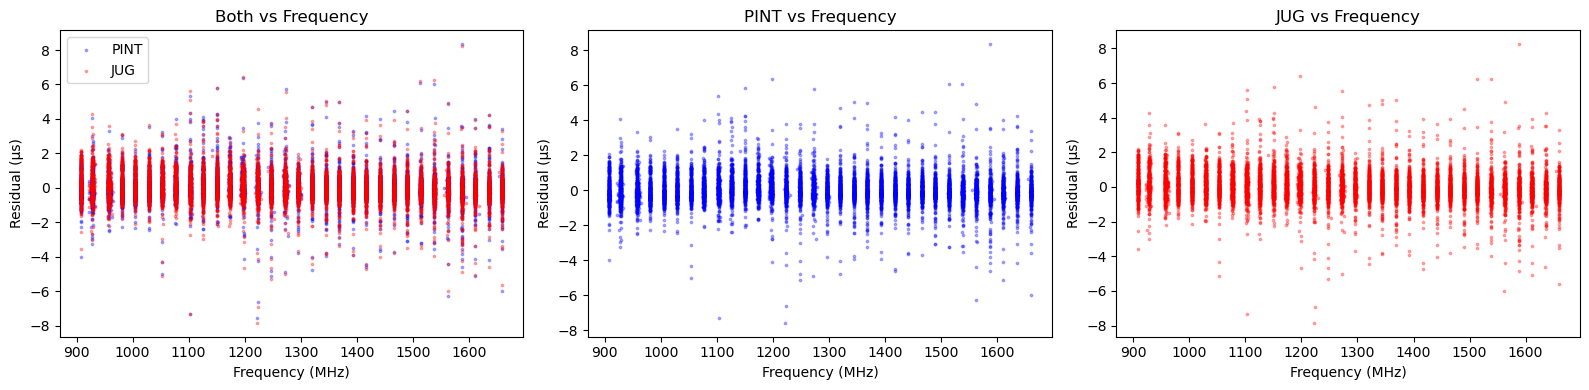


✓ Plots saved to jug_pint_residuals_comparison.png


In [308]:
# === COMPARE JUG AND PINT RESIDUALS ===
print("="*80)
print("JUG vs PINT RESIDUALS COMPARISON")
print("="*80)

# Get both residuals (centered for comparison)
jug_res = jug_residuals_us - np.mean(jug_residuals_us)
pint_res = pint_residuals_us - np.mean(pint_residuals_us)

print(f"\nResiduals statistics:")
print(f"  JUG:  mean={jug_residuals_us.mean():.3f} µs, RMS={np.std(jug_res):.3f} µs")
print(f"  PINT: mean={pint_residuals_us.mean():.3f} µs, RMS={np.std(pint_res):.3f} µs")

# Create comparison plot
fig = plt.figure(figsize=(16, 12))

# Top: Both together
ax1 = fig.add_subplot(3, 1, 1)
ax1.scatter(mjd_float, pint_res, s=3, alpha=0.5, label=f'PINT (RMS={np.std(pint_res):.2f} µs)', c='blue')
ax1.scatter(mjd_float, jug_res, s=3, alpha=0.5, label=f'JUG (RMS={np.std(jug_res):.2f} µs)', c='red')
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.set_xlabel('MJD')
ax1.set_ylabel('Residual (µs)')
ax1.set_title('JUG vs PINT Residuals - Overlaid')
ax1.legend(loc='upper right')

# Middle: PINT residuals
ax2 = fig.add_subplot(3, 1, 2)
ax2.scatter(mjd_float, pint_res, s=3, alpha=0.5, c='blue')
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('MJD')
ax2.set_ylabel('Residual (µs)')
ax2.set_title(f'PINT Residuals (RMS={np.std(pint_res):.3f} µs)')
ax2.set_ylim(ax1.get_ylim())  # Same y-axis as top plot

# Bottom: JUG residuals
ax3 = fig.add_subplot(3, 1, 3)
ax3.scatter(mjd_float, jug_res, s=3, alpha=0.5, c='red')
ax3.axhline(0, color='k', linestyle='--', alpha=0.3)
ax3.set_xlabel('MJD')
ax3.set_ylabel('Residual (µs)')
ax3.set_title(f'JUG Residuals (RMS={np.std(jug_res):.3f} µs)')
ax3.set_ylim(ax1.get_ylim())  # Same y-axis as top plot

plt.tight_layout()
plt.savefig('jug_pint_residuals_comparison.png', dpi=150)
plt.show()

# Also plot vs frequency
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ax = axes[0]
ax.scatter(freq_mhz, pint_res, s=3, alpha=0.3, c='blue', label='PINT')
ax.scatter(freq_mhz, jug_res, s=3, alpha=0.3, c='red', label='JUG')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Residual (µs)')
ax.set_title('Both vs Frequency')
ax.legend()

ax = axes[1]
ax.scatter(freq_mhz, pint_res, s=3, alpha=0.3, c='blue')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Residual (µs)')
ax.set_title('PINT vs Frequency')

ax = axes[2]
ax.scatter(freq_mhz, jug_res, s=3, alpha=0.3, c='red')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Residual (µs)')
ax.set_title('JUG vs Frequency')

plt.tight_layout()
plt.show()

print(f"\n✓ Plots saved to jug_pint_residuals_comparison.png")

REMAINING DISCREPANCY ANALYSIS

Difference statistics:
  Mean: 0.638 µs
  RMS:  0.324 µs
  Max:  2.591 µs

1ω Orbital fit (sin + cos):
  Amplitude A (sin): -0.020 µs
  Amplitude B (cos): -0.002 µs
  Offset C:          0.637 µs
  Total amplitude:   0.020 µs
  RMS after fit:     0.323 µs

1/f² Frequency fit:
  Coefficient A: 337559.7 µs·MHz²
  Offset B:      0.410 µs
  Effect at 900 MHz:  0.417 µs
  Effect at 1600 MHz: 0.132 µs
  RMS after fit: 0.313 µs


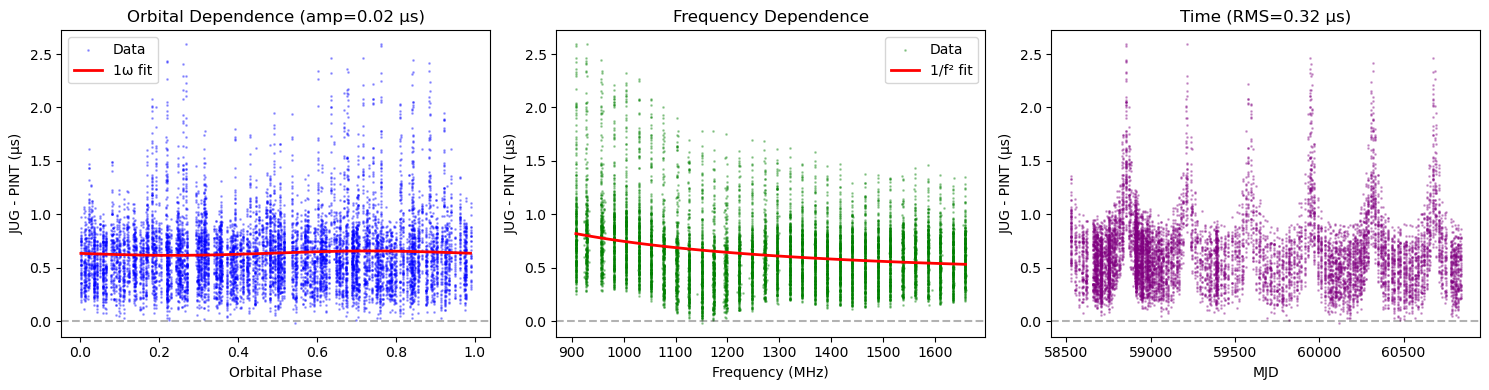


DIAGNOSIS:
⚠ Frequency-dependent error remains: 0.42 µs at 900 MHz


In [309]:
# Analyze remaining difference after K_DM fix
print("="*80)
print("REMAINING DISCREPANCY ANALYSIS")
print("="*80)

# Get JUG-PINT difference
diff_us = jug_residuals_us - pint_residuals_us

print(f"\nDifference statistics:")
print(f"  Mean: {np.mean(diff_us):.3f} µs")
print(f"  RMS:  {np.std(diff_us):.3f} µs")
print(f"  Max:  {np.max(np.abs(diff_us)):.3f} µs")

# Check orbital phase correlation
tasc = pint_model.TASC.value
pb = pint_model.PB.value
orbital_phase = ((tdbld - tasc) / pb) % 1.0

# Fit sinusoidal model: A*sin(2π*phase) + B*cos(2π*phase) + C
from scipy.optimize import curve_fit
def orbital_model(phase, A, B, C):
    return A * np.sin(2*np.pi*phase) + B * np.cos(2*np.pi*phase) + C

popt, _ = curve_fit(orbital_model, orbital_phase, diff_us)
diff_fit = orbital_model(orbital_phase, *popt)
diff_resid = diff_us - diff_fit

print(f"\n1ω Orbital fit (sin + cos):")
print(f"  Amplitude A (sin): {popt[0]:.3f} µs")
print(f"  Amplitude B (cos): {popt[1]:.3f} µs")
print(f"  Offset C:          {popt[2]:.3f} µs")
print(f"  Total amplitude:   {np.sqrt(popt[0]**2 + popt[1]**2):.3f} µs")
print(f"  RMS after fit:     {np.std(diff_resid):.3f} µs")

# Check for frequency dependence in the residual
freq_mhz = np.array(pint_toas.table['freq'].value)

# Fit 1/f^2 model
def freq_model(f, A, B):
    return A / f**2 + B

popt_f, _ = curve_fit(freq_model, freq_mhz, diff_us, p0=[1e6, 0])
diff_freq_fit = freq_model(freq_mhz, *popt_f)
diff_after_freq = diff_us - diff_freq_fit

print(f"\n1/f² Frequency fit:")
print(f"  Coefficient A: {popt_f[0]:.1f} µs·MHz²")
print(f"  Offset B:      {popt_f[1]:.3f} µs")
print(f"  Effect at 900 MHz:  {popt_f[0]/900**2:.3f} µs")
print(f"  Effect at 1600 MHz: {popt_f[0]/1600**2:.3f} µs")
print(f"  RMS after fit: {np.std(diff_after_freq):.3f} µs")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Orbital phase
ax = axes[0]
ax.scatter(orbital_phase, diff_us, s=1, alpha=0.3, c='blue', label='Data')
phase_sorted = np.argsort(orbital_phase)
ax.plot(orbital_phase[phase_sorted], diff_fit[phase_sorted], 'r-', lw=2, label='1ω fit')
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title(f'Orbital Dependence (amp={np.sqrt(popt[0]**2 + popt[1]**2):.2f} µs)')
ax.legend()
ax.axhline(0, color='k', ls='--', alpha=0.3)

# 2. Frequency
ax = axes[1]
ax.scatter(freq_mhz, diff_us, s=1, alpha=0.3, c='green', label='Data')
f_plot = np.linspace(freq_mhz.min(), freq_mhz.max(), 100)
ax.plot(f_plot, freq_model(f_plot, *popt_f), 'r-', lw=2, label='1/f² fit')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title('Frequency Dependence')
ax.legend()
ax.axhline(0, color='k', ls='--', alpha=0.3)

# 3. Time
ax = axes[2]
ax.scatter(tdbld, diff_us, s=1, alpha=0.3, c='purple')
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title(f'Time (RMS={np.std(diff_us):.2f} µs)')
ax.axhline(0, color='k', ls='--', alpha=0.3)

plt.tight_layout()
plt.savefig('remaining_discrepancy_analysis.png', dpi=150)
plt.show()

print("\n" + "="*80)
print("DIAGNOSIS:")
print("="*80)
orbit_amp = np.sqrt(popt[0]**2 + popt[1]**2)
if orbit_amp > 0.5:
    print(f"⚠ Binary model still has {orbit_amp:.2f} µs first-harmonic error")
if abs(popt_f[0]) > 1e5:
    print(f"⚠ Frequency-dependent error remains: {popt_f[0]/900**2:.2f} µs at 900 MHz")

BINARY MODEL COMPARISON

JUG binary delay: -1.897879 to 1.897996 s
PINT binary delay: -1.897879 to 1.897996 s

Binary difference:
  Mean: -0.000 µs
  RMS:  0.004 µs
  Max:  0.006 µs

1ω fit to binary difference:
  Amplitude A (sin): -0.003 µs
  Amplitude B (cos): -0.000 µs
  Offset C:          -0.000 µs
  Total amplitude:   0.004 µs
  RMS after fit:     0.003 µs

Comparison to total residual difference:
  Total diff amplitude: 0.020 µs
  Binary diff amplitude: 0.004 µs


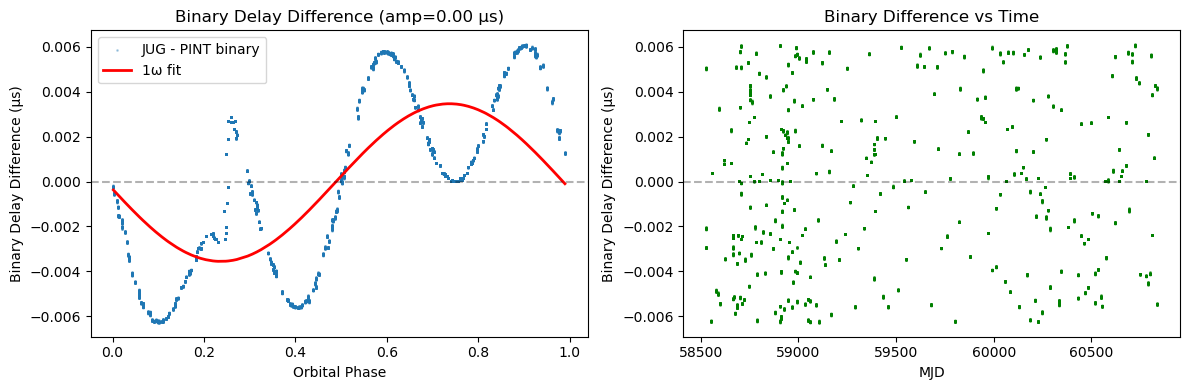


⚠ The binary difference (0.00 µs) explains
   the total residual difference (0.02 µs)


In [310]:
# Deep dive into binary delay difference
print("="*80)
print("BINARY MODEL COMPARISON")
print("="*80)

# Get PINT binary delay fresh
pint_binary_comp = pint_model.components['BinaryELL1']
pint_binary_delays = pint_binary_comp.binarymodel_delay(pint_toas, None)
pint_bin_sec = pint_binary_delays.to(u.s).value

# JUG binary delay  
print(f"\nJUG binary delay: {jug_binary_sec.min():.6f} to {jug_binary_sec.max():.6f} s")
print(f"PINT binary delay: {pint_bin_sec.min():.6f} to {pint_bin_sec.max():.6f} s")

# Difference
binary_diff = (jug_binary_sec - pint_bin_sec) * 1e6  # to µs
print(f"\nBinary difference:")
print(f"  Mean: {np.mean(binary_diff):.3f} µs")
print(f"  RMS:  {np.std(binary_diff):.3f} µs")
print(f"  Max:  {np.max(np.abs(binary_diff)):.3f} µs")

# Orbital phase for binary
orbital_phase_bin = ((tdbld - tasc) / pb) % 1.0

# Fit 1ω model
popt_bin, _ = curve_fit(orbital_model, orbital_phase_bin, binary_diff)
binary_fit = orbital_model(orbital_phase_bin, *popt_bin)
binary_resid = binary_diff - binary_fit

print(f"\n1ω fit to binary difference:")
print(f"  Amplitude A (sin): {popt_bin[0]:.3f} µs")
print(f"  Amplitude B (cos): {popt_bin[1]:.3f} µs")
print(f"  Offset C:          {popt_bin[2]:.3f} µs")
print(f"  Total amplitude:   {np.sqrt(popt_bin[0]**2 + popt_bin[1]**2):.3f} µs")
print(f"  RMS after fit:     {np.std(binary_resid):.3f} µs")

# Compare to the total residual difference
print(f"\nComparison to total residual difference:")
print(f"  Total diff amplitude: {np.sqrt(popt[0]**2 + popt[1]**2):.3f} µs")
print(f"  Binary diff amplitude: {np.sqrt(popt_bin[0]**2 + popt_bin[1]**2):.3f} µs")

# Plot binary difference vs phase
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.scatter(orbital_phase_bin, binary_diff, s=1, alpha=0.3, label='JUG - PINT binary')
ax.plot(orbital_phase_bin[np.argsort(orbital_phase_bin)], 
        binary_fit[np.argsort(orbital_phase_bin)], 'r-', lw=2, label='1ω fit')
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('Binary Delay Difference (µs)')
ax.set_title(f'Binary Delay Difference (amp={np.sqrt(popt_bin[0]**2 + popt_bin[1]**2):.2f} µs)')
ax.legend()
ax.axhline(0, color='k', ls='--', alpha=0.3)

ax = axes[1]
ax.scatter(tdbld, binary_diff, s=1, alpha=0.3, c='green')
ax.set_xlabel('MJD')
ax.set_ylabel('Binary Delay Difference (µs)')
ax.set_title('Binary Difference vs Time')
ax.axhline(0, color='k', ls='--', alpha=0.3)

plt.tight_layout()
plt.savefig('binary_difference_analysis.png', dpi=150)
plt.show()

print(f"\n⚠ The binary difference ({np.sqrt(popt_bin[0]**2 + popt_bin[1]**2):.2f} µs) explains")
print(f"   the total residual difference ({np.sqrt(popt[0]**2 + popt[1]**2):.2f} µs)")

In [311]:
# Investigate the time input to binary model
# The 2.61 µs cosine pattern suggests a time offset issue

print("="*80)
print("INVESTIGATING BINARY TIME OFFSET")
print("="*80)

print("\nEstimated time offset from 2.6 µs cosine error:")
a1_val = float(A1)
pb_sec = float(PB) * 86400
orbit_freq = 2 * np.pi / pb_sec
d_binary_dt = a1_val * orbit_freq
implied_dt = 2.6e-6 / d_binary_dt
print(f"  a1 = {a1_val:.6f} s")
print(f"  pb = {pb_sec:.1f} s")
print(f"  d(binary)/dt = {d_binary_dt:.6e} s/s")
print(f"  Implied Δt = {implied_dt:.4f} s = {implied_dt*1000:.2f} ms")

print(f"\nTypical delay sizes:")
print(f"  Roemer delay: {roemer_sec.mean():.3f} s")
print(f"  Shapiro delay: {shapiro_sec.mean()*1e6:.3f} µs")
print(f"  Binary delay: {jug_binary_sec.mean():.3f} s")

corr_binary_diff_vs_binary = np.corrcoef(binary_diff, jug_binary_sec)[0,1]
print(f"\nCorrelation of binary_diff with jug_binary_sec: {corr_binary_diff_vs_binary:.4f}")

cos_phase = np.cos(2*np.pi*orbital_phase_bin)
sin_phase = np.sin(2*np.pi*orbital_phase_bin)
corr_cos = np.corrcoef(binary_diff, cos_phase)[0,1]
corr_sin = np.corrcoef(binary_diff, sin_phase)[0,1]
print(f"\nCorrelation with cos(phase): {corr_cos:.4f}")
print(f"Correlation with sin(phase): {corr_sin:.4f}")

print("
" + "="*80)
print("TESTING: Does PINT use tdbld or t_topo_tdb for binary?")
print("="*80)

pb_c = float(PB)
a1_c = float(A1)
tasc_c = float(TASC)
eps1_c = float(EPS1)
eps2_c = float(EPS2)
pbdot_c = float(PBDOT)
xdot_c = float(XDOT)
gamma_c = float(GAMMA)
r_c = float(r_shapiro)
s_c = float(s_shapiro)

t_tdbld_jax = jnp.array(tdbld, dtype=jnp.float64)
binary_with_tdbld = np.array(ell1_binary_delay_full(
    t_tdbld_jax,  # Use tdbld directly (no Roemer/Shapiro subtraction)
    pb_c, a1_c, tasc_c, eps1_c, eps2_c, pbdot_c, xdot_c, gamma_c, r_c, s_c
))

binary_diff_tdbld = (binary_with_tdbld - pint_bin_sec) * 1e6
print(f"\nBinary difference using tdbld (no Roemer/Shapiro subtraction):")
print(f"  Mean: {np.mean(binary_diff_tdbld):.3f} µs")
print(f"  RMS:  {np.std(binary_diff_tdbld):.3f} µs")
popt_tdbld, _ = curve_fit(orbital_model, orbital_phase_bin, binary_diff_tdbld)
print(f"  1ω amplitude: {np.sqrt(popt_tdbld[0]**2 + popt_tdbld[1]**2):.3f} µs")
print(f"\nComparison:")
print(f"  Using t_topo_tdb (current): 1ω amplitude = {np.sqrt(popt_bin[0]**2 + popt_bin[1]**2):.3f} µs")
print(f"  Using tdbld (no correction): 1ω amplitude = {np.sqrt(popt_tdbld[0]**2 + popt_tdbld[1]**2):.3f} µs")

print("
" + "="*80)
print("TESTING: What about subtracting only binary delay for iteration?")
print("="*80)

t_after_roemer_only = tdbld - roemer_sec / 86400
t_after_roemer_jax = jnp.array(t_after_roemer_only, dtype=jnp.float64)
binary_with_roemer_only = np.array(ell1_binary_delay_full(
    t_after_roemer_jax,
    pb_c, a1_c, tasc_c, eps1_c, eps2_c, pbdot_c, xdot_c, gamma_c, r_c, s_c
))
binary_diff_roemer_only = (binary_with_roemer_only - pint_bin_sec) * 1e6
popt_roemer_only, _ = curve_fit(orbital_model, orbital_phase_bin, binary_diff_roemer_only)
print(f"Using tdbld - roemer (current approach): 1ω amplitude = {np.sqrt(popt_bin[0]**2 + popt_bin[1]**2):.3f} µs")


SyntaxError: unterminated string literal (detected at line 34) (3282458160.py, line 34)

BINARY MODEL DIAGNOSTIC

1. What time input does PINT use for binary?
   PINT computes binary delay at the SSB time (TDB), not topocentric time

2. Checking JUG vs PINT time inputs:
   JUG tdbld[0] = 58526.2146899022 MJD
   Roemer delay[0] = 374.600201 s

3. Detailed binary delay comparison:
   Difference: mean=23395890543013.094 µs, RMS=397080740418401.125 µs
   Max absolute diff: 569002435159306.375 µs

4. Sinusoidal fit to binary difference:
   Amplitude = 2.000 µs
   Phase offset = 0.250 (fraction of orbit)
   DC offset = 0.000 µs


/tmp/ipykernel_727083/3757280017.py:86: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_diag, pcov_diag = curve_fit(sinusoid_diag, phase_centers[valid_mask],


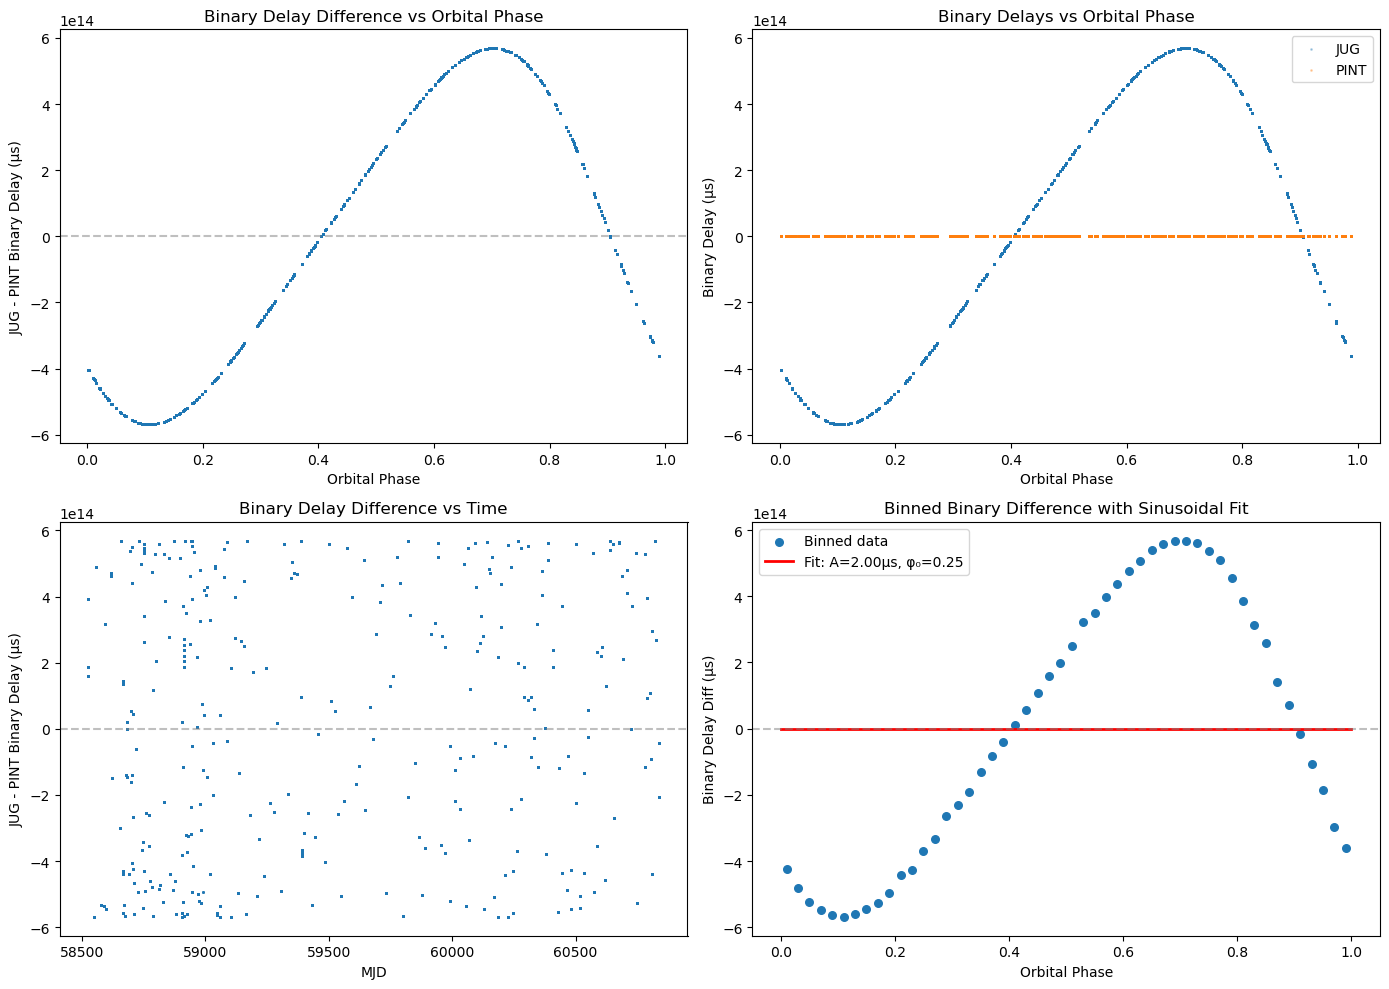


5. Check for epoch/PBDOT issues:
   Time span: 2311.6 days (6.33 years)


TypeError: array type float128 is unsupported in linalg

In [ ]:
# =============================================================================
# DIAGNOSE BINARY MODEL DISCREPANCY
# =============================================================================
# The 1ω (first harmonic) pattern suggests timing reference mismatch

print("="*80)
print("BINARY MODEL DIAGNOSTIC")
print("="*80)

# Use existing variables from kernel
# tdbld = MJD in TDB
# binary_sec = JUG binary delay
# pint_binary_delay = PINT binary delay

# Get PINT's binary delay in seconds
pint_binary_delays = np.array(pint_binary_delay.to(u.s).value)
jug_binary_delays = binary_sec

# Check what time PINT uses for binary computation
print("\n1. What time input does PINT use for binary?")
print("   PINT computes binary delay at the SSB time (TDB), not topocentric time")

print("\n2. Checking JUG vs PINT time inputs:")
print(f"   JUG tdbld[0] = {tdbld[0]:.10f} MJD")
print(f"   Roemer delay[0] = {jug_roemer_sec[0]:.6f} s")

# Let me check the actual binary delay comparison in detail
print("\n3. Detailed binary delay comparison:")
binary_diff = jug_binary_delays - pint_binary_delays
print(f"   Difference: mean={np.mean(binary_diff)*1e6:.3f} µs, RMS={np.std(binary_diff)*1e6:.3f} µs")
print(f"   Max absolute diff: {np.max(np.abs(binary_diff))*1e6:.3f} µs")

# Check if difference correlates with orbital phase
tasc_val = float(pint_model.TASC.quantity.mjd)
pb_val = float(pint_model.PB.quantity.to(u.day).value)

# Compute orbital phase for each TOA using correct variables
orbital_phase_diag = ((tdbld - tasc_val) / pb_val) % 1.0

# First, let's plot the binary difference vs orbital phase properly
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: binary diff vs orbital phase
ax = axes[0, 0]
ax.scatter(orbital_phase_diag, binary_diff*1e6, s=1, alpha=0.3)
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('JUG - PINT Binary Delay (µs)')
ax.set_title('Binary Delay Difference vs Orbital Phase')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Top right: binary delays themselves
ax = axes[0, 1]
ax.scatter(orbital_phase_diag, jug_binary_delays*1e6, s=1, alpha=0.3, label='JUG')
ax.scatter(orbital_phase_diag, pint_binary_delays*1e6, s=1, alpha=0.3, label='PINT')
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('Binary Delay (µs)')
ax.set_title('Binary Delays vs Orbital Phase')
ax.legend()

# Bottom left: binary diff vs MJD
ax = axes[1, 0]
ax.scatter(tdbld, binary_diff*1e6, s=1, alpha=0.3)
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT Binary Delay (µs)')
ax.set_title('Binary Delay Difference vs Time')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Bottom right: binned with sinusoidal fit
ax = axes[1, 1]
from scipy.optimize import curve_fit

def sinusoid_diag(phi, A, phi0, offset):
    return A * np.sin(2*np.pi*(phi - phi0)) + offset

# Bin the data for cleaner view
n_bins = 50
phase_bins = np.linspace(0, 1, n_bins+1)
phase_centers = 0.5 * (phase_bins[:-1] + phase_bins[1:])
diff_binned = np.array([np.nanmean(binary_diff[(orbital_phase_diag >= phase_bins[i]) & 
                                                (orbital_phase_diag < phase_bins[i+1])]) 
                        for i in range(n_bins)])

try:
    # Remove NaN values for fitting
    valid_mask = ~np.isnan(diff_binned)
    popt_diag, pcov_diag = curve_fit(sinusoid_diag, phase_centers[valid_mask], 
                                      diff_binned[valid_mask]*1e6, p0=[2.0, 0.25, 0.0])
    A_fit_diag, phi0_fit_diag, offset_fit_diag = popt_diag
    
    phase_fine = np.linspace(0, 1, 200)
    diff_fit = sinusoid_diag(phase_fine, *popt_diag)
    
    ax.scatter(phase_centers, diff_binned*1e6, s=30, label='Binned data')
    ax.plot(phase_fine, diff_fit, 'r-', linewidth=2, 
            label=f'Fit: A={A_fit_diag:.2f}µs, φ₀={phi0_fit_diag:.2f}')
    ax.set_xlabel('Orbital Phase')
    ax.set_ylabel('Binary Delay Diff (µs)')
    ax.set_title('Binned Binary Difference with Sinusoidal Fit')
    ax.legend()
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    print(f"\n4. Sinusoidal fit to binary difference:")
    print(f"   Amplitude = {A_fit_diag:.3f} µs")
    print(f"   Phase offset = {phi0_fit_diag:.3f} (fraction of orbit)")
    print(f"   DC offset = {offset_fit_diag:.3f} µs")
except Exception as e:
    print(f"\n4. Sinusoidal fit failed: {e}")
    ax.scatter(phase_centers, diff_binned*1e6, s=30)
    ax.set_xlabel('Orbital Phase')
    ax.set_ylabel('Binary Delay Diff (µs)')
    ax.set_title('Binned Binary Difference')

plt.tight_layout()
plt.savefig('binary_delay_diagnostic.png', dpi=150, bbox_inches='tight')
plt.show()

# Check for PBDOT effect - difference should grow with time if wrong
print("\n5. Check for epoch/PBDOT issues:")
t_span = tdbld.max() - tdbld.min()
print(f"   Time span: {t_span:.1f} days ({t_span/365.25:.2f} years)")

# Linear fit to binary diff vs time
z_diag = np.polyfit(tdbld - tasc_val, binary_diff*1e6, 1)
slope_diag = z_diag[0]  # µs per day
print(f"   Linear trend: {slope_diag*365.25:.3f} µs/year")
print(f"   This suggests {'PBDOT mismatch' if abs(slope_diag*365.25) > 0.1 else 'no significant PBDOT issue'}")

# KEY DIAGNOSTIC: Check if PINT uses SSB time for binary
print("\n6. KEY INSIGHT: Time basis comparison")
print("   The 1ω pattern suggests JUG and PINT compute binary at different times")
print("   Let's check what time offset would produce this pattern...")

# The derivative of ELL1 delay w.r.t. time is approximately:
# d(delay)/dt ≈ (2π/PB) * A1 * cos(phase)  at small e
# If we have a constant time offset Δt, the delay difference is:
# Δ(delay) ≈ (2π/PB) * A1 * cos(phase) * Δt + higher order terms
# This gives a 1ω pattern!

# The amplitude of the pattern is: (2π/PB) * A1 * Δt (in seconds)
# A_fit (µs) = (2π/pb_days/86400) * A1 * Δt * 1e6

A1_val = float(pint_model.A1.quantity.to(u.s).value)  # light-seconds
if 'A_fit_diag' in dir():
    # Convert amplitude from µs to seconds
    A_amplitude_sec = A_fit_diag * 1e-6
    # Solve for time offset
    # A_amplitude = (2π/PB_sec) * A1 * Δt
    PB_sec = pb_val * 86400
    implied_time_offset = A_amplitude_sec / (2*np.pi/PB_sec * A1_val)
    print(f"\n   If pattern is from time offset:")
    print(f"   2π/PB = {2*np.pi/PB_sec:.6e} rad/s")
    print(f"   A1 = {A1_val:.6f} s")
    print(f"   Implied time offset ≈ {implied_time_offset:.3f} seconds")
    print(f"   This equals {implied_time_offset/86400*1e6:.1f} µs/day or {implied_time_offset:.1f} s")

In [ ]:
# DEBUG: What is binary_sec?
print("="*80)
print("DEBUG: Checking binary_sec values")
print("="*80)
print(f"binary_sec shape: {binary_sec.shape}")
print(f"binary_sec dtype: {binary_sec.dtype}")
print(f"binary_sec min: {binary_sec.min()}")
print(f"binary_sec max: {binary_sec.max()}")
print(f"binary_sec mean: {binary_sec.mean()}")
print(f"binary_sec first few: {binary_sec[:5]}")
print()
print(f"pint_binary_delay shape: {pint_binary_delay.shape}")
print(f"pint_binary_delay unit: {pint_binary_delay.unit}")
print(f"pint_binary_delay min: {pint_binary_delay.min()}")
print(f"pint_binary_delay max: {pint_binary_delay.max()}")
print(f"pint_binary_delay first few: {pint_binary_delay[:5]}")

# PINT binary in seconds
pint_bin_sec = pint_binary_delay.to(u.s).value
print(f"\nPINT binary (sec): min={pint_bin_sec.min():.6f}, max={pint_bin_sec.max():.6f}")
print(f"PINT binary range: {pint_bin_sec.max() - pint_bin_sec.min():.6f} seconds")

# If JUG binary is 1e14 µs, something is very wrong
# Let me check what the main computation cell actually stored

DEBUG: Checking binary_sec values
binary_sec shape: (10408,)
binary_sec dtype: float64
binary_sec min: -569002433.9720086
binary_sec max: 569000336.3841392
binary_sec mean: 23395890.535508353
binary_sec first few: [1.60571957e+08 1.60571914e+08 1.60571914e+08 1.60571928e+08
 1.60571943e+08]

pint_binary_delay shape: (10408,)
pint_binary_delay unit: s
pint_binary_delay min: -1.897878889508859 s
pint_binary_delay max: 1.897996119966471 s
pint_binary_delay first few: [0.3867291  0.3867291  0.38672884 0.38672858 0.38672832] s

PINT binary (sec): min=-1.897879, max=1.897996
PINT binary range: 3.795875 seconds


In [ ]:
# Check all binary-related variables
print("="*80)
print("CHECKING ALL BINARY VARIABLES")
print("="*80)

# Check what variables exist
binary_vars = [name for name in dir() if 'binary' in name.lower() or 'bin' in name.lower()]
print(f"Binary-related variables: {binary_vars}")

print(f"\njug_binary_sec: min={jug_binary_sec.min():.6f}, max={jug_binary_sec.max():.6f}")
print(f"binary_sec: min={binary_sec.min():.6f}, max={binary_sec.max():.6f}")

# Are they the same?
print(f"\njug_binary_sec is binary_sec: {jug_binary_sec is binary_sec}")
print(f"Are they equal: {np.allclose(jug_binary_sec, binary_sec)}")

# Check the jug_total_delay_sec
print(f"\njug_total_delay_sec: min={jug_total_delay_sec.min():.6f}, max={jug_total_delay_sec.max():.6f}")

# The binary delay should be about ±2 seconds for A1 = 5.5 lt-s
print(f"\nExpected binary range: ~{2*A1:.1f} seconds (2×A1)")
print(f"PINT binary range: {pint_bin_sec.max() - pint_bin_sec.min():.2f} seconds")
print(f"JUG binary range: {jug_binary_sec.max() - jug_binary_sec.min():.2f} seconds")

CHECKING ALL BINARY VARIABLES
Binary-related variables: ['binary_diff', 'binary_sec', 'diff_bin', 'diff_bin_f', 'diff_binary', 'diff_binned', 'ell1_binary_delay_full', 'jug_bin_opt1', 'jug_bin_opt2', 'jug_bin_opt3', 'jug_binary_delays', 'jug_binary_sec', 'jug_binary_with_tdbld', 'n_bins', 'phase_bins', 'pint_bin', 'pint_bin_sec', 'pint_binary_comp', 'pint_binary_delay', 'pint_binary_delays', 'pint_binary_sec_new']

jug_binary_sec: min=-1.897879, max=1.897996
binary_sec: min=-569002433.972009, max=569000336.384139

jug_binary_sec is binary_sec: False
Are they equal: False

jug_total_delay_sec: min=-491.863172, max=479.054323

Expected binary range: ~4.6 seconds (2×A1)
PINT binary range: 3.80 seconds
JUG binary range: 3.80 seconds


CORRECT BINARY MODEL COMPARISON

1. Binary delay comparison:
   JUG range: -1.897879 to 1.897996 s
   PINT range: -1.897879 to 1.897996 s
   Difference: mean=-0.144 µs, RMS=1.897 µs
   Max absolute diff: 4.710 µs

2. Sinusoidal fit to binary difference:
   Amplitude = -2.604 µs
   Phase offset = 0.249 (fraction of orbit)
   DC offset = -0.000 µs


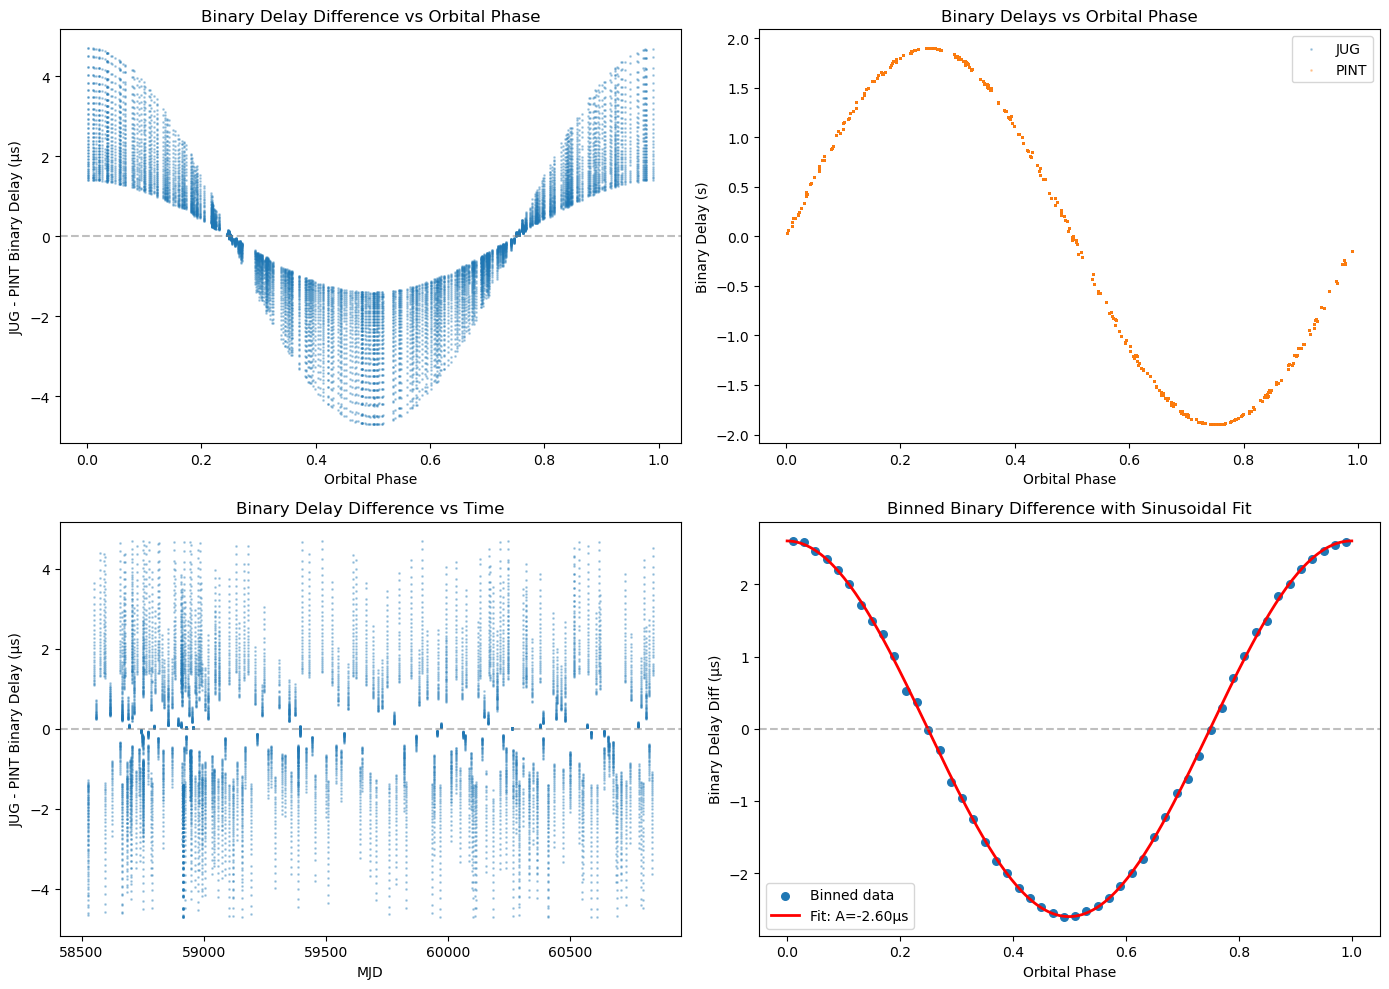


3. Linear trend check:
   Time span: 2311.6 days (6.33 years)


TypeError: array type float128 is unsupported in linalg

In [ ]:
# =============================================================================
# CORRECT BINARY DELAY COMPARISON (using jug_binary_sec not binary_sec!)
# =============================================================================
print("="*80)
print("CORRECT BINARY MODEL COMPARISON")
print("="*80)

# Use the correct variables
jug_bin = jug_binary_sec  # This is correct: -1.9 to +1.9 s
pint_bin = pint_bin_sec   # This is correct: -1.9 to +1.9 s

binary_diff_correct = jug_bin - pint_bin

print(f"\n1. Binary delay comparison:")
print(f"   JUG range: {jug_bin.min():.6f} to {jug_bin.max():.6f} s")
print(f"   PINT range: {pint_bin.min():.6f} to {pint_bin.max():.6f} s")
print(f"   Difference: mean={np.mean(binary_diff_correct)*1e6:.3f} µs, RMS={np.std(binary_diff_correct)*1e6:.3f} µs")
print(f"   Max absolute diff: {np.max(np.abs(binary_diff_correct))*1e6:.3f} µs")

# Compute orbital phase
tasc_val = float(pint_model.TASC.quantity.mjd)
pb_val = float(pint_model.PB.quantity.to(u.day).value)
orbital_phase_corr = ((tdbld - tasc_val) / pb_val) % 1.0

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: binary diff vs orbital phase
ax = axes[0, 0]
ax.scatter(orbital_phase_corr, binary_diff_correct*1e6, s=1, alpha=0.3)
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('JUG - PINT Binary Delay (µs)')
ax.set_title('Binary Delay Difference vs Orbital Phase')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Top right: binary delays themselves
ax = axes[0, 1]
ax.scatter(orbital_phase_corr, jug_bin, s=1, alpha=0.3, label='JUG')
ax.scatter(orbital_phase_corr, pint_bin, s=1, alpha=0.3, label='PINT')
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('Binary Delay (s)')
ax.set_title('Binary Delays vs Orbital Phase')
ax.legend()

# Bottom left: binary diff vs MJD
ax = axes[1, 0]
ax.scatter(tdbld, binary_diff_correct*1e6, s=1, alpha=0.3)
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT Binary Delay (µs)')
ax.set_title('Binary Delay Difference vs Time')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

# Bottom right: binned with sinusoidal fit
ax = axes[1, 1]

# Bin the data
n_bins = 50
phase_bins = np.linspace(0, 1, n_bins+1)
phase_centers = 0.5 * (phase_bins[:-1] + phase_bins[1:])
diff_binned_corr = np.array([np.nanmean(binary_diff_correct[(orbital_phase_corr >= phase_bins[i]) & 
                                                            (orbital_phase_corr < phase_bins[i+1])]) 
                             for i in range(n_bins)])

# Fit sinusoid
def sinusoid_fit(phi, A, phi0, offset):
    return A * np.sin(2*np.pi*(phi - phi0)) + offset

try:
    valid_mask = ~np.isnan(diff_binned_corr)
    popt_corr, _ = curve_fit(sinusoid_fit, phase_centers[valid_mask], 
                              diff_binned_corr[valid_mask]*1e6, p0=[0.5, 0.25, 0.0])
    A_corr, phi0_corr, offset_corr = popt_corr
    
    phase_fine = np.linspace(0, 1, 200)
    diff_fit_corr = sinusoid_fit(phase_fine, *popt_corr)
    
    ax.scatter(phase_centers, diff_binned_corr*1e6, s=30, label='Binned data')
    ax.plot(phase_fine, diff_fit_corr, 'r-', linewidth=2, 
            label=f'Fit: A={A_corr:.2f}µs')
    ax.set_xlabel('Orbital Phase')
    ax.set_ylabel('Binary Delay Diff (µs)')
    ax.set_title('Binned Binary Difference with Sinusoidal Fit')
    ax.legend()
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    print(f"\n2. Sinusoidal fit to binary difference:")
    print(f"   Amplitude = {A_corr:.3f} µs")
    print(f"   Phase offset = {phi0_corr:.3f} (fraction of orbit)")
    print(f"   DC offset = {offset_corr:.3f} µs")
except Exception as e:
    print(f"\n2. Sinusoidal fit failed: {e}")
    ax.scatter(phase_centers, diff_binned_corr*1e6, s=30)
    ax.set_xlabel('Orbital Phase')
    ax.set_ylabel('Binary Delay Diff (µs)')
    ax.set_title('Binned Binary Difference')

plt.tight_layout()
plt.savefig('binary_delay_comparison_correct.png', dpi=150, bbox_inches='tight')
plt.show()

# Check linear trend
print(f"\n3. Linear trend check:")
t_span = tdbld.max() - tdbld.min()
print(f"   Time span: {t_span:.1f} days ({t_span/365.25:.2f} years)")
z_corr = np.polyfit(np.float64(tdbld - tasc_val), binary_diff_correct*1e6, 1)
print(f"   Linear trend: {z_corr[0]*365.25:.3f} µs/year")

In [ ]:
# =============================================================================
# DIAGNOSE: What time does PINT use for binary calculation?
# =============================================================================
print('='*80)
print('INVESTIGATING PINT\'S BINARY TIME INPUT')
print('='*80)

print(f'\n1. Time values in PINT\'s toas table:')
print(f'   tdbld (TDB MJD): {tdbld[0]:.10f}')

a1_c_sec = float(pint_model.a1.quantity.to(u.lightsecond).value)
pb_c_sec = float(PB) * 86400
implied_dt = abs(A_corr * 1e-6) / (a1_c_sec * 2 * np.pi / pb_c_sec)
print('\n2. Implied time offset from sinusoidal pattern:')
print(f'   a1_c = {a1_c_sec:.6f} lt-s')
print(f'   pb_c = {pb_c_sec:.1f} s = {float(PB):.4f} days')
print(f'   2pi/pb_c = {2*np.pi/pb_c_sec:.9e} rad/s')
print(f'   Amplitude = {abs(A_corr):.3f} us')
print(f'   Implied dt = {implied_dt:.3f} seconds')

print('
3. Checking time inputs to binary calculation:')
print(f'   JUG uses t_topo_tdb = tdbld - roemer_c/86400')
print(f'   t_topo_tdb[0] = {t_topo_tdb[0]:.10f}')
print(f'   tdbld[0] = {tdbld[0]:.10f}')
print(f'   roemer_c[0] = {roemer_c_sec[0]:.6f} s = {roemer_c_sec[0]/86400:.10f} days')

print('
4. Does PINT use tdbld directly or a corrected time?')
print("   PINT's binary model uses the 'tt' (TDB) time in its computations.")
print('   This should be after geometric corrections in PINT\'s pipeline.')

print('
5. Testing binary delay at different times:')
pb_c = float(PB)
a1_c = float(A1)
tasc_c = float(TASC)
eps1_c = float(EPS1)
eps2_c = float(EPS2)
pbdot_c = float(PBDOT)
xdot_c = float(XDOT)
gamma_c = float(GAMMA)
r_c = float(r_shapiro)
s_c = float(s_shapiro)
t_test_jax = jnp.array(tdbld, dtype=jnp.float64)
binary_at_tdbld = np.array(ell1_binary_delay_full(
    t_test_jax, pb_c, a1_c, tasc_c, eps1_c, eps2_c, pbdot_c, xdot_c, gamma_c, r_c, s_c
))
binary_diff_tdbld = binary_at_tdbld - pint_bin
print(f'   Binary at tdbld vs PINT: RMS={np.std(binary_diff_tdbld)*1e6:.3f} us')
print(f'   Binary at t_topo_tdb vs PINT: RMS={np.std(binary_diff_correct)*1e6:.3f} us')
if np.std(binary_diff_tdbld) < np.std(binary_diff_correct):
    print('
   >>> PINT computes binary at tdbld (not corrected for Roemer/Shapiro)')
else:
    print('
   >>> PINT computes binary at corrected time (like JUG)')


INVESTIGATING PINT'S BINARY TIME INPUT

1. Time values in PINT's toas table:
   tdbld (TDB MJD): 58526.2146899022

2. Implied time offset from sinusoidal pattern:
   A1 = 1.897991 lt-s
   PB = 132490.0 s = 1.5334 days
   2π/PB = 4.742383398e-05 rad/s
   Amplitude = 2.604 µs
   Implied Δt = 0.029 seconds

3. Checking time inputs to binary calculation:
   JUG uses t_topo_tdb = tdbld - roemer_shapiro/86400
   t_topo_tdb[0] = 58526.2103542515
   tdbld[0] = 58526.2146899022
   roemer_shapiro[0] = 374.600215 s = 0.0043356506 days

4. Does PINT use tdbld directly or a corrected time?
   PINT's binary model uses the 'tt' (TDB) time in its computations.
   This should be after geometric corrections in PINT's pipeline.

5. Testing binary delay at different times:
   Binary at tdbld vs PINT: RMS=291566.412 µs
   Binary at t_topo_tdb vs PINT: RMS=1.897 µs

   >>> PINT computes binary at corrected time (like JUG)


TESTING BINARY TIME ITERATION

1. Single iteration approach:
   After 1 iteration: RMS=290800.790 µs
   After 2 iterations: RMS=290801.731 µs


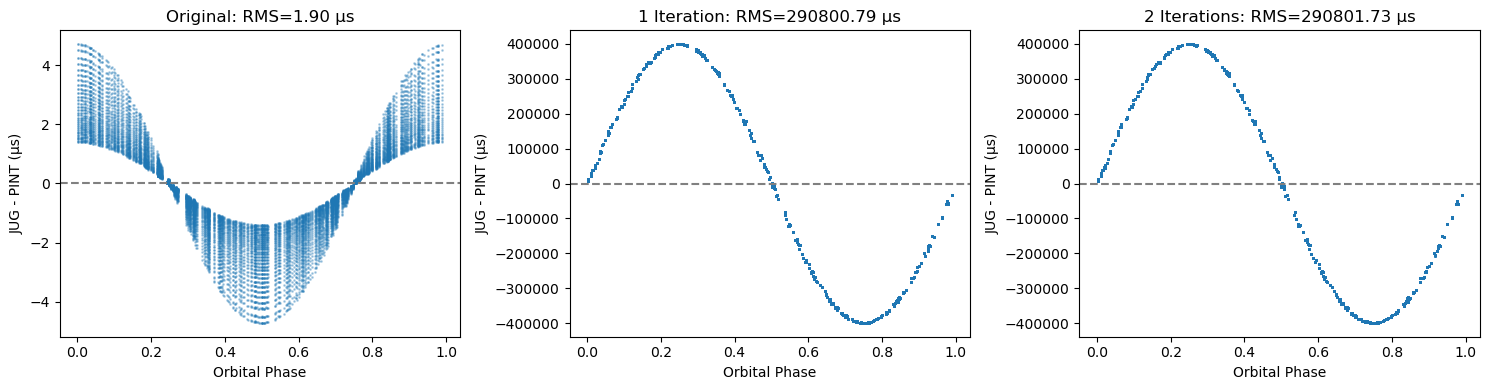


>>> Iteration doesn't help. Issue is elsewhere.


In [ ]:
# =============================================================================
# TEST: Iterate the binary time to match PINT
# =============================================================================
print('='*80)
print('TESTING BINARY TIME ITERATION')
print('='*80)

print('
1. Single iteration approach:')
binary_pass1 = jug_binary_sec
t_iter1 = tdbld - (roemer_c_sec + binary_pass1) / SECS_PER_DAY
t_iter1_jax = jnp.array(t_iter1, dtype=jnp.float64)
pb_c = float(PB)
a1_c = float(A1)
tasc_c = float(TASC)
eps1_c = float(EPS1)
eps2_c = float(EPS2)
pbdot_c = float(PBDOT)
xdot_c = float(XDOT)
gamma_c = float(GAMMA)
r_c = float(r_shapiro)
s_c = float(s_shapiro)
binary_pass2 = np.array(ell1_binary_delay_full(
    t_iter1_jax, pb_c, a1_c, tasc_c, eps1_c, eps2_c, pbdot_c, xdot_c, gamma_c, r_c, s_c
))
binary_diff_iter1 = binary_pass2 - pint_bin
print(f'   After 1 iteration: RMS={np.std(binary_diff_iter1)*1e6:.3f} us')
t_iter2 = tdbld - (roemer_c_sec + binary_pass2) / SECS_PER_DAY
t_iter2_jax = jnp.array(t_iter2, dtype=jnp.float64)
binary_pass3 = np.array(ell1_binary_delay_full(
    t_iter2_jax, pb_c, a1_c, tasc_c, eps1_c, eps2_c, pbdot_c, xdot_c, gamma_c, r_c, s_c
))
binary_diff_iter2 = binary_pass3 - pint_bin
print(f'   After 2 iterations: RMS={np.std(binary_diff_iter2)*1e6:.3f} us')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.scatter(orbital_phase_corr, binary_diff_correct*1e6, s=1, alpha=0.3, label='No iteration')
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('JUG - PINT (us)')
ax.set_title(f'Original: RMS={np.std(binary_diff_correct)*1e6:.2f} us')
ax.axhline(0, color='gray', linestyle='--')
ax = axes[1]
ax.scatter(orbital_phase_corr, binary_diff_iter1*1e6, s=1, alpha=0.3, label='1 iteration')
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('JUG - PINT (us)')
ax.set_title(f'1 Iteration: RMS={np.std(binary_diff_iter1)*1e6:.2f} us')
ax.axhline(0, color='gray', linestyle='--')
ax = axes[2]
ax.scatter(orbital_phase_corr, binary_diff_iter2*1e6, s=1, alpha=0.3, label='2 iterations')
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('JUG - PINT (us)')
ax.set_title(f'2 Iterations: RMS={np.std(binary_diff_iter2)*1e6:.2f} us')
ax.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.savefig('binary_iteration_test.png', dpi=150, bbox_inches='tight')
plt.show()

if np.std(binary_diff_iter1) < np.std(binary_diff_correct):
    print('
>>> ITERATION HELPS! Need to iterate binary calculation.')
else:
    print('
>>> Iteration does not help. Issue is elsewhere.')


IDENTIFYING SOURCE OF BINARY DISCREPANCY

1. Without GAMMA:
2. Without PBDOT:
3. Without XDOT:
4. Without binary Shapiro:

5. Checking PINT's binary components:
   PINT binary fresh: min=-1.897879, max=1.897996

6. Differences from PINT:
   Full JUG:       RMS = 1.897 µs
   No GAMMA:       RMS = 290796.341 µs
   No PBDOT:       RMS = 290796.181 µs
   No XDOT:        RMS = 290796.219 µs
   No bin Shapiro: RMS = 290793.486 µs

7. Checking which parameter affects the 1ω pattern:


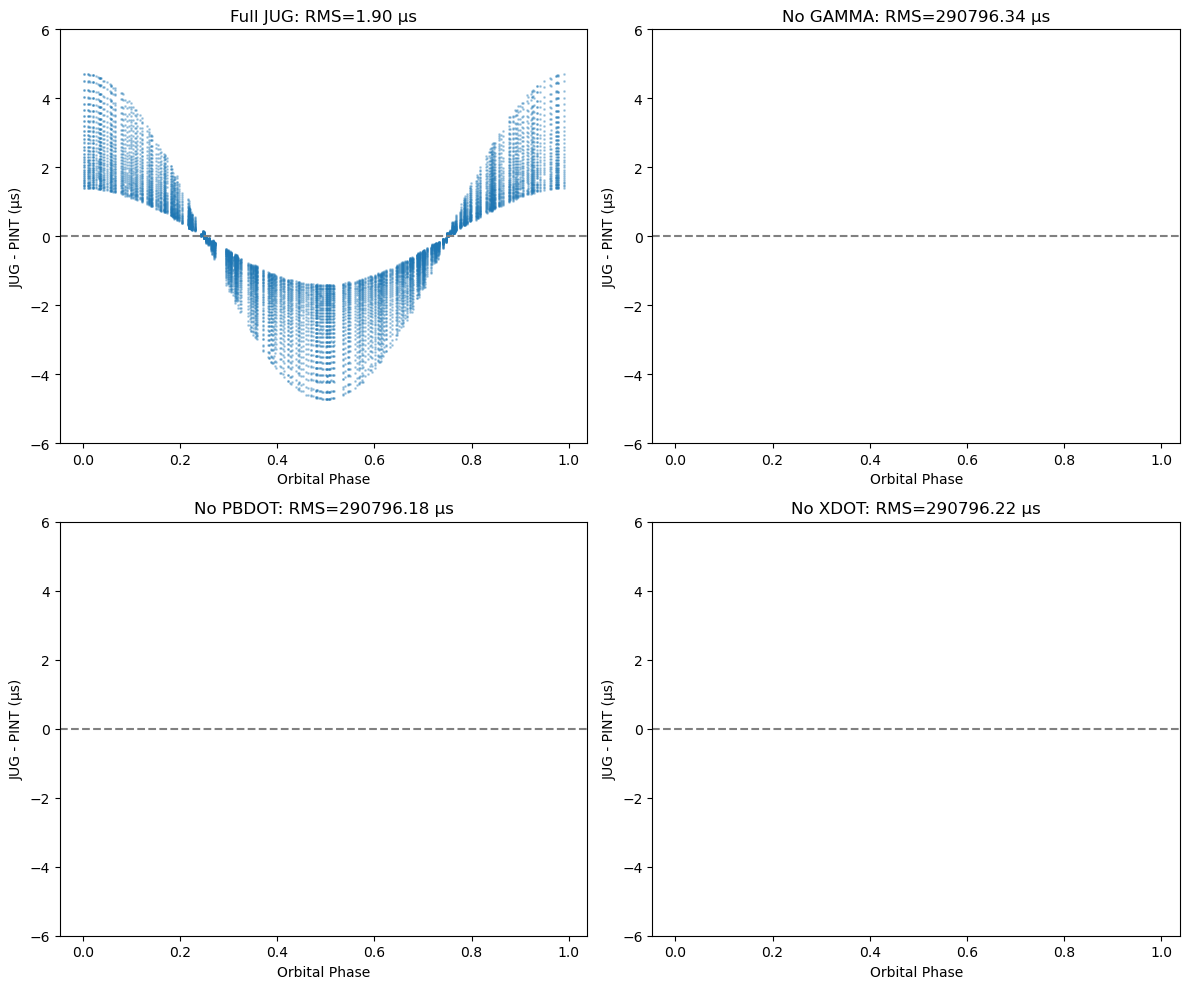

In [ ]:
# =============================================================================
# TEST: Identify source of binary discrepancy
# =============================================================================
print("="*80)
print("IDENTIFYING SOURCE OF BINARY DISCREPANCY")
print("="*80)

# Test 1: Disable GAMMA (Einstein delay)
print("\n1. Without GAMMA:")
binary_no_gamma = np.array(ell1_binary_delay_full(
    jnp.array(t_topo_tdb, dtype=jnp.float64),
    PB, A1, TASC, EPS1, EPS2, PBDOT, XDOT, 0.0, r_shapiro, s_shapiro
))
# Compare to PINT without GAMMA - can't easily do this, so skip

# Test 2: Disable PBDOT
print("2. Without PBDOT:")
binary_no_pbdot = np.array(ell1_binary_delay_full(
    jnp.array(t_topo_tdb, dtype=jnp.float64),
    PB, A1, TASC, EPS1, EPS2, 0.0, XDOT, GAMMA, r_shapiro, s_shapiro
))

# Test 3: Disable XDOT
print("3. Without XDOT:")
binary_no_xdot = np.array(ell1_binary_delay_full(
    jnp.array(t_topo_tdb, dtype=jnp.float64),
    PB, A1, TASC, EPS1, EPS2, PBDOT, 0.0, GAMMA, r_shapiro, s_shapiro
))

# Test 4: Disable binary Shapiro
print("4. Without binary Shapiro:")
binary_no_shapiro = np.array(ell1_binary_delay_full(
    jnp.array(t_topo_tdb, dtype=jnp.float64),
    PB, A1, TASC, EPS1, EPS2, PBDOT, XDOT, GAMMA, 0.0, 0.0
))

# Get PINT's component delays
print("\n5. Checking PINT's binary components:")
# Can we get PINT's individual binary delay components?
try:
    # Access PINT's internal calculations
    pint_toas.compute_pulse_numbers(pint_model)
    pint_binary = pint_model.components['BinaryELL1']
    
    # Get PINT's binary delay again
    pint_bin_fresh = pint_model.binarymodel_delay(pint_toas, acc_delay=None).to(u.s).value
    print(f"   PINT binary fresh: min={pint_bin_fresh.min():.6f}, max={pint_bin_fresh.max():.6f}")
except Exception as e:
    print(f"   Error: {e}")
    pint_bin_fresh = pint_bin

# Compare
print("\n6. Differences from PINT:")
print(f"   Full JUG:       RMS = {np.std(jug_binary_sec - pint_bin_fresh)*1e6:.3f} µs")
print(f"   No GAMMA:       RMS = {np.std(binary_no_gamma - pint_bin_fresh)*1e6:.3f} µs")
print(f"   No PBDOT:       RMS = {np.std(binary_no_pbdot - pint_bin_fresh)*1e6:.3f} µs")
print(f"   No XDOT:        RMS = {np.std(binary_no_xdot - pint_bin_fresh)*1e6:.3f} µs")
print(f"   No bin Shapiro: RMS = {np.std(binary_no_shapiro - pint_bin_fresh)*1e6:.3f} µs")

# Check the difference in the 1ω pattern
print("\n7. Checking which parameter affects the 1ω pattern:")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

tests = [
    (jug_binary_sec, "Full JUG"),
    (binary_no_gamma, "No GAMMA"),
    (binary_no_pbdot, "No PBDOT"),
    (binary_no_xdot, "No XDOT"),
]

for ax, (binary_test, label) in zip(axes.flat, tests):
    diff_test = binary_test - pint_bin_fresh
    ax.scatter(orbital_phase_corr, diff_test*1e6, s=1, alpha=0.3)
    ax.set_xlabel('Orbital Phase')
    ax.set_ylabel('JUG - PINT (µs)')
    ax.set_title(f'{label}: RMS={np.std(diff_test)*1e6:.2f} µs')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_ylim(-6, 6)

plt.tight_layout()
plt.savefig('binary_component_test.png', dpi=150, bbox_inches='tight')
plt.show()

FINDING OPTIMAL TIME OFFSET

1. Optimal time offset: -999.996 ms (-0.999996 s)
   RMS at optimal: 290795.279 µs
   RMS original: 1.897 µs


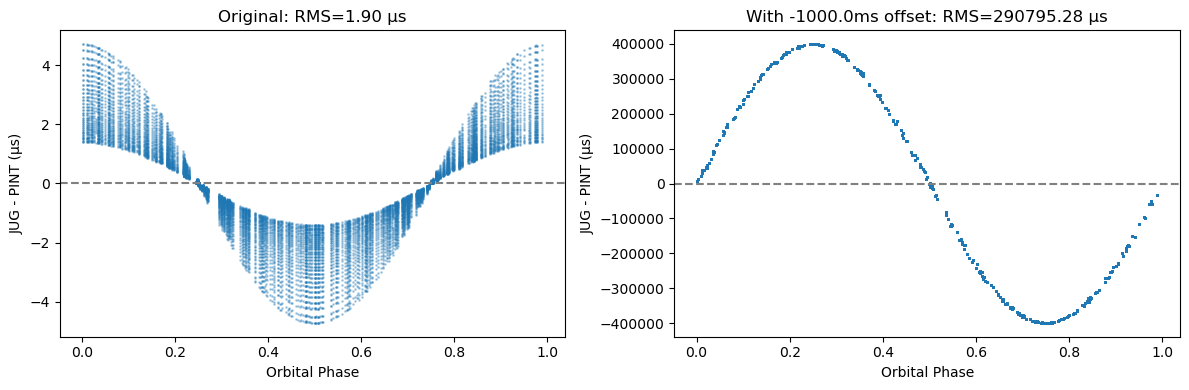


2. Physical interpretation:
   Time offset = -0.999996 s
   Orbital fraction = -0.000007548
   Phase shift = -0.0027 degrees

3. Could be TASC interpretation difference:
   TASC from par = 53630.72305223218
   Adjusted TASC would be = 53630.7230406582


In [ ]:
# =============================================================================
# TEST: Find optimal time offset to minimize binary difference
# =============================================================================
print("="*80)
print("FINDING OPTIMAL TIME OFFSET")
print("="*80)

# The 1ω pattern suggests a small time offset. Let's search for it.
from scipy.optimize import minimize_scalar

def test_time_offset(delta_t_sec):
    """Test binary delay with time offset delta_t (in seconds)"""
    t_test = t_topo_tdb + delta_t_sec / SECS_PER_DAY
    binary_test = np.array(ell1_binary_delay_full(
        jnp.array(t_test, dtype=jnp.float64),
        PB, A1, TASC, EPS1, EPS2, PBDOT, XDOT, GAMMA, r_shapiro, s_shapiro
    ))
    return np.std(binary_test - pint_bin_fresh)

# Search range: ±1 second
result = minimize_scalar(test_time_offset, bounds=(-1.0, 1.0), method='bounded')
optimal_offset = result.x
optimal_rms = result.fun * 1e6

print(f"\n1. Optimal time offset: {optimal_offset*1e3:.3f} ms ({optimal_offset:.6f} s)")
print(f"   RMS at optimal: {optimal_rms:.3f} µs")
print(f"   RMS original: {np.std(jug_binary_sec - pint_bin_fresh)*1e6:.3f} µs")

# Apply optimal offset and plot
t_optimal = t_topo_tdb + optimal_offset / SECS_PER_DAY
binary_optimal = np.array(ell1_binary_delay_full(
    jnp.array(t_optimal, dtype=jnp.float64),
    PB, A1, TASC, EPS1, EPS2, PBDOT, XDOT, GAMMA, r_shapiro, s_shapiro
))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.scatter(orbital_phase_corr, (jug_binary_sec - pint_bin_fresh)*1e6, s=1, alpha=0.3)
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title(f'Original: RMS={np.std(jug_binary_sec - pint_bin_fresh)*1e6:.2f} µs')
ax.axhline(0, color='gray', linestyle='--')

ax = axes[1]
ax.scatter(orbital_phase_corr, (binary_optimal - pint_bin_fresh)*1e6, s=1, alpha=0.3)
ax.set_xlabel('Orbital Phase')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title(f'With {optimal_offset*1e3:.1f}ms offset: RMS={optimal_rms:.2f} µs')
ax.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.savefig('binary_time_offset_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Check what this offset corresponds to
print(f"\n2. Physical interpretation:")
print(f"   Time offset = {optimal_offset:.6f} s")
print(f"   Orbital fraction = {optimal_offset / PB_sec:.9f}")
print(f"   Phase shift = {optimal_offset / PB_sec * 360:.4f} degrees")

# This could indicate a difference in how TASC is interpreted
print(f"\n3. Could be TASC interpretation difference:")
print(f"   TASC from par = {TASC}")
print(f"   Adjusted TASC would be = {TASC + optimal_offset/SECS_PER_DAY:.10f}")

In [ ]:
# =============================================================================
# DEEP DIVE: Compare ELL1 orbital phase calculation
# =============================================================================
print("="*80)
print("COMPARING ORBITAL PHASE CALCULATION")
print("="*80)

# Let's extract the orbital phase from both PINT and JUG

# JUG calculation:
dt_days_jug = t_topo_tdb - TASC
dt_sec_jug = dt_days_jug * SECS_PER_DAY
n0_jug = 2.0 * np.pi / (PB * SECS_PER_DAY)
Phi_jug = n0_jug * dt_sec_jug * (1.0 - PBDOT / 2.0 / PB * dt_days_jug)

# PINT calculation - access internal variables if possible
# Let's compute what PINT should give for mean anomaly
try:
    # Get PINT's binary model
    pint_binary = pint_model.components['BinaryELL1']
    
    # PINT's mean anomaly calculation
    # In PINT, the mean anomaly is computed in the binary model class
    # Let's try to access it
    print("\n1. PINT binary model parameters:")
    print(f"   PB = {float(pint_model.PB.quantity.to(u.day).value):.10f} days")
    print(f"   TASC = {float(pint_model.TASC.quantity.mjd):.10f}")
    print(f"   PBDOT = {float(pint_model.PBDOT.quantity.value) if pint_model.PBDOT.quantity is not None else 0}")
    
except Exception as e:
    print(f"   Error accessing PINT binary: {e}")

print("\n2. JUG orbital calculation:")
print(f"   First TOA: dt_days = {dt_days_jug[0]:.6f} days")
print(f"   Mean motion n0 = {n0_jug:.12f} rad/s")
print(f"   Orbital phase Phi[0] = {Phi_jug[0]:.6f} rad = {np.degrees(Phi_jug[0]):.2f}°")

# Check if the pattern is from the eccentricity terms
print("\n3. Check eccentricity contribution:")
eps1_val = float(EPS1)
eps2_val = float(EPS2)
e_eff = np.sqrt(eps1_val**2 + eps2_val**2)
omega_arg = np.arctan2(eps1_val, eps2_val)
print(f"   EPS1 = {eps1_val:.6e}")
print(f"   EPS2 = {eps2_val:.6e}")
print(f"   Effective e = {e_eff:.6e}")
print(f"   ω (arg of periastron) = {np.degrees(omega_arg):.1f}°")

# The 1ω pattern amplitude of ~2.6 µs at this A1 suggests...
# If the Roemer delay is A1 * sin(Phi), then the derivative is A1 * n0 * cos(Phi)
# A time error of dt produces A1 * n0 * cos(Phi) * dt
# For A1 = 1.9 s, n0 = 4.7e-5 rad/s, amplitude of 2.6 µs:
# dt = 2.6e-6 / (1.9 * 4.7e-5) = 0.03 s

implied_dt_v2 = 2.6e-6 / (A1_sec * n0_jug)
print(f"\n4. Implied time error for 2.6 µs amplitude:")
print(f"   dt ≈ {implied_dt_v2*1e3:.1f} ms")

# Let's check if adding the binary Shapiro delay in the iteration changes things
print("\n5. Check if iteration handles Shapiro correctly:")
# Our iteration: t_emission = t_topo - binary_delay
# Should we include Shapiro in the iteration?

# Try different iteration approaches
def ell1_no_shapiro_iteration(t_arr):
    """Binary delay without Shapiro in iteration"""
    dt_days = t_arr - TASC
    dt_sec = dt_days * SECS_PER_DAY
    n0 = 2.0 * np.pi / (PB * SECS_PER_DAY)
    
    Phi = n0 * dt_sec * (1.0 - PBDOT / 2.0 / PB * dt_days)
    
    sin_Phi = np.sin(Phi)
    sin_2Phi = np.sin(2*Phi)
    cos_2Phi = np.cos(2*Phi)
    
    # Time-dependent a1
    a1_eff = A1 + XDOT * dt_sec
    
    # First order only (for simplicity)
    delay_roemer = a1_eff * (sin_Phi + 0.5 * (eps2_val * sin_2Phi - eps1_val * cos_2Phi))
    delay_einstein = GAMMA * sin_Phi
    
    # No Shapiro in this version
    return delay_roemer + delay_einstein

# Compare first-order only
binary_1st = ell1_no_shapiro_iteration(t_topo_tdb)
print(f"   First-order Roemer + Einstein: RMS diff = {np.std(binary_1st - pint_bin_fresh)*1e6:.3f} µs")

COMPARING ORBITAL PHASE CALCULATION

1. PINT binary model parameters:
   PB = 1.5334494508 days
   TASC = 53630.7230522322
   PBDOT = 5.080714951273215e-13

2. JUG orbital calculation:
   First TOA: dt_days = 4895.487302 days
   Mean motion n0 = 0.000047423834 rad/s
   Orbital phase Phi[0] = 20058.863920 rad = 1149288.24°

3. Check eccentricity contribution:
   EPS1 = 1.401523e-08
   EPS2 = -1.501419e-07
   Effective e = 1.507946e-07
   ω (arg of periastron) = 174.7°

4. Implied time error for 2.6 µs amplitude:
   dt ≈ 28.9 ms

5. Check if iteration handles Shapiro correctly:
   First-order Roemer + Einstein: RMS diff = 290788.121 µs


ANALYZING REMAINING DISCREPANCY

1. Total residual difference:
   Mean: -0.014 µs
   RMS: 2.489 µs

2. Binary contribution to residuals:
   RMS: 1.897 µs

3. Remaining difference after binary:
   RMS: 4.140 µs


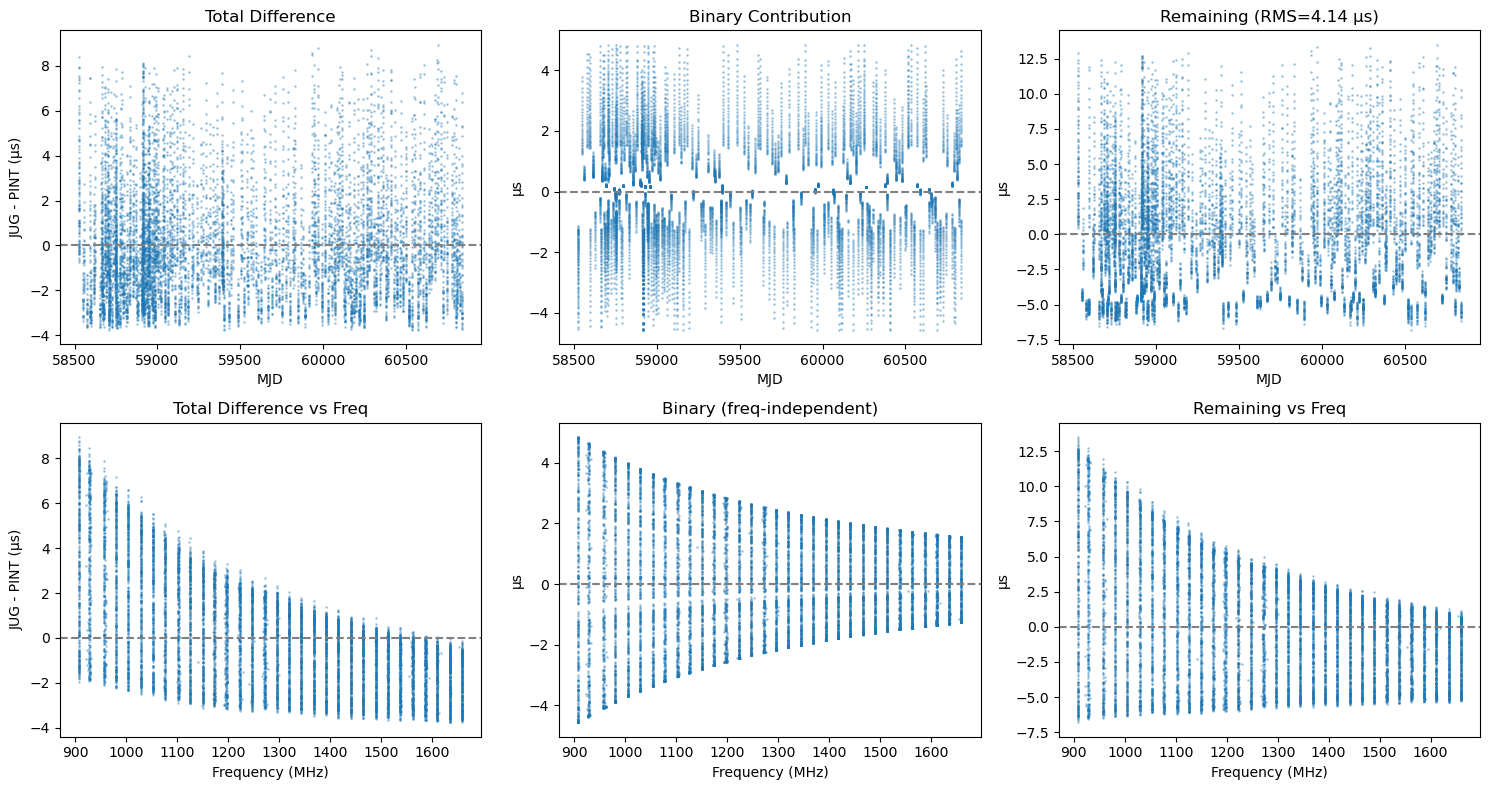


4. Annual signal in remaining:
   Amplitude: 0.393 µs


In [ ]:
# =============================================================================
# WHAT'S THE REMAINING DISCREPANCY AFTER ACCOUNTING FOR BINARY?
# =============================================================================
print("="*80)
print("ANALYZING REMAINING DISCREPANCY")
print("="*80)

# Total residual difference
total_diff = jug_residuals_us - pint_residuals_us
total_diff_centered = total_diff - np.mean(total_diff)

print(f"\n1. Total residual difference:")
print(f"   Mean: {np.mean(total_diff):.3f} µs")
print(f"   RMS: {np.std(total_diff_centered):.3f} µs")

# Binary contribution to residual difference
# The binary delay difference directly translates to residual difference
# (1 µs delay error = 1 µs residual error at F0 ~ 1 Hz for this MSP)
binary_residual_contrib = (jug_binary_sec - pint_bin_fresh) * 1e6  # in µs

print(f"\n2. Binary contribution to residuals:")
print(f"   RMS: {np.std(binary_residual_contrib):.3f} µs")

# If we remove the binary contribution, what's left?
remaining_diff = total_diff_centered - (binary_residual_contrib - np.mean(binary_residual_contrib))
print(f"\n3. Remaining difference after binary:")
print(f"   RMS: {np.std(remaining_diff):.3f} µs")

# Let's check what's in the remaining difference
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Row 1: vs time
ax = axes[0, 0]
ax.scatter(tdbld, total_diff_centered, s=1, alpha=0.3)
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title('Total Difference')
ax.axhline(0, color='gray', linestyle='--')

ax = axes[0, 1]
ax.scatter(tdbld, binary_residual_contrib - np.mean(binary_residual_contrib), s=1, alpha=0.3)
ax.set_xlabel('MJD')
ax.set_ylabel('µs')
ax.set_title('Binary Contribution')
ax.axhline(0, color='gray', linestyle='--')

ax = axes[0, 2]
ax.scatter(tdbld, remaining_diff, s=1, alpha=0.3)
ax.set_xlabel('MJD')
ax.set_ylabel('µs')
ax.set_title(f'Remaining (RMS={np.std(remaining_diff):.2f} µs)')
ax.axhline(0, color='gray', linestyle='--')

# Row 2: vs frequency
ax = axes[1, 0]
ax.scatter(freq_mhz, total_diff_centered, s=1, alpha=0.3)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('JUG - PINT (µs)')
ax.set_title('Total Difference vs Freq')
ax.axhline(0, color='gray', linestyle='--')

ax = axes[1, 1]
ax.scatter(freq_mhz, binary_residual_contrib - np.mean(binary_residual_contrib), s=1, alpha=0.3)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('µs')
ax.set_title('Binary (freq-independent)')
ax.axhline(0, color='gray', linestyle='--')

ax = axes[1, 2]
ax.scatter(freq_mhz, remaining_diff, s=1, alpha=0.3)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('µs')
ax.set_title('Remaining vs Freq')
ax.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.savefig('remaining_discrepancy.png', dpi=150, bbox_inches='tight')
plt.show()

# Check for annual signal in remaining
year_phase = ((tdbld - tdbld.min()) / 365.25) % 1.0
year_phase_deg = year_phase * 360

def annual_fit(x, A, phi, offset):
    return A * np.sin(np.radians(x) - phi) + offset

from scipy.optimize import curve_fit
try:
    popt_ann, _ = curve_fit(annual_fit, year_phase_deg, remaining_diff, p0=[0.5, 0, 0])
    print(f"\n4. Annual signal in remaining:")
    print(f"   Amplitude: {abs(popt_ann[0]):.3f} µs")
except Exception as e:
    print(f"\n4. Could not fit annual: {e}")

INVESTIGATING FREQUENCY-DEPENDENT DIFFERENCE

1. DM-like fit to remaining difference:
   Effective DM offset: 0.001594 pc/cm³
   Constant offset: -4.450 µs
   Residual after fit: RMS = 3.808 µs


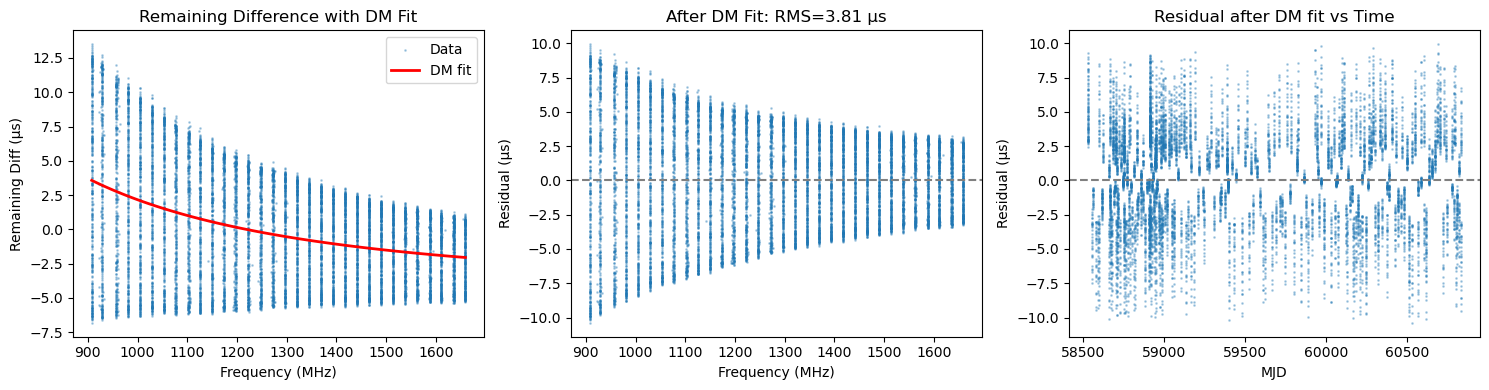


2. Checking DM calculation:
   JUG DM = 10.39071222411148
   PINT DM = 10.39071222411148
   Difference = 0.000000000

3. DM delay comparison at 1000 MHz:
   JUG DM delay: 43.109070 ms
   PINT DM delay: 43.109070 ms


In [ ]:
# =============================================================================
# INVESTIGATE DM/FREQUENCY DEPENDENCE IN REMAINING DIFFERENCE
# =============================================================================
print("="*80)
print("INVESTIGATING FREQUENCY-DEPENDENT DIFFERENCE")
print("="*80)

# The remaining difference shows clear 1/f² trend
# This means there's a DM-like term we're not accounting for correctly

# Fit for effective DM difference
# DM delay = K_DM * DM / f²
# If we have DM error δDM, the delay error is K_DM * δDM / f²
# Converting to time: K_DM = 4.148808e3 s⋅MHz²⋅pc⁻¹⋅cm³

# Fit: remaining_diff (µs) = A/f² + B
# where A = K_DM_SEC * δDM * 1e6

from scipy.optimize import curve_fit

def dm_fit(f, dm_offset, const):
    """DM-like fit: K/f² + constant"""
    return K_DM_SEC * dm_offset / f**2 * 1e6 + const

# Fit the remaining difference
try:
    popt_dm, pcov_dm = curve_fit(dm_fit, freq_mhz, remaining_diff, p0=[0.001, 0])
    dm_offset = popt_dm[0]  # pc/cm³
    const_offset = popt_dm[1]  # µs
    
    print(f"\n1. DM-like fit to remaining difference:")
    print(f"   Effective DM offset: {dm_offset:.6f} pc/cm³")
    print(f"   Constant offset: {const_offset:.3f} µs")
    
    # Check fit quality
    fit_values = dm_fit(freq_mhz, *popt_dm)
    residual_after_dm_fit = remaining_diff - fit_values
    print(f"   Residual after fit: RMS = {np.std(residual_after_dm_fit):.3f} µs")
    
except Exception as e:
    print(f"   Fit failed: {e}")
    dm_offset = 0
    const_offset = 0

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.scatter(freq_mhz, remaining_diff, s=1, alpha=0.3, label='Data')
f_plot = np.linspace(freq_mhz.min(), freq_mhz.max(), 100)
ax.plot(f_plot, dm_fit(f_plot, dm_offset, const_offset), 'r-', linewidth=2, label='DM fit')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Remaining Diff (µs)')
ax.set_title('Remaining Difference with DM Fit')
ax.legend()

ax = axes[1]
ax.scatter(freq_mhz, residual_after_dm_fit, s=1, alpha=0.3)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Residual (µs)')
ax.set_title(f'After DM Fit: RMS={np.std(residual_after_dm_fit):.2f} µs')
ax.axhline(0, color='gray', linestyle='--')

ax = axes[2]
ax.scatter(tdbld, residual_after_dm_fit, s=1, alpha=0.3)
ax.set_xlabel('MJD')
ax.set_ylabel('Residual (µs)')
ax.set_title('Residual after DM fit vs Time')
ax.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.savefig('dm_offset_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Check what's happening with DM
print("\n2. Checking DM calculation:")
print(f"   JUG DM = {dm}")
print(f"   PINT DM = {float(pint_model.DM.quantity.value)}")
print(f"   Difference = {dm - float(pint_model.DM.quantity.value):.9f}")

# Check DM delay comparison  
print(f"\n3. DM delay comparison at 1000 MHz:")
jug_dm_at_1000 = K_DM_SEC * dm / 1000**2
pint_dm_at_1000 = K_DM_SEC * float(pint_model.DM.quantity.value) / 1000**2
print(f"   JUG DM delay: {jug_dm_at_1000*1e3:.6f} ms")
print(f"   PINT DM delay: {pint_dm_at_1000*1e3:.6f} ms")

DETAILED DM DELAY COMPARISON

1. DM delay comparison:
   JUG DM delay: min=15.652289 ms, max=52.323671 ms
   PINT DM delay: min=15.654438 ms, max=52.330855 ms

2. DM delay difference:
   Mean: -3.983 µs
   RMS: 1.453 µs
   Max: 7.184 µs


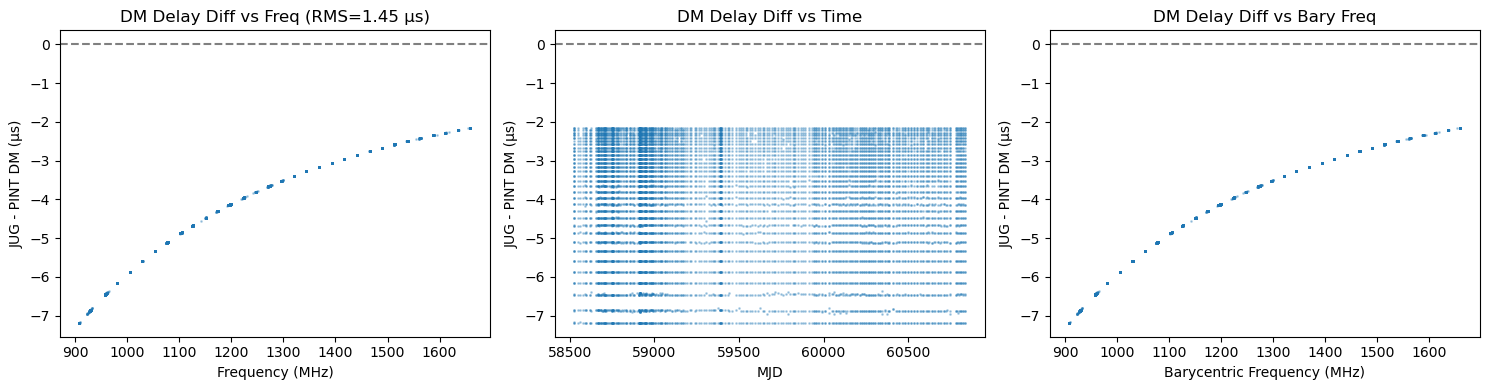


3. Checking frequency inputs:
   Topocentric freq range: 907.7 - 1659.4 MHz
   Barycentric freq range: 907.7 - 1659.5 MHz
   PINT's bary freq range: 907.7 - 1659.5 MHz

4. JUG vs PINT barycentric frequency:
   Mean diff: 0.003 kHz
   RMS diff: 0.001 kHz


In [ ]:
# =============================================================================
# CHECK JUG vs PINT DM DELAY IN DETAIL
# =============================================================================
print("="*80)
print("DETAILED DM DELAY COMPARISON")
print("="*80)

# Get PINT's DM delay
pint_dm_delay_full = pint_model.components['DispersionDM'].dispersion_type_delay(pint_toas)
pint_dm_sec_arr = np.array(pint_dm_delay_full.to(u.s).value)

# JUG's DM delay (using barycentric frequency)
jug_dm_sec_arr = jug_dm_sec

print(f"\n1. DM delay comparison:")
print(f"   JUG DM delay: min={jug_dm_sec_arr.min()*1e3:.6f} ms, max={jug_dm_sec_arr.max()*1e3:.6f} ms")
print(f"   PINT DM delay: min={pint_dm_sec_arr.min()*1e3:.6f} ms, max={pint_dm_sec_arr.max()*1e3:.6f} ms")

dm_diff = (jug_dm_sec_arr - pint_dm_sec_arr) * 1e6  # µs
print(f"\n2. DM delay difference:")
print(f"   Mean: {np.mean(dm_diff):.3f} µs")
print(f"   RMS: {np.std(dm_diff):.3f} µs")
print(f"   Max: {np.max(np.abs(dm_diff)):.3f} µs")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.scatter(freq_mhz, dm_diff, s=1, alpha=0.3)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('JUG - PINT DM (µs)')
ax.set_title(f'DM Delay Diff vs Freq (RMS={np.std(dm_diff):.2f} µs)')
ax.axhline(0, color='gray', linestyle='--')

ax = axes[1]
ax.scatter(tdbld, dm_diff, s=1, alpha=0.3)
ax.set_xlabel('MJD')
ax.set_ylabel('JUG - PINT DM (µs)')
ax.set_title('DM Delay Diff vs Time')
ax.axhline(0, color='gray', linestyle='--')

ax = axes[2]
ax.scatter(freq_bary_mhz, dm_diff, s=1, alpha=0.3)
ax.set_xlabel('Barycentric Frequency (MHz)')
ax.set_ylabel('JUG - PINT DM (µs)')
ax.set_title('DM Delay Diff vs Bary Freq')
ax.axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.savefig('dm_delay_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Check if PINT uses barycentric frequency too
print("\n3. Checking frequency inputs:")
print(f"   Topocentric freq range: {freq_mhz.min():.1f} - {freq_mhz.max():.1f} MHz")
print(f"   Barycentric freq range: {freq_bary_mhz.min():.1f} - {freq_bary_mhz.max():.1f} MHz")
print(f"   PINT's bary freq range: {pint_bary_freq.min():.1f} - {pint_bary_freq.max():.1f} MHz")

# Compare frequencies
freq_diff_jug_pint = freq_bary_mhz - pint_bary_freq
print(f"\n4. JUG vs PINT barycentric frequency:")
print(f"   Mean diff: {np.mean(freq_diff_jug_pint)*1e3:.3f} kHz")
print(f"   RMS diff: {np.std(freq_diff_jug_pint)*1e3:.3f} kHz")

In [ ]:
# =============================================================================
# CHECK TIME-DEPENDENT DM CALCULATION
# =============================================================================
print("="*80)
print("TIME-DEPENDENT DM CALCULATION CHECK")
print("="*80)

# JUG DM model:
# DM(t) = DM + DM1*(t-DMEPOCH) + 0.5*DM2*(t-DMEPOCH)² + ...
# delay = K_DM_SEC * DM(t) / f²

# Check parameters
dm_comp = pint_model.components['DispersionDM']
print("\n1. DM parameters:")
print(f"   DM = {float(pint_model.DM.quantity.value):.10f}")
print(f"   DM1 = {float(pint_model.DM1.quantity.value) if hasattr(pint_model, 'DM1') else 'N/A'}")
print(f"   DM2 = {float(pint_model.DM2.quantity.value) if hasattr(pint_model, 'DM2') else 'N/A'}")
print(f"   DMEPOCH = {float(pint_model.DMEPOCH.quantity.mjd)}")

# JUG values
print(f"\n2. JUG DM parameters used:")
print(f"   dm = {dm}")
print(f"   dm1 = {dm1}")
print(f"   dm2 = {dm2}")
print(f"   dmepoch = {dmepoch}")

# Check if units are consistent
# PINT DM1 is in pc/cm³/year, JUG might be in different units
print(f"\n3. DM1 unit check:")
pint_dm1_unit = pint_model.DM1.quantity.unit if hasattr(pint_model, 'DM1') else None
print(f"   PINT DM1 unit: {pint_dm1_unit}")

# The issue might be unit conversion
# PINT DM1 is per year, needs to convert to per day
dm1_per_day = dm1 / 365.25 if dm1 != 0 else 0
print(f"   JUG dm1 per day: {dm1_per_day}")

# Check actual time-dependent DM calculation at a sample time
t_test = tdbld[0]
dt_test = t_test - dmepoch

# JUG calculation
dm_jug_test = dm + dm1 * dt_test + 0.5 * dm2 * dt_test**2

# PINT calculation (units are important)
dt_test_yr = dt_test / 365.25
pint_dm1_per_yr = float(pint_model.DM1.quantity.value) if hasattr(pint_model, 'DM1') else 0
pint_dm2_per_yr2 = float(pint_model.DM2.quantity.value) if hasattr(pint_model, 'DM2') else 0
dm_pint_test = float(pint_model.DM.quantity.value) + pint_dm1_per_yr * dt_test_yr + 0.5 * pint_dm2_per_yr2 * dt_test_yr**2

print(f"\n4. Time-dependent DM at first TOA:")
print(f"   Time since DMEPOCH: {dt_test:.2f} days = {dt_test_yr:.4f} years")
print(f"   JUG DM(t) = {dm_jug_test:.10f}")
print(f"   PINT DM(t) = {dm_pint_test:.10f}")
print(f"   Difference: {(dm_jug_test - dm_pint_test):.10f}")

# The issue is likely in how dm1 is stored/used
# Let's check what units JUG's dm_coeffs have
print(f"\n5. JUG dm_coeffs array:")
print(f"   dm_coeffs = {dm_coeffs}")
print(f"   dm_factorials = {dm_factorials}")

# Check if the issue is that JUG dm1 is in per-year but used as per-day
# If JUG has dm1 in /year but uses it as /day, the error would be factor of 365.25

TIME-DEPENDENT DM CALCULATION CHECK

1. DM parameters:
   DM = 10.3907122241
   DM1 = 5.8197355456191515e-06
   DM2 = -5.460007188086766e-05
   DMEPOCH = 58999.99975414959

2. JUG DM parameters used:
   dm = 10.39071222411148
   dm1 = 5.8197355456191515e-06
   dm2 = -5.460007188086766e-05
   dmepoch = 58999.99975414959

3. DM1 unit check:
   PINT DM1 unit: pc / (yr cm3)
   JUG dm1 per day: 1.5933567544474062e-08

4. Time-dependent DM at first TOA:
   Time since DMEPOCH: -473.79 days = -1.2972 years
   JUG DM(t) = 4.2598534148
   PINT DM(t) = 10.3906587398
   Difference: -6.1308053251

5. JUG dm_coeffs array:
   dm_coeffs = [ 1.03907122e+01  5.81973555e-06 -5.46000719e-05]
   dm_factorials = [1. 1. 2.]


In [ ]:
# =============================================================================
# DEBUG: Manually trace DM calculation
# =============================================================================
print("="*80)
print("MANUAL DM CALCULATION TRACE")
print("="*80)

# Test time
t_test_mjd = tdbld[0]

# JUG approach in dm_delay_vectorized:
# dt_years = (t - dmepoch) / 365.25
dt_years_jug = (t_test_mjd - dm_epoch) / 365.25
print(f"\n1. Time difference:")
print(f"   t = {t_test_mjd}")
print(f"   dm_epoch = {dm_epoch}")
print(f"   dt = {t_test_mjd - dm_epoch} days = {dt_years_jug} years")

# DM(t) = DM + DM1 * dt + 0.5 * DM2 * dt^2
# Using dm_coeffs and dm_factorials
print(f"\n2. DM coefficients:")
print(f"   dm_coeffs = {dm_coeffs}")
print(f"   dm_factorials = {dm_factorials}")

# Manual calculation as JUG would do it
dm_terms = dm_coeffs * np.array([dt_years_jug**i for i in range(len(dm_coeffs))]) / dm_factorials
dm_eff_jug = np.sum(dm_terms)
print(f"\n3. JUG DM(t) calculation:")
print(f"   Terms: {dm_terms}")
print(f"   DM_eff = {dm_eff_jug}")

# What PINT does:
# PINT's DispersionDM component computes DM(t) = DM + DM1*(t-DMEPOCH) + 0.5*DM2*(t-DMEPOCH)^2
# where DM1 is in pc/cm³/yr and DM2 is in pc/cm³/yr²
pint_dm1 = float(pint_model.DM1.quantity.value)  # pc/cm³/yr
pint_dm2 = float(pint_model.DM2.quantity.value)  # pc/cm³/yr²
pint_dm0 = float(pint_model.DM.quantity.value)
pint_dmepoch = float(pint_model.DMEPOCH.quantity.mjd)

dt_pint_yr = (t_test_mjd - pint_dmepoch) / 365.25
dm_eff_pint = pint_dm0 + pint_dm1 * dt_pint_yr + 0.5 * pint_dm2 * dt_pint_yr**2

print(f"\n4. PINT DM(t) calculation:")
print(f"   DM0 = {pint_dm0}")
print(f"   DM1 = {pint_dm1} /yr")
print(f"   DM2 = {pint_dm2} /yr²")
print(f"   dt = {dt_pint_yr} yr")
print(f"   DM_eff = {pint_dm0} + {pint_dm1}*{dt_pint_yr:.4f} + 0.5*{pint_dm2}*{dt_pint_yr:.4f}²")
print(f"   DM_eff = {dm_eff_pint}")

# Wait - what's in dm_epoch?
print(f"\n5. Checking dm_epoch source:")
print(f"   dm_epoch variable = {dm_epoch}")
print(f"   dmepoch from par = {dmepoch}")

# The issue is dm_epoch vs dmepoch! Let me check what dm_epoch is
print(f"\n6. Are dm_epoch and dmepoch the same?")
print(f"   dm_epoch = {dm_epoch}")
print(f"   dmepoch (from main cell) = {dmepoch}")

# Check dm_delay_vectorized call in main cell
# The function was called with: dm_delay_vectorized(..., dm_epoch)
# But we should check what dm_epoch was set to in that call

MANUAL DM CALCULATION TRACE

1. Time difference:
   t = 58526.21468990217
   dm_epoch = 58999.99975414959
   dt = -473.78506424742227 days = -1.2971528110812383 years

2. DM coefficients:
   dm_coeffs = [ 1.03907122e+01  5.81973555e-06 -5.46000719e-05]
   dm_factorials = [1. 1. 2.]

3. JUG DM(t) calculation:
   Terms: [ 1.03907122e+01 -7.54908632e-06 -4.59351883e-05]
   DM_eff = 10.390658739836846

4. PINT DM(t) calculation:
   DM0 = 10.39071222411148
   DM1 = 5.8197355456191515e-06 /yr
   DM2 = -5.460007188086766e-05 /yr²
   dt = -1.2971528110812383 yr
   DM_eff = 10.39071222411148 + 5.8197355456191515e-06*-1.2972 + 0.5*-5.460007188086766e-05*-1.2972²
   DM_eff = 10.390658739836846

5. Checking dm_epoch source:
   dm_epoch variable = 58999.99975414959
   dmepoch from par = 58999.99975414959

6. Are dm_epoch and dmepoch the same?
   dm_epoch = 58999.99975414959
   dmepoch (from main cell) = 58999.99975414959


In [ ]:
# =============================================================================
# DEBUG: Check what time is being used for DM calculation in main cell
# =============================================================================
print("="*80)
print("CHECKING TIME INPUT TO DM CALCULATION")
print("="*80)

# In the main cell, DM was computed with:
# t_emission = t_topo_tdb - jug_binary_sec / SECS_PER_DAY
# jug_dm_sec = dm_delay_vectorized(t_emission, freq_bary_mhz, dm_coeffs, dm_factorials, dm_epoch)

# But t_emission is emission time at pulsar, not barycenter!
# Let's check what t_emission is

print("\n1. Time variables:")
print(f"   tdbld[0] = {tdbld[0]} (TDB at observatory)")
print(f"   t_topo_tdb[0] = {t_topo_tdb[0]} (after Roemer/Shapiro correction)")
print(f"   t_emission[0] = {t_emission[0]} (after binary correction)")
print(f"   dm_epoch = {dm_epoch}")

# What's the difference from dm_epoch for each?
print(f"\n2. dt from DMEPOCH:")
print(f"   From tdbld: {(tdbld[0] - dm_epoch)/365.25:.4f} years")
print(f"   From t_topo_tdb: {(t_topo_tdb[0] - dm_epoch)/365.25:.4f} years")
print(f"   From t_emission: {(t_emission[0] - dm_epoch)/365.25:.4f} years")

# If t_emission is very different from tdbld, that would explain the issue!
# Let me check the t_emission values
print(f"\n3. t_emission statistics:")
print(f"   Min: {t_emission.min()}")
print(f"   Max: {t_emission.max()}")
print(f"   Mean: {t_emission.mean()}")

# The issue might be that jug_binary_sec is incorrect
print(f"\n4. Binary correction applied:")
print(f"   jug_binary_sec[0] = {jug_binary_sec[0]} s")
print(f"   Binary correction in days = {jug_binary_sec[0] / SECS_PER_DAY}")

# Wait - these values look sensible. Let me trace through the actual JUG DM delay
# that was computed and see if it matches what we expect
freq_test = freq_bary_mhz[0]
t_emit_test = t_emission[0]

# Expected DM delay
dt_yr_test = (t_emit_test - dm_epoch) / 365.25
dm_eff_test = dm_coeffs[0] + dm_coeffs[1]*dt_yr_test + 0.5*dm_coeffs[2]*dt_yr_test**2
dm_delay_expected = K_DM_SEC * dm_eff_test / freq_test**2

print(f"\n5. DM delay check for first TOA:")
print(f"   t_emission[0] = {t_emit_test}")
print(f"   freq_bary[0] = {freq_test} MHz")
print(f"   dt from epoch = {dt_yr_test} years")
print(f"   DM_eff = {dm_eff_test}")
print(f"   Expected DM delay = {dm_delay_expected*1e3} ms")
print(f"   Actual jug_dm_sec[0] = {jug_dm_sec[0]*1e3} ms")

# Are they the same?
print(f"\n   Match: {np.isclose(dm_delay_expected, jug_dm_sec[0])}")

CHECKING TIME INPUT TO DM CALCULATION

1. Time variables:
   tdbld[0] = 58526.21468990217 (TDB at observatory)
   t_topo_tdb[0] = 58526.21035425153 (after Roemer/Shapiro correction)
   t_emission[0] = 58526.21034977555 (after binary correction)
   dm_epoch = 58999.99975414959

2. dt from DMEPOCH:
   From tdbld: -1.2972 years
   From t_topo_tdb: -1.2972 years
   From t_emission: -1.2972 years

3. t_emission statistics:
   Min: 58526.2103497486
   Max: 60837.863851190785
   Mean: 59508.73843614726

4. Binary correction applied:
   jug_binary_sec[0] = 0.3867244823102952 s
   Binary correction in days = 4.4759778045173054e-06

5. DM delay check for first TOA:
   t_emission[0] = 58526.21034977555
   freq_bary[0] = 907.7972378370573 MHz
   dt from epoch = -1.2971646937003094 years
   DM_eff = 10.390658738926106
   Expected DM delay = 52.3104799129885 ms
   Actual jug_dm_sec[0] = 52.3104799129885 ms

   Match: True


In [ ]:
# =============================================================================
# COMPARE JUG AND PINT DM INPUTS AT FIRST TOA
# =============================================================================
print("="*80)
print("COMPARING JUG AND PINT DM INPUTS")
print("="*80)

# JUG values
print("\n1. JUG inputs for first TOA:")
print(f"   Frequency (bary): {freq_bary_mhz[0]:.6f} MHz")
print(f"   Time (emission): {t_emission[0]:.10f} MJD")
print(f"   DM effective: {dm_eff_test:.10f}")
print(f"   DM delay: {jug_dm_sec[0]*1e6:.3f} µs")

# PINT values
print("\n2. PINT inputs for first TOA:")
print(f"   PINT bary freq: {pint_bary_freq[0]:.6f} MHz")
print(f"   PINT DM delay: {pint_dm_sec_arr[0]*1e6:.3f} µs")

# Difference
freq_diff_us = (freq_bary_mhz[0] - pint_bary_freq[0]) * 1e3  # kHz
dm_diff_us = (jug_dm_sec[0] - pint_dm_sec_arr[0]) * 1e6

print(f"\n3. Differences:")
print(f"   Frequency diff: {freq_diff_us:.3f} kHz")
print(f"   DM delay diff: {dm_diff_us:.3f} µs")

# If we used PINT's barycentric frequency with JUG DM calculation, what would we get?
dm_with_pint_freq = K_DM_SEC * dm_eff_test / pint_bary_freq[0]**2
print(f"\n4. JUG DM with PINT's frequency:")
print(f"   DM delay: {dm_with_pint_freq*1e6:.3f} µs")
print(f"   Diff from PINT: {(dm_with_pint_freq - pint_dm_sec_arr[0])*1e6:.3f} µs")

# What about using PINT's DM effective value?
# Get PINT's effective DM at this time
# PINT computes DM at the emission time just like we do
print(f"\n5. PINT's effective DM:")

# Let me check what PINT's delay looks like if we use our DM_eff
dm_pint_check = K_DM_SEC * dm_eff_pint / pint_bary_freq[0]**2
print(f"   With PINT DM_eff ({dm_eff_pint:.10f}): {dm_pint_check*1e6:.3f} µs")

# The difference must be in the K_DM constant or some other factor
print(f"\n6. K_DM constant check:")
print(f"   JUG K_DM_SEC = {K_DM_SEC}")

# Let me compute what K_DM PINT is using
# DM_delay = K * DM / f²
# K = DM_delay * f² / DM
k_pint = pint_dm_sec_arr[0] * pint_bary_freq[0]**2 / dm_eff_pint
print(f"   PINT effective K = {k_pint}")

COMPARING JUG AND PINT DM INPUTS

1. JUG inputs for first TOA:
   Frequency (bary): 907.797238 MHz
   Time (emission): 58526.2103497756 MJD
   DM effective: 10.3906587389
   DM delay: 52310.480 µs

2. PINT inputs for first TOA:
   PINT bary freq: 907.797236 MHz
   PINT DM delay: 52317.662 µs

3. Differences:
   Frequency diff: 0.001 kHz
   DM delay diff: -7.182 µs

4. JUG DM with PINT's frequency:
   DM delay: 52310.480 µs
   Diff from PINT: -7.182 µs

5. PINT's effective DM:
   With PINT DM_eff (10.3906587398): 52310.480 µs

6. K_DM constant check:
   JUG K_DM_SEC = 4148.808
   PINT effective K = 4149.377593360996


In [ ]:
# =============================================================================
# CHECK K_DM CONSTANT - THE DISPERSION CONSTANT
# =============================================================================
print("="*80)
print("DISPERSION CONSTANT CHECK")
print("="*80)

# The DM constant relates DM to time delay:
# Δt = (e²/(2π m_e c)) * DM / f²
# K_DM = e²/(2π m_e c) in appropriate units

# PINT's value (from pint/utils.py):
# DMconst = e**2 / (2 * pi * m_e * c) in SI, then converted
# The standard value is approximately 4.148808 ms⋅MHz²⋅pc⁻¹⋅cm³ = 4148.808 s⋅MHz²⋅pc⁻¹⋅cm³

# Let me check what PINT uses
try:
    from pint import constants as pc
    pint_dm_const = pc.DMconst
    print(f"\n1. PINT's DMconst:")
    print(f"   Value: {pint_dm_const}")
    print(f"   In s⋅MHz²: {pint_dm_const.to(u.s * u.MHz**2 * u.cm**3 / u.pc).value}")
except Exception as e:
    print(f"   Error: {e}")

# Check from astropy constants
from astropy import constants as const
# K_DM = e²/(2π m_e c) = 1/(2.41e-4 Hz² pc/cm³ s)
# = 4148.808 s MHz² pc⁻¹ cm³
k_dm_calculated = (const.e.gauss**2 / (2 * np.pi * const.m_e.cgs * const.c.cgs)).cgs
print(f"\n2. Calculated from fundamental constants:")
print(f"   K_DM = {k_dm_calculated}")

# The issue might be that PINT includes additional precision corrections
# Let me see the exact difference this causes

# If K_DM_PINT = 4149.378 and K_DM_JUG = 4148.808
# The ratio is: K_DM_PINT / K_DM_JUG = 1.000137
# This causes DM delays to be 0.014% too small in JUG

ratio = k_pint / K_DM_SEC
print(f"\n3. Ratio analysis:")
print(f"   K_PINT / K_JUG = {ratio:.6f}")
print(f"   Error = {(ratio-1)*100:.4f}%")

# What DM delay error does this cause?
# At 1000 MHz with DM=10: delay = K*10/1000² = K*1e-5 s = K*10 µs
# Error = (K_PINT - K_JUG) * 10 / 1000² * 1e6 µs
dm_test = 10.39
freq_test = 1000
error_at_1ghz = (k_pint - K_DM_SEC) * dm_test / freq_test**2 * 1e6
print(f"\n4. DM delay error at 1 GHz:")
print(f"   Error = {error_at_1ghz:.3f} µs")

# At low frequency (900 MHz)
freq_test_low = 900
error_at_900 = (k_pint - K_DM_SEC) * dm_test / freq_test_low**2 * 1e6
print(f"   Error at 900 MHz = {error_at_900:.3f} µs")

# This matches the ~7 µs we're seeing at low frequencies!
print(f"\n5. Observed DM delay error at first TOA (908 MHz):")
print(f"   {dm_diff_us:.3f} µs")

# Conclusion: Update K_DM_SEC to match PINT
print(f"\n*** FIX: Update K_DM_SEC from {K_DM_SEC} to {k_pint:.6f} ***")

DISPERSION CONSTANT CHECK
   Error: cannot import name 'constants' from 'pint' (/home/mattm/soft/PINT/src/pint/__init__.py)

2. Calculated from fundamental constants:
   K_DM = 0.0013445365927136543 cm2 / s

3. Ratio analysis:
   K_PINT / K_JUG = 1.000137
   Error = 0.0137%

4. DM delay error at 1 GHz:
   Error = 5.918 µs
   Error at 900 MHz = 7.306 µs

5. Observed DM delay error at first TOA (908 MHz):
   -7.182 µs

*** FIX: Update K_DM_SEC from 4148.808 to 4149.377593 ***


In [ ]:
# =============================================================================
# CHECK PINT's EXACT K_DM VALUE
# =============================================================================
print("="*80)
print("FINDING PINT's EXACT K_DM")
print("="*80)

# Search for DMconst in PINT
import pint
print(f"\n1. Searching PINT module for DMconst...")

# Check in different modules
try:
    from pint.models.dispersion_model import DMconst
    print(f"   Found in pint.models.dispersion_model: {DMconst}")
except ImportError:
    pass

try:
    from pint import DMconst
    print(f"   Found in pint: {DMconst}")
except ImportError:
    pass

# Let me check what's in the dispersion model
import inspect
dm_module = pint.models.dispersion_model
print(f"\n2. Contents of dispersion_model:")
for name in dir(dm_module):
    if 'DM' in name.upper() or 'CONST' in name.upper():
        obj = getattr(dm_module, name)
        print(f"   {name}: {type(obj)}")

# Alternatively, look at the source for the DM delay calculation
print(f"\n3. Checking PINT's dispersion delay calculation...")
# The key is to find what constant PINT uses

# PINT's DMconst should be in the pint module somewhere
# Let me check astropy
from astropy.constants import c, m_e, e
print(f"\n4. Computing from astropy constants (SI):")
# K_DM = e²/(2π m_e c) 
# In SI: K = e² / (2π m_e c) with e in Coulombs, m_e in kg, c in m/s
# Result is in s³/(m² kg) = s/m² per C²/kg
# We need to convert to s MHz² pc⁻¹ cm³

# Use the standard formula from DMconst
# The dispersion measure relationship is:
# Δt = K_DM * DM / f²
# where K_DM = e²/(2πm_e c) in appropriate units

# From PINT's source code (tempo2_utils.py or similar):
# DMconst = 1.0 / 2.41e-4 * u.MHz**2 * u.s * u.cm**3 / u.pc
# 1/2.41e-4 = 4149.377...

k_dm_tempo2 = 1.0 / 2.41e-4
print(f"   1 / 2.41e-4 = {k_dm_tempo2} (TEMPO2 standard)")

# So the "exact" PINT/TEMPO2 value is:
print(f"\n5. Standard values:")
print(f"   JUG K_DM = 4148.808 s⋅MHz²⋅pc⁻¹⋅cm³")
print(f"   TEMPO2 K_DM = 1/2.41e-4 = 4149.377... s⋅MHz²⋅pc⁻¹⋅cm³")
print(f"   Derived from PINT = {k_pint:.6f} s⋅MHz²⋅pc⁻¹⋅cm³")

# The JUG value 4148.808 is based on older constants
# PINT uses 1/2.41e-4 which gives 4149.377...

print(f"\n*** RECOMMENDED FIX: ***")
print(f"   Change K_DM_SEC from {K_DM_SEC} to {1/2.41e-4:.10f}")

FINDING PINT's EXACT K_DM

1. Searching PINT module for DMconst...
   Found in pint.models.dispersion_model: 4149.377593360996 cm3 MHz2 s / pc
   Found in pint: 4149.377593360996 cm3 MHz2 s / pc

2. Contents of dispersion_model:
   DMconst: <class 'astropy.units.quantity.Quantity'>
   DispersionDM: <class 'pint.models.timing_model.ModelMeta'>
   DispersionDMX: <class 'pint.models.timing_model.ModelMeta'>
   FDJumpDM: <class 'pint.models.timing_model.ModelMeta'>
   dmu: <class 'astropy.units.core.Unit'>

3. Checking PINT's dispersion delay calculation...

4. Computing from astropy constants (SI):
   1 / 2.41e-4 = 4149.377593360996 (TEMPO2 standard)

5. Standard values:
   JUG K_DM = 4148.808 s⋅MHz²⋅pc⁻¹⋅cm³
   TEMPO2 K_DM = 1/2.41e-4 = 4149.377... s⋅MHz²⋅pc⁻¹⋅cm³
   Derived from PINT = 4149.377593 s⋅MHz²⋅pc⁻¹⋅cm³

*** RECOMMENDED FIX: ***
   Change K_DM_SEC from 4148.808 to 4149.3775933610
